The following conditions apply:

 - env = biomass_zonal
 - data merged_slats_field_agb_dp1_start.csv


 
# -------------------------------------------------------------------------------------------------------


In [1]:

%matplotlib inline


import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import ExtraTreesRegressor as etr
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.ensemble import AdaBoostRegressor as abr
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.model_selection import train_test_split
import scipy.stats as sc
import textwrap

# stats module
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import explained_variance_score
%matplotlib inline

# import plotting and stats modules
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
import pandas as pd

# Set option to display floating-point numbers without scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

from bokeh.io import output_notebook, output_file
from bokeh.plotting import save # figure, show, 
#%matplotlib inline

# Bokeh Libraries
from bokeh.plotting import figure, show
from bokeh.io import output_file
from bokeh.models import ColumnDataSource, NumeralTickFormatter, HoverTool


### Import data

In [2]:
drive = "D"
date = "rfr_all_data_w_met_sddv3_h99"
mdl = "rfr"
model_name = "Random Forrest Regressor"


#mdl = "abr"
#model_name = "AdaBoost Regressor"

#mdl = "gbr"
#model_name = "Gradient Boosting Regressor"
rs = 0

In [3]:
csv_file = r"C:\Users\robot\projects\biomass\collated_zonal_stats\dry_mask\dp1_dbi_si_dry_mask_density_near_met_fire.csv"

## Set output file locations

In [4]:
output = r"C:\Users\robot\projects\biomass\model\{}".format(date)
output_ = os.path.join(output, "plots")

In [5]:
if not os.path.isdir(output):
    os.mkdir(output)
if not os.path.isdir(output_):
    os.mkdir(output_)

In [6]:
# read as dataframe and copy
df1 = pd.read_csv(csv_file, header=0) # the first row is read in as the header for you columns
print(df1.shape) # prints out the number of rows and columns in your csv file 
print(list(df1))
df1.shape
#df2 = df1.copy()

(200, 383)
['uid', 'site_name', 'date', 'lon_gda94', 'lat_gda94', 'bio_l_kg1ha', 'bio_t_kg1ha', 'bio_b_kg1ha', 'bio_w_kg1ha', 'bio_br_kg1ha', 'bio_s_kg1ha', 'bio_r_kg1ha', 'bio_agb_kg1ha', 'c_l_kg1ha', 'c_t_kg1ha', 'c_b_kg1ha', 'c_w_kg1ha', 'c_br_kg1ha', 'c_s_kg1ha', 'c_r_kg1ha', 'c_agb_kg1ha', 'geometry', 'basal_dt', 'site_clean', 'mean_f_afsm', 'min_f_afsm', 'max_f_afsm', 'mean_f_apos', 'min_f_apos', 'max_f_apos', 'mean_f_ario', 'min_f_ario', 'max_f_ario', 'mean_f_dfsm', 'min_f_dfsm', 'max_f_dfsm', 'mean_f_dpos', 'min_f_dpos', 'max_f_dpos', 'mean_f_drio', 'min_f_drio', 'max_f_drio', 'mean_f_lfsm', 'min_f_lfsm', 'max_f_lfsm', 'mean_f_lpos', 'min_f_lpos', 'max_f_lpos', 'mean_f_lrio', 'min_f_lrio', 'max_f_lrio', 'dr_asav', 'dr_asmd', 'dr_aavg', 'dr_amed', 'dr_asiv', 'dr_asid', 'dr_asum', 'dr_corr', 'dr_dsav', 'dr_dsmd', 'dr_davg', 'dr_dmed', 'dr_dsiv', 'dr_dsid', 'dr_dsum', 'dr_mavg', 'dr_mmed', 'dr_msum', 'dr_wsav', 'dr_wsmd', 'dr_wavg', 'dr_wmed', 'dr_wsiv', 'dr_wsid', 'dr_wsum', 'ma_

(200, 383)

In [7]:
# Check for null values in each column
columns_with_nulls = df1.columns[df1.isnull().any()]
columns_with_nulls

Index(['dr_corr', 'ma_corr', 'tx_corr', 'tn_corr', 'rx_corr', 'rn_corr',
       'b1_wfp_dry_min', 'b1_wfp_dry_max', 'b1_wfp_dry_mean', 'b1_wfp_dry_std',
       'b1_wfp_dry_med', 'b1_wfp_dry_p25', 'b1_wfp_dry_p50', 'b1_wfp_dry_p75',
       'b1_wfp_dry_p95', 'b1_wfp_dry_p99', 'b1_wdc_dry_major',
       'b1_wdc_dry_minor', 'b1_ccw_dry_min', 'b1_ccw_dry_max',
       'b1_ccw_dry_mean', 'b1_ccw_dry_std', 'b1_ccw_dry_med', 'b1_ccw_dry_p25',
       'b1_ccw_dry_p50', 'b1_ccw_dry_p75', 'b1_ccw_dry_p95', 'b1_ccw_dry_p99',
       'b1_dp1fm_dry_min', 'b2_dp1fm_dry_min'],
      dtype='object')

## Fill missing values

In [8]:
# Fill missing values with the minimum value of each column
df1 = df1.apply(lambda col: col.fillna(col.min()), axis=0)

In [9]:
# Check for null values in each column
columns_with_nulls = df1.columns[df1.isnull().any()]
columns_with_nulls

Index([], dtype='object')

In [10]:
df = df1.rename(columns={'bio_agb_kg1ha': 'target'})

In [11]:
df

uid  site_name      date  lon_gda94  lat_gda94  bio_l_kg1ha  bio_t_kg1ha  \
0     82      nt001  20110523     131.21     -13.95         0.00         0.00   
1     24  barkely01  20111025     135.04     -18.00         0.00         0.00   
2     25  barkely02  20111026     135.26     -18.06         0.00         0.00   
3     27  barkely04  20111026     135.23     -17.98         0.00         0.00   
4     26  barkely03  20111026     135.29     -18.02         0.00         0.00   
..   ...        ...       ...        ...        ...          ...          ...   
195   58     jnk102  20240526     130.99     -12.60       404.07       438.50   
196   38      cpr04  20240602     130.76     -12.66       283.98       308.45   
197   35      cpr01  20240602     130.93     -12.76       221.03       239.89   
198   36      cpr02  20240602     130.89     -12.72       153.86       167.19   
199   37      cpr03  20240602     130.81     -12.71        24.35        26.48   

     bio_b_kg1ha  bio_w_kg1ha  bio_br_kg1ha  ...  dbifmdry_NDGI  dbifmdry_RI  \
0           0.00         0.00          0.00  ...        -963139       963139   
1           0.00         0.00          0.00  ...       -2091201      2091201   
2           0.00         0.00          0.00  ...       -2041078      2041078   
3           0.00         0.00          0.00  ...       -2256318      2256318   
4           0.00         0.00          0.00  ...       -1703353      1703353   
..           ...          ...           ...  ...            ...          ...   
195      1524.19      8934.80       3221.17  ...       -1154879      1154879   
196      1159.76      4483.53       2830.41  ...       -1445887      1445887   
197       942.06      6297.03       1917.75  ...       -1841869      1841869   
198       614.04      1952.06       1484.17  ...        -942788       942788   
199       103.47       336.61        255.25  ...        -451207       451207   

     dbifmdry_NBR  dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  dbifmdry_DVI  \
0         2033821        -266174        1873000         2729666       1711000   
1         1916078        -665772        1673000         1549615       1086000   
2         3188841         399323        2143000         2429125       1666000   
3         2646032        -303355        1859000         2027352       1359000   
4         2254432        -530218        1713000         1708085       1210000   
..            ...            ...            ...             ...           ...   
195       3956975         683633        1647000         2598547       1518000   
196       1236181       -1274714        1183000         1751319       1016000   
197       3246922         -87294        1590000         2362340       1385000   
198       -487723       -1517696         852000         1272075        735000   
199       1684937        -441714         984000         1680773        941000   

     dbifmdry_SAVI  dbifmdry_NDVI  dbifmdry_MSR  
0          3000000        4812940       6898960  
1          1718354        2424107       2806064  
2          2636076        3718750       4778632  
3          2246281        3334969       4144739  
4          1877716        2593228       3039292  
..             ...            ...           ...  
195        2932767        5492041       8538061  
196        2076860        4345595       5928167  
197        2697001        5123936       7611556  
198        1554349        3511706       4430780  
199        2034741        4858028       6998701  

[200 rows x 383 columns]

In [12]:
columns_with_nulls = df.columns[df.isnull().any()]
columns_with_nulls

Index([], dtype='object')

In [13]:
print(df.columns.tolist())

['uid', 'site_name', 'date', 'lon_gda94', 'lat_gda94', 'bio_l_kg1ha', 'bio_t_kg1ha', 'bio_b_kg1ha', 'bio_w_kg1ha', 'bio_br_kg1ha', 'bio_s_kg1ha', 'bio_r_kg1ha', 'target', 'c_l_kg1ha', 'c_t_kg1ha', 'c_b_kg1ha', 'c_w_kg1ha', 'c_br_kg1ha', 'c_s_kg1ha', 'c_r_kg1ha', 'c_agb_kg1ha', 'geometry', 'basal_dt', 'site_clean', 'mean_f_afsm', 'min_f_afsm', 'max_f_afsm', 'mean_f_apos', 'min_f_apos', 'max_f_apos', 'mean_f_ario', 'min_f_ario', 'max_f_ario', 'mean_f_dfsm', 'min_f_dfsm', 'max_f_dfsm', 'mean_f_dpos', 'min_f_dpos', 'max_f_dpos', 'mean_f_drio', 'min_f_drio', 'max_f_drio', 'mean_f_lfsm', 'min_f_lfsm', 'max_f_lfsm', 'mean_f_lpos', 'min_f_lpos', 'max_f_lpos', 'mean_f_lrio', 'min_f_lrio', 'max_f_lrio', 'dr_asav', 'dr_asmd', 'dr_aavg', 'dr_amed', 'dr_asiv', 'dr_asid', 'dr_asum', 'dr_corr', 'dr_dsav', 'dr_dsmd', 'dr_davg', 'dr_dmed', 'dr_dsiv', 'dr_dsid', 'dr_dsum', 'dr_mavg', 'dr_mmed', 'dr_msum', 'dr_wsav', 'dr_wsmd', 'dr_wavg', 'dr_wmed', 'dr_wsiv', 'dr_wsid', 'dr_wsum', 'ma_asav', 'ma_asmd', 

## Main only

In [14]:
#main major and h99 
var_ = date

df_columns = list(df.columns)
keep = ['site_clean', "target", 
        #"mean", 
        "major", 
        "p99", 
        "GNDVI", "MSR", "NBR", "_NDVI", "CVI", "GDVI", "GSAVI",
        "NDGI","RI", "NDII", "MSAVI", "SAVI"
       'r32', 'r42', 'r43',
         'r52', 'r53', 'r54', 'r62', 'r63', 'r64', 'r65',
         #'dr_', 'ma_', 'tx_', 'tn_', 'rx_', 'rn_'
        ]
header = [ele for ele in df_columns for x in keep if x in ele]
df2 = df[header]

In [15]:
print(df2.columns.tolist())

['target', 'site_clean', 'b1_wfp_dry_p99', 'b1_wdc_dry_major', 'b1_n17_dry_major', 'b1_hsd_p99', 'b1_hmc_p99', 'b1_hcv_p99', 'b1_h99_p99', 'b1_fdc_dry_major', 'b1_ccw_dry_p99', 'b1_dp1fm_dry_p99', 'b2_dp1fm_dry_p99', 'b3_dp1fm_dry_p99', 'b1_dbifm_dry_p99', 'b2_dbifm_dry_p99', 'b3_dbifm_dry_p99', 'b4_dbifm_dry_p99', 'b5_dbifm_dry_p99', 'b6_dbifm_dry_p99', 'dbifmdry_r42', 'dbifmdry_r43', 'dbifmdry_r52', 'dbifmdry_r53', 'dbifmdry_r54', 'dbifmdry_r62', 'dbifmdry_r63', 'dbifmdry_r64', 'dbifmdry_r65', 'dbifmdry_GSAVI', 'dbifmdry_GNDVI', 'dbifmdry_CVI', 'dbifmdry_NDGI', 'dbifmdry_RI', 'dbifmdry_NBR', 'dbifmdry_NDII', 'dbifmdry_GDVI', 'dbifmdry_MSAVI', 'dbifmdry_NDVI', 'dbifmdry_MSR']


In [16]:
df_columns = list(df.columns)
keep = ['major']
       
classified_cols = [ele for ele in df_columns for x in keep if x in ele]
print(classified_cols)

['b1_wdc_dry_major', 'b1_n17_dry_major', 'b1_fdc_dry_major']


In [17]:
# df2 = df2[['site_clean', 'target', 'dbifmdry_r42', 'dbifmdry_r43', 'dbifmdry_r52', 'dbifmdry_r53', 'dbifmdry_r54', 'dbifmdry_r62', 'dbifmdry_r63', 'dbifmdry_r64', 'dbifmdry_r65', 'dbifmdry_NDVI',
# 
#  ]]
# print(df2.columns.tolist())
# var_ = "_ratio_NDVI_only_test"

In [18]:
df2.columns.tolist()

['target',
 'site_clean',
 'b1_wfp_dry_p99',
 'b1_wdc_dry_major',
 'b1_n17_dry_major',
 'b1_hsd_p99',
 'b1_hmc_p99',
 'b1_hcv_p99',
 'b1_h99_p99',
 'b1_fdc_dry_major',
 'b1_ccw_dry_p99',
 'b1_dp1fm_dry_p99',
 'b2_dp1fm_dry_p99',
 'b3_dp1fm_dry_p99',
 'b1_dbifm_dry_p99',
 'b2_dbifm_dry_p99',
 'b3_dbifm_dry_p99',
 'b4_dbifm_dry_p99',
 'b5_dbifm_dry_p99',
 'b6_dbifm_dry_p99',
 'dbifmdry_r42',
 'dbifmdry_r43',
 'dbifmdry_r52',
 'dbifmdry_r53',
 'dbifmdry_r54',
 'dbifmdry_r62',
 'dbifmdry_r63',
 'dbifmdry_r64',
 'dbifmdry_r65',
 'dbifmdry_GSAVI',
 'dbifmdry_GNDVI',
 'dbifmdry_CVI',
 'dbifmdry_NDGI',
 'dbifmdry_RI',
 'dbifmdry_NBR',
 'dbifmdry_NDII',
 'dbifmdry_GDVI',
 'dbifmdry_MSAVI',
 'dbifmdry_NDVI',
 'dbifmdry_MSR']

### Logical selection

In [19]:
# Check for duplicate columns and print them
duplicate_columns = df2.columns[df2.columns.duplicated()]

if duplicate_columns.any():
    print("Duplicate columns found:")
    for col in duplicate_columns:
        print(col)
else:
    print("No duplicate columns found.")

No duplicate columns found.


## Remove site values which seem like outliers

Detect outliers using Z score on all columns including Target


In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   target            200 non-null    float64
 1   site_clean        200 non-null    object 
 2   b1_wfp_dry_p99    200 non-null    float64
 3   b1_wdc_dry_major  200 non-null    float64
 4   b1_n17_dry_major  200 non-null    int64  
 5   b1_hsd_p99        200 non-null    float64
 6   b1_hmc_p99        200 non-null    float64
 7   b1_hcv_p99        200 non-null    float64
 8   b1_h99_p99        200 non-null    float64
 9   b1_fdc_dry_major  200 non-null    int64  
 10  b1_ccw_dry_p99    200 non-null    float64
 11  b1_dp1fm_dry_p99  200 non-null    float64
 12  b2_dp1fm_dry_p99  200 non-null    float64
 13  b3_dp1fm_dry_p99  200 non-null    float64
 14  b1_dbifm_dry_p99  200 non-null    float64
 15  b2_dbifm_dry_p99  200 non-null    float64
 16  b3_dbifm_dry_p99  200 non-null    float64
 1

In [21]:
import pandas as pd
from scipy.stats import zscore
import numpy as np

# Function to detect outliers using Z-score
def detect_outliers(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the Z-scores
    z_scores = np.abs(zscore(numeric_df))
    
    # Identify rows with Z-scores greater than 3 in any column
    outliers = (z_scores > 3).any(axis=1)
    
    return outliers

# Assuming df2 is your DataFrame with mixed data types
df = df2.copy()

# Detect outliers
outliers = detect_outliers(df)

# Print the detected outliers
print("Detected Outliers:")
print(df[outliers])

# If you want to highlight these outliers in the original DataFrame
df_highlighted = df.copy()

for col in df.select_dtypes(include=[np.number]).columns:
    df_highlighted[col + '_outlier'] = np.where(outliers, 'Outlier', 'Normal')

print("Original DataFrame with Outliers Highlighted:")
df_highlighted

output_ = os.path.join(output, f"dry_mask_{var_}_outlier.csv")
df_highlighted.to_csv(output_, index=False)

Detected Outliers:
      target       site_clean  b1_wfp_dry_p99  b1_wdc_dry_major  \
33      0.00       nt004.2012           35.04              1.00   
44  35199.71      hshr01.2012           82.76              4.00   
54   8376.22       amg01.2012           49.76              3.00   
58  29521.80       amg08.2012           61.76              3.00   
74  25701.69       hsf01.2012           69.89              3.00   
80  18757.20        ep01.2012           87.00              4.00   
114     0.00      legu03.2012            1.99              1.00   
125     0.00       auv07.2012            1.00              1.00   
132 25585.07       lit01.2013           73.67              3.00   
144     0.00  ntamgd0002.2014            1.00              1.00   
159  8402.81  ntastu0005.2016           29.80              2.00   
174 11365.20      site16.2023           25.55              2.00   
186 43331.12      site21.2023           68.92              3.00   

     b1_n17_dry_major  b1_hsd_p99  b1_hmc_

In [22]:
# Function to detect outliers using Z-score
def detect_outliers(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the Z-scores
    z_scores = np.abs(zscore(numeric_df))
    
    # Identify rows with Z-scores greater than 3 in any column
    outliers = (z_scores > 3).any(axis=1)
    
    return outliers

# Assuming df2 is your DataFrame with mixed data types
df = df2.copy()

# Detect outliers
outliers = detect_outliers(df)

# Print the detected outliers
print("Detected Outliers:")
print(df[outliers])

# Drop rows that contain outliers
df_cleaned = df[~outliers]

print("Cleaned DataFrame (without outliers):")
df_cleaned

Detected Outliers:
      target       site_clean  b1_wfp_dry_p99  b1_wdc_dry_major  \
33      0.00       nt004.2012           35.04              1.00   
44  35199.71      hshr01.2012           82.76              4.00   
54   8376.22       amg01.2012           49.76              3.00   
58  29521.80       amg08.2012           61.76              3.00   
74  25701.69       hsf01.2012           69.89              3.00   
80  18757.20        ep01.2012           87.00              4.00   
114     0.00      legu03.2012            1.99              1.00   
125     0.00       auv07.2012            1.00              1.00   
132 25585.07       lit01.2013           73.67              3.00   
144     0.00  ntamgd0002.2014            1.00              1.00   
159  8402.81  ntastu0005.2016           29.80              2.00   
174 11365.20      site16.2023           25.55              2.00   
186 43331.12      site21.2023           68.92              3.00   

     b1_n17_dry_major  b1_hsd_p99  b1_hmc_

target      site_clean  b1_wfp_dry_p99  b1_wdc_dry_major  \
0       0.00      nt001.2011           76.92              3.00   
1       0.00  barkely01.2011            7.94              1.00   
2       0.00  barkely02.2011            8.92              1.00   
3       0.00  barkely04.2011            8.86              1.00   
4       0.00  barkely03.2011            1.99              1.00   
..       ...             ...             ...               ...   
195 14082.44     jnk102.2024           45.56              3.00   
196  8768.69      cpr04.2024           35.25              2.00   
197  9381.75      cpr01.2024           43.00              3.00   
198  4210.68      cpr02.2024           30.56              2.00   
199   720.72      cpr03.2024           57.00              3.00   

     b1_n17_dry_major  b1_hsd_p99  b1_hmc_p99  b1_hcv_p99  b1_h99_p99  \
0                   3      102.93      107.14      146.72      112.12   
1                   3      102.32      103.73      164.02      109.06   
2                   1      101.20      105.23      145.50      108.65   
3                   1      102.40      104.98      158.27      108.72   
4                   3      101.27      102.39      151.96      105.96   
..                ...         ...         ...         ...         ...   
195                 8      104.98      109.88      167.16      117.99   
196                 8      103.93      106.53      175.39      113.95   
197                 1      106.05      109.38      176.98      120.17   
198                 8      104.29      106.03      186.18      114.11   
199                 8      103.56      106.31      161.43      112.28   

     b1_fdc_dry_major  ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  \
0                   3  ...         5520189      42029536        -963139   
1                   1  ...         4297457      38330907       -2091201   
2                   2  ...         5353485      49990878       -2041078   
3                   2  ...         5200000      50120435       -2256318   
4                   1  ...         4114821      33831663       -1703353   
..                ...  ...             ...           ...            ...   
195                 3  ...         6250474      54657632       -1154879   
196                 2  ...         5449102      45423503       -1445887   
197                 3  ...         6365092      65351356       -1841869   
198                 2  ...         4311741      30398108        -942788   
199                 3  ...         5195354      34615240        -451207   

     dbifmdry_RI  dbifmdry_NBR  dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  \
0         963139       2033821        -266174        1873000         2729666   
1        2091201       1916078        -665772        1673000         1549615   
2        2041078       3188841         399323        2143000         2429125   
3        2256318       2646032        -303355        1859000         2027352   
4        1703353       2254432        -530218        1713000         1708085   
..           ...           ...            ...            ...             ...   
195      1154879       3956975         683633        1647000         2598547   
196      1445887       1236181       -1274714        1183000         1751319   
197      1841869       3246922         -87294        1590000         2362340   
198       942788       -487723       -1517696         852000         1272075   
199       451207       1684937        -441714         984000         1680773   

     dbifmdry_NDVI  dbifmdry_MSR  
0          4812940       6898960  
1          2424107       2806064  
2          3718750       4778632  
3          3334969       4144739  
4          2593228       3039292  
..             ...           ...  
195        5492041       8538061  
196        4345595       5928167  
197        5123936       7611556  
198        3511706       4430780  
199        4858028       6998701  

[187 rows x 40 columns]

In [23]:
df_cleaned

target      site_clean  b1_wfp_dry_p99  b1_wdc_dry_major  \
0       0.00      nt001.2011           76.92              3.00   
1       0.00  barkely01.2011            7.94              1.00   
2       0.00  barkely02.2011            8.92              1.00   
3       0.00  barkely04.2011            8.86              1.00   
4       0.00  barkely03.2011            1.99              1.00   
..       ...             ...             ...               ...   
195 14082.44     jnk102.2024           45.56              3.00   
196  8768.69      cpr04.2024           35.25              2.00   
197  9381.75      cpr01.2024           43.00              3.00   
198  4210.68      cpr02.2024           30.56              2.00   
199   720.72      cpr03.2024           57.00              3.00   

     b1_n17_dry_major  b1_hsd_p99  b1_hmc_p99  b1_hcv_p99  b1_h99_p99  \
0                   3      102.93      107.14      146.72      112.12   
1                   3      102.32      103.73      164.02      109.06   
2                   1      101.20      105.23      145.50      108.65   
3                   1      102.40      104.98      158.27      108.72   
4                   3      101.27      102.39      151.96      105.96   
..                ...         ...         ...         ...         ...   
195                 8      104.98      109.88      167.16      117.99   
196                 8      103.93      106.53      175.39      113.95   
197                 1      106.05      109.38      176.98      120.17   
198                 8      104.29      106.03      186.18      114.11   
199                 8      103.56      106.31      161.43      112.28   

     b1_fdc_dry_major  ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  \
0                   3  ...         5520189      42029536        -963139   
1                   1  ...         4297457      38330907       -2091201   
2                   2  ...         5353485      49990878       -2041078   
3                   2  ...         5200000      50120435       -2256318   
4                   1  ...         4114821      33831663       -1703353   
..                ...  ...             ...           ...            ...   
195                 3  ...         6250474      54657632       -1154879   
196                 2  ...         5449102      45423503       -1445887   
197                 3  ...         6365092      65351356       -1841869   
198                 2  ...         4311741      30398108        -942788   
199                 3  ...         5195354      34615240        -451207   

     dbifmdry_RI  dbifmdry_NBR  dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  \
0         963139       2033821        -266174        1873000         2729666   
1        2091201       1916078        -665772        1673000         1549615   
2        2041078       3188841         399323        2143000         2429125   
3        2256318       2646032        -303355        1859000         2027352   
4        1703353       2254432        -530218        1713000         1708085   
..           ...           ...            ...            ...             ...   
195      1154879       3956975         683633        1647000         2598547   
196      1445887       1236181       -1274714        1183000         1751319   
197      1841869       3246922         -87294        1590000         2362340   
198       942788       -487723       -1517696         852000         1272075   
199       451207       1684937        -441714         984000         1680773   

     dbifmdry_NDVI  dbifmdry_MSR  
0          4812940       6898960  
1          2424107       2806064  
2          3718750       4778632  
3          3334969       4144739  
4          2593228       3039292  
..             ...           ...  
195        5492041       8538061  
196        4345595       5928167  
197        5123936       7611556  
198        3511706       4430780  
199        4858028       6998701  

[187 rows x 40 columns]

In [24]:
df_cleaned.shape

(187, 40)

## Detect Z score outliers on all columns except target

In [25]:
import pandas as pd
from scipy.stats import zscore
import numpy as np

# Function to detect outliers using Z-score
def detect_outliers(df, target_column):
    # Select only numeric columns except the target column
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=[target_column])
    
    # Calculate the Z-scores
    z_scores = np.abs(zscore(numeric_df))
    
    # Identify rows with Z-scores greater than 3 in any column
    outliers = (z_scores > 3).any(axis=1)
    
    return outliers

# Assuming df2 is your DataFrame with mixed data types and 'target' is the target column
df = df2.copy()

# Define the target column
target_column = 'target'  # Replace 'target' with the name of your target column

# Detect outliers
outliers = detect_outliers(df, target_column)

# Print the detected outliers
print("Detected Outliers:")
print(df[outliers])

# If you want to highlight these outliers in the original DataFrame
df_highlighted = df.copy()

for col in df.select_dtypes(include=[np.number]).drop(columns=[target_column]).columns:
    df_highlighted[col + '_outlier'] = np.where(outliers, 'Outlier', 'Normal')

print("Original DataFrame with Outliers Highlighted:")
print(df_highlighted)

output_ = os.path.join(output, f"dry_mask_{var_}_not_target_outlier.csv")
df_highlighted.to_csv(output_, index=False)

Detected Outliers:
      target       site_clean  b1_wfp_dry_p99  b1_wdc_dry_major  \
33      0.00       nt004.2012           35.04              1.00   
44  35199.71      hshr01.2012           82.76              4.00   
54   8376.22       amg01.2012           49.76              3.00   
58  29521.80       amg08.2012           61.76              3.00   
74  25701.69       hsf01.2012           69.89              3.00   
80  18757.20        ep01.2012           87.00              4.00   
114     0.00      legu03.2012            1.99              1.00   
125     0.00       auv07.2012            1.00              1.00   
132 25585.07       lit01.2013           73.67              3.00   
144     0.00  ntamgd0002.2014            1.00              1.00   
159  8402.81  ntastu0005.2016           29.80              2.00   
174 11365.20      site16.2023           25.55              2.00   

     b1_n17_dry_major  b1_hsd_p99  b1_hmc_p99  b1_hcv_p99  b1_h99_p99  \
33                  1      104.05   

In [26]:
# Function to detect outliers using Z-score
def detect_outliers(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the Z-scores
    z_scores = np.abs(zscore(numeric_df))
    
    # Identify rows with Z-scores greater than 3 in any column
    outliers = (z_scores > 3).any(axis=1)
    
    return outliers

# Assuming df2 is your DataFrame with mixed data types
df = df2.copy()

# Detect outliers
outliers = detect_outliers(df)

# Print the detected outliers
print("Detected Outliers:")
print(df[outliers])

# Drop rows that contain outliers
df_cleaned = df[~outliers]

print("Cleaned DataFrame (without outliers):")
df_cleaned

Detected Outliers:
      target       site_clean  b1_wfp_dry_p99  b1_wdc_dry_major  \
33      0.00       nt004.2012           35.04              1.00   
44  35199.71      hshr01.2012           82.76              4.00   
54   8376.22       amg01.2012           49.76              3.00   
58  29521.80       amg08.2012           61.76              3.00   
74  25701.69       hsf01.2012           69.89              3.00   
80  18757.20        ep01.2012           87.00              4.00   
114     0.00      legu03.2012            1.99              1.00   
125     0.00       auv07.2012            1.00              1.00   
132 25585.07       lit01.2013           73.67              3.00   
144     0.00  ntamgd0002.2014            1.00              1.00   
159  8402.81  ntastu0005.2016           29.80              2.00   
174 11365.20      site16.2023           25.55              2.00   
186 43331.12      site21.2023           68.92              3.00   

     b1_n17_dry_major  b1_hsd_p99  b1_hmc_

target      site_clean  b1_wfp_dry_p99  b1_wdc_dry_major  \
0       0.00      nt001.2011           76.92              3.00   
1       0.00  barkely01.2011            7.94              1.00   
2       0.00  barkely02.2011            8.92              1.00   
3       0.00  barkely04.2011            8.86              1.00   
4       0.00  barkely03.2011            1.99              1.00   
..       ...             ...             ...               ...   
195 14082.44     jnk102.2024           45.56              3.00   
196  8768.69      cpr04.2024           35.25              2.00   
197  9381.75      cpr01.2024           43.00              3.00   
198  4210.68      cpr02.2024           30.56              2.00   
199   720.72      cpr03.2024           57.00              3.00   

     b1_n17_dry_major  b1_hsd_p99  b1_hmc_p99  b1_hcv_p99  b1_h99_p99  \
0                   3      102.93      107.14      146.72      112.12   
1                   3      102.32      103.73      164.02      109.06   
2                   1      101.20      105.23      145.50      108.65   
3                   1      102.40      104.98      158.27      108.72   
4                   3      101.27      102.39      151.96      105.96   
..                ...         ...         ...         ...         ...   
195                 8      104.98      109.88      167.16      117.99   
196                 8      103.93      106.53      175.39      113.95   
197                 1      106.05      109.38      176.98      120.17   
198                 8      104.29      106.03      186.18      114.11   
199                 8      103.56      106.31      161.43      112.28   

     b1_fdc_dry_major  ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  \
0                   3  ...         5520189      42029536        -963139   
1                   1  ...         4297457      38330907       -2091201   
2                   2  ...         5353485      49990878       -2041078   
3                   2  ...         5200000      50120435       -2256318   
4                   1  ...         4114821      33831663       -1703353   
..                ...  ...             ...           ...            ...   
195                 3  ...         6250474      54657632       -1154879   
196                 2  ...         5449102      45423503       -1445887   
197                 3  ...         6365092      65351356       -1841869   
198                 2  ...         4311741      30398108        -942788   
199                 3  ...         5195354      34615240        -451207   

     dbifmdry_RI  dbifmdry_NBR  dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  \
0         963139       2033821        -266174        1873000         2729666   
1        2091201       1916078        -665772        1673000         1549615   
2        2041078       3188841         399323        2143000         2429125   
3        2256318       2646032        -303355        1859000         2027352   
4        1703353       2254432        -530218        1713000         1708085   
..           ...           ...            ...            ...             ...   
195      1154879       3956975         683633        1647000         2598547   
196      1445887       1236181       -1274714        1183000         1751319   
197      1841869       3246922         -87294        1590000         2362340   
198       942788       -487723       -1517696         852000         1272075   
199       451207       1684937        -441714         984000         1680773   

     dbifmdry_NDVI  dbifmdry_MSR  
0          4812940       6898960  
1          2424107       2806064  
2          3718750       4778632  
3          3334969       4144739  
4          2593228       3039292  
..             ...           ...  
195        5492041       8538061  
196        4345595       5928167  
197        5123936       7611556  
198        3511706       4430780  
199        4858028       6998701  

[187 rows x 40 columns]

In [27]:
df_cleaned

target      site_clean  b1_wfp_dry_p99  b1_wdc_dry_major  \
0       0.00      nt001.2011           76.92              3.00   
1       0.00  barkely01.2011            7.94              1.00   
2       0.00  barkely02.2011            8.92              1.00   
3       0.00  barkely04.2011            8.86              1.00   
4       0.00  barkely03.2011            1.99              1.00   
..       ...             ...             ...               ...   
195 14082.44     jnk102.2024           45.56              3.00   
196  8768.69      cpr04.2024           35.25              2.00   
197  9381.75      cpr01.2024           43.00              3.00   
198  4210.68      cpr02.2024           30.56              2.00   
199   720.72      cpr03.2024           57.00              3.00   

     b1_n17_dry_major  b1_hsd_p99  b1_hmc_p99  b1_hcv_p99  b1_h99_p99  \
0                   3      102.93      107.14      146.72      112.12   
1                   3      102.32      103.73      164.02      109.06   
2                   1      101.20      105.23      145.50      108.65   
3                   1      102.40      104.98      158.27      108.72   
4                   3      101.27      102.39      151.96      105.96   
..                ...         ...         ...         ...         ...   
195                 8      104.98      109.88      167.16      117.99   
196                 8      103.93      106.53      175.39      113.95   
197                 1      106.05      109.38      176.98      120.17   
198                 8      104.29      106.03      186.18      114.11   
199                 8      103.56      106.31      161.43      112.28   

     b1_fdc_dry_major  ...  dbifmdry_GNDVI  dbifmdry_CVI  dbifmdry_NDGI  \
0                   3  ...         5520189      42029536        -963139   
1                   1  ...         4297457      38330907       -2091201   
2                   2  ...         5353485      49990878       -2041078   
3                   2  ...         5200000      50120435       -2256318   
4                   1  ...         4114821      33831663       -1703353   
..                ...  ...             ...           ...            ...   
195                 3  ...         6250474      54657632       -1154879   
196                 2  ...         5449102      45423503       -1445887   
197                 3  ...         6365092      65351356       -1841869   
198                 2  ...         4311741      30398108        -942788   
199                 3  ...         5195354      34615240        -451207   

     dbifmdry_RI  dbifmdry_NBR  dbifmdry_NDII  dbifmdry_GDVI  dbifmdry_MSAVI  \
0         963139       2033821        -266174        1873000         2729666   
1        2091201       1916078        -665772        1673000         1549615   
2        2041078       3188841         399323        2143000         2429125   
3        2256318       2646032        -303355        1859000         2027352   
4        1703353       2254432        -530218        1713000         1708085   
..           ...           ...            ...            ...             ...   
195      1154879       3956975         683633        1647000         2598547   
196      1445887       1236181       -1274714        1183000         1751319   
197      1841869       3246922         -87294        1590000         2362340   
198       942788       -487723       -1517696         852000         1272075   
199       451207       1684937        -441714         984000         1680773   

     dbifmdry_NDVI  dbifmdry_MSR  
0          4812940       6898960  
1          2424107       2806064  
2          3718750       4778632  
3          3334969       4144739  
4          2593228       3039292  
..             ...           ...  
195        5492041       8538061  
196        4345595       5928167  
197        5123936       7611556  
198        3511706       4430780  
199        4858028       6998701  

[187 rows x 40 columns]

In [28]:
df_cleaned.shape

(187, 40)

In [29]:
df2 = df_cleaned

### Set variables to plot

In [30]:
# predicted value is x
value_x = 'target'
# variable is y
value_y = "b1_wfp_mean"
value_a = 'b2_dp1fm_dry_mean'
value_b = 'b1_h99_mean'


site = 'site_clean'


In [31]:
value_y

'b1_wfp_mean'

In [32]:
df2.shape

(187, 40)

In [33]:
output_int = os.path.join(output, "inter")
if not os.path.isdir(output_int):
    os.mkdir(output_int)


In [34]:
def save_fig(value_x, value_y):
    # Output to file
    output_file(os.path.join(output_int,'all_sites_{0}_{1}.html'.format(value_x, value_y)),
                title='Relationship between {0} and {1}'.format(value_x.replace("_", " "), value_y.replace("_", " ")))


    #Specify the selection tools to be made available
    select_tools = ['box_select', 'lasso_select', 'poly_select', 'tap', 'zoom_in', 'zoom_out', 'wheel_zoom', 'reset']

    #print(test)
    # Format the tooltip
    tooltips = [
                ('Site', '@site_clean'),
                (value_x, '@{0}'.format(value_x)),
                (value_y, '@{0}'.format(value_y)),   
                (value_a, '@{0}'.format(value_a)),
                (value_b, '@{0}'.format(value_b)) 
               ]

    # Create the figure
    fig = figure(plot_height=400,
                 plot_width=1500,
                 y_axis_label= value_y.replace("_", " "), 
                 x_axis_label= value_x.replace("_", " "),
                 title='Relationship between {0} and {1}'.format(value_x.replace("_", " "), value_y.replace("_", " ")),
                 toolbar_location='below',
                 tools=select_tools)

    # # Format the y-axis tick label
    fig.yaxis[0].formatter = NumeralTickFormatter(format='0')

    # Add square representing each site
    fig.square(x= value_x,
               y= value_y,
               source=df2.round(4),
               size=5,
               color='royalblue',
               selection_color='deepskyblue',
               nonselection_color='lightgray',
               nonselection_alpha=0.3)

    # Add the HoverTool to the figure
    fig.add_tools(HoverTool(tooltips=tooltips))

    # Visualize
    save(fig)

In [35]:
df2.shape

(187, 40)

In [36]:
column_list = df2.columns.to_list()
y_list = column_list[3:]
value_x = column_list[1:2][0]


for i in y_list:
    value_y = i
    save_fig(value_x, value_y)
    

In [37]:
print(column_list[3:])
print(column_list[1:2])

['b1_wdc_dry_major', 'b1_n17_dry_major', 'b1_hsd_p99', 'b1_hmc_p99', 'b1_hcv_p99', 'b1_h99_p99', 'b1_fdc_dry_major', 'b1_ccw_dry_p99', 'b1_dp1fm_dry_p99', 'b2_dp1fm_dry_p99', 'b3_dp1fm_dry_p99', 'b1_dbifm_dry_p99', 'b2_dbifm_dry_p99', 'b3_dbifm_dry_p99', 'b4_dbifm_dry_p99', 'b5_dbifm_dry_p99', 'b6_dbifm_dry_p99', 'dbifmdry_r42', 'dbifmdry_r43', 'dbifmdry_r52', 'dbifmdry_r53', 'dbifmdry_r54', 'dbifmdry_r62', 'dbifmdry_r63', 'dbifmdry_r64', 'dbifmdry_r65', 'dbifmdry_GSAVI', 'dbifmdry_GNDVI', 'dbifmdry_CVI', 'dbifmdry_NDGI', 'dbifmdry_RI', 'dbifmdry_NBR', 'dbifmdry_NDII', 'dbifmdry_GDVI', 'dbifmdry_MSAVI', 'dbifmdry_NDVI', 'dbifmdry_MSR']
['site_clean']


### One-Hot Encoding (for Tree-based Models)

In [38]:
# add columns that contain class data n17
classified_cols

['b1_wdc_dry_major', 'b1_n17_dry_major', 'b1_fdc_dry_major']

In [39]:
df2.columns

Index(['target', 'site_clean', 'b1_wfp_dry_p99', 'b1_wdc_dry_major',
       'b1_n17_dry_major', 'b1_hsd_p99', 'b1_hmc_p99', 'b1_hcv_p99',
       'b1_h99_p99', 'b1_fdc_dry_major', 'b1_ccw_dry_p99', 'b1_dp1fm_dry_p99',
       'b2_dp1fm_dry_p99', 'b3_dp1fm_dry_p99', 'b1_dbifm_dry_p99',
       'b2_dbifm_dry_p99', 'b3_dbifm_dry_p99', 'b4_dbifm_dry_p99',
       'b5_dbifm_dry_p99', 'b6_dbifm_dry_p99', 'dbifmdry_r42', 'dbifmdry_r43',
       'dbifmdry_r52', 'dbifmdry_r53', 'dbifmdry_r54', 'dbifmdry_r62',
       'dbifmdry_r63', 'dbifmdry_r64', 'dbifmdry_r65', 'dbifmdry_GSAVI',
       'dbifmdry_GNDVI', 'dbifmdry_CVI', 'dbifmdry_NDGI', 'dbifmdry_RI',
       'dbifmdry_NBR', 'dbifmdry_NDII', 'dbifmdry_GDVI', 'dbifmdry_MSAVI',
       'dbifmdry_NDVI', 'dbifmdry_MSR'],
      dtype='object')

In [40]:
for i in classified_cols:
    df2 = pd.get_dummies(df2, columns=[i], prefix=f'{i}_en')

In [41]:
#df_encoded
df2

target      site_clean  b1_wfp_dry_p99  b1_hsd_p99  b1_hmc_p99  \
0       0.00      nt001.2011           76.92      102.93      107.14   
1       0.00  barkely01.2011            7.94      102.32      103.73   
2       0.00  barkely02.2011            8.92      101.20      105.23   
3       0.00  barkely04.2011            8.86      102.40      104.98   
4       0.00  barkely03.2011            1.99      101.27      102.39   
..       ...             ...             ...         ...         ...   
195 14082.44     jnk102.2024           45.56      104.98      109.88   
196  8768.69      cpr04.2024           35.25      103.93      106.53   
197  9381.75      cpr01.2024           43.00      106.05      109.38   
198  4210.68      cpr02.2024           30.56      104.29      106.03   
199   720.72      cpr03.2024           57.00      103.56      106.31   

     b1_hcv_p99  b1_h99_p99  b1_ccw_dry_p99  b1_dp1fm_dry_p99  \
0        146.72      112.12           93.00             12.00   
1        164.02      109.06            1.00              4.00   
2        145.50      108.65           15.84              2.92   
3        158.27      108.72           15.76              1.00   
4        151.96      105.96            3.97              5.00   
..          ...         ...             ...               ...   
195      167.16      117.99           67.45              3.89   
196      175.39      113.95           55.25             18.25   
197      176.98      120.17           65.00              1.00   
198      186.18      114.11           50.34             28.89   
199      161.43      112.28           79.00             21.84   

     b2_dp1fm_dry_p99  ...  b1_n17_dry_major_en_4  b1_n17_dry_major_en_5  \
0               70.92  ...                      0                      0   
1                1.00  ...                      0                      0   
2               16.92  ...                      0                      0   
3               16.84  ...                      0                      0   
4                7.92  ...                      0                      0   
..                ...  ...                    ...                    ...   
195             50.78  ...                      0                      0   
196             40.70  ...                      0                      0   
197             43.00  ...                      0                      0   
198             34.67  ...                      0                      0   
199             46.92  ...                      0                      0   

     b1_n17_dry_major_en_6  b1_n17_dry_major_en_7  b1_n17_dry_major_en_8  \
0                        0                      0                      0   
1                        0                      0                      0   
2                        0                      0                      0   
3                        0                      0                      0   
4                        0                      0                      0   
..                     ...                    ...                    ...   
195                      0                      0                      1   
196                      0                      0                      1   
197                      0                      0                      0   
198                      0                      0                      1   
199                      0                      0                      1   

     b1_n17_dry_major_en_10  b1_n17_dry_major_en_11  b1_fdc_dry_major_en_1  \
0                         0                       0                      0   
1                         0                       0                      1   
2                         0                       0                      0   
3                         0                       0                      0   
4                         0                       0                      1   
..                      ...                     ...               

## Choose which data set to run the models from

In [42]:
df_ml = df2

In [43]:
# drop some of the unwanted values
df_ml.drop(['site_clean',], axis=1, inplace=True)
#df_ml.drop(['fpca2_imdate'], axis=1, inplace=True)

In [44]:
print(list(df_ml))

['target', 'b1_wfp_dry_p99', 'b1_hsd_p99', 'b1_hmc_p99', 'b1_hcv_p99', 'b1_h99_p99', 'b1_ccw_dry_p99', 'b1_dp1fm_dry_p99', 'b2_dp1fm_dry_p99', 'b3_dp1fm_dry_p99', 'b1_dbifm_dry_p99', 'b2_dbifm_dry_p99', 'b3_dbifm_dry_p99', 'b4_dbifm_dry_p99', 'b5_dbifm_dry_p99', 'b6_dbifm_dry_p99', 'dbifmdry_r42', 'dbifmdry_r43', 'dbifmdry_r52', 'dbifmdry_r53', 'dbifmdry_r54', 'dbifmdry_r62', 'dbifmdry_r63', 'dbifmdry_r64', 'dbifmdry_r65', 'dbifmdry_GSAVI', 'dbifmdry_GNDVI', 'dbifmdry_CVI', 'dbifmdry_NDGI', 'dbifmdry_RI', 'dbifmdry_NBR', 'dbifmdry_NDII', 'dbifmdry_GDVI', 'dbifmdry_MSAVI', 'dbifmdry_NDVI', 'dbifmdry_MSR', 'b1_wdc_dry_major_en_1.0', 'b1_wdc_dry_major_en_2.0', 'b1_wdc_dry_major_en_3.0', 'b1_n17_dry_major_en_1', 'b1_n17_dry_major_en_2', 'b1_n17_dry_major_en_3', 'b1_n17_dry_major_en_4', 'b1_n17_dry_major_en_5', 'b1_n17_dry_major_en_6', 'b1_n17_dry_major_en_7', 'b1_n17_dry_major_en_8', 'b1_n17_dry_major_en_10', 'b1_n17_dry_major_en_11', 'b1_fdc_dry_major_en_1', 'b1_fdc_dry_major_en_2', 'b1_f

In [45]:
df_ml.shape

(187, 52)

In [46]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 199
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   187 non-null    float64
 1   b1_wfp_dry_p99           187 non-null    float64
 2   b1_hsd_p99               187 non-null    float64
 3   b1_hmc_p99               187 non-null    float64
 4   b1_hcv_p99               187 non-null    float64
 5   b1_h99_p99               187 non-null    float64
 6   b1_ccw_dry_p99           187 non-null    float64
 7   b1_dp1fm_dry_p99         187 non-null    float64
 8   b2_dp1fm_dry_p99         187 non-null    float64
 9   b3_dp1fm_dry_p99         187 non-null    float64
 10  b1_dbifm_dry_p99         187 non-null    float64
 11  b2_dbifm_dry_p99         187 non-null    float64
 12  b3_dbifm_dry_p99         187 non-null    float64
 13  b4_dbifm_dry_p99         187 non-null    float64
 14  b5_dbifm_dry_p99         1

## Reduce level of 0 values is this cell needed?

## Drop AGB numbers which are low

In [47]:
# df2 = df2[df2['target']>0.0]
# #df2 = df2[df2['target']>1000.0]
# df2.shape

In [48]:
# columns_with_nulls = df2.columns[df2.isnull().any()]
# columns_with_nulls

## Drop AGB numbers which are high

In [49]:
# # drop the 7 tern sites that appear to be outliers
# df2 =df2[df2['target'] <= 40000]
# df2.to_csv(os.path.join(output, "{0}_lt_40000.csv".format('target')))
# #df2 =df2[df2['target'] > 40000]
# #df2.value_counts(['site_clean', value_x, value_y])

In [50]:
df_ml.shape

(187, 52)

In [51]:
#no removal
out_df = df_ml
samp = "all_data"

# # due to the number of field sites with no basal collected data is stratified
# out_df = df_ml[df_ml['target']>0.0]
# samp = "no0"
# out_df.to_csv(os.path.join(output, "more_than_0kgha.csv"))
# out_df = df_ml[df_ml['target']>=10.0]
# samp="more_t_10"
# out_df.to_csv(os.path.join(output, "more_than_10kgha.csv"))
# 
# # create a random selection of 0 - based on sample size
# sample_size = 3
# no_0_df = df_ml[df_ml['target']>0.0]
# samp = "no0"
# agb_0 = df_ml[df_ml['bio_agb_kg1ha']==0.0].sample(sample_size)
# out_df = pd.concat([no_0_df, agb_0])
# out_df.to_csv(os.path.join(output, "ml_df_0_sample_{0}kgha.csv".format(str(sample_size))))
# samp = f"some0_{sample_size}"
# 
# 
# out_df =df_ml[df_ml['target'] <= 40000]
# out_df.to_csv(os.path.join(output, "less_than_40000kgha.csv"))
# samp = "less_t_40"

In [52]:
test = out_df[out_df['target']>40000.0]
test.shape

(0, 52)

## Select the dataset to run the models from

In [53]:
# All variables
df_ml = out_df

# select variables
#df = select_df
df_ml.shape

(187, 52)

 Define if you are using all variabes or selected variables

In [54]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 199
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   187 non-null    float64
 1   b1_wfp_dry_p99           187 non-null    float64
 2   b1_hsd_p99               187 non-null    float64
 3   b1_hmc_p99               187 non-null    float64
 4   b1_hcv_p99               187 non-null    float64
 5   b1_h99_p99               187 non-null    float64
 6   b1_ccw_dry_p99           187 non-null    float64
 7   b1_dp1fm_dry_p99         187 non-null    float64
 8   b2_dp1fm_dry_p99         187 non-null    float64
 9   b3_dp1fm_dry_p99         187 non-null    float64
 10  b1_dbifm_dry_p99         187 non-null    float64
 11  b2_dbifm_dry_p99         187 non-null    float64
 12  b3_dbifm_dry_p99         187 non-null    float64
 13  b4_dbifm_dry_p99         187 non-null    float64
 14  b5_dbifm_dry_p99         1

In [55]:
df_ml.dropna(inplace=True)

In [56]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 199
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   187 non-null    float64
 1   b1_wfp_dry_p99           187 non-null    float64
 2   b1_hsd_p99               187 non-null    float64
 3   b1_hmc_p99               187 non-null    float64
 4   b1_hcv_p99               187 non-null    float64
 5   b1_h99_p99               187 non-null    float64
 6   b1_ccw_dry_p99           187 non-null    float64
 7   b1_dp1fm_dry_p99         187 non-null    float64
 8   b2_dp1fm_dry_p99         187 non-null    float64
 9   b3_dp1fm_dry_p99         187 non-null    float64
 10  b1_dbifm_dry_p99         187 non-null    float64
 11  b2_dbifm_dry_p99         187 non-null    float64
 12  b3_dbifm_dry_p99         187 non-null    float64
 13  b4_dbifm_dry_p99         187 non-null    float64
 14  b5_dbifm_dry_p99         1

In [57]:
df_ml.describe()

target  b1_wfp_dry_p99  b1_hsd_p99  b1_hmc_p99  b1_hcv_p99  \
count   187.00          187.00      187.00      187.00      187.00   
mean   6495.40           28.95      103.33      106.34      159.56   
std    7905.90           19.88        1.48        3.13       10.58   
min       0.00            1.00      100.76      101.48      128.86   
25%       0.00           10.46      102.20      103.80      152.99   
50%    3615.83           29.00      103.18      105.47      160.17   
75%    9426.37           46.22      104.58      108.99      166.20   
max   32025.21           76.92      106.43      113.57      191.09   

       b1_h99_p99  b1_ccw_dry_p99  b1_dp1fm_dry_p99  b2_dp1fm_dry_p99  \
count      187.00          187.00            187.00            187.00   
mean       112.24           43.41             15.35             30.95   
std          5.15           27.44             13.07             16.97   
min        103.05            1.00              0.00              0.92   
25%        107.90           16.79              5.00             16.43   
50%        112.10           47.00             11.00             33.67   
75%        116.54           68.78             23.92             45.69   
max        121.90           93.00             56.00             70.92   

       b3_dp1fm_dry_p99  ...  b1_n17_dry_major_en_4  b1_n17_dry_major_en_5  \
count            187.00  ...                 187.00                 187.00   
mean              67.49  ...                   0.16                   0.01   
std               16.54  ...                   0.37                   0.07   
min               21.00  ...                   0.00                   0.00   
25%               54.81  ...                   0.00                   0.00   
50%               67.55  ...                   0.00                   0.00   
75%               82.74  ...                   0.00                   0.00   
max               96.00  ...                   1.00                   1.00   

       b1_n17_dry_major_en_6  b1_n17_dry_major_en_7  b1_n17_dry_major_en_8  \
count                 187.00                 187.00                 187.00   
mean                    0.09                   0.11                   0.18   
std                     0.29                   0.31                   0.39   
min                     0.00                   0.00                   0.00   
25%                     0.00                   0.00                   0.00   
50%                     0.00                   0.00                   0.00   
75%                     0.00                   0.00                   0.00   
max                     1.00                   1.00                   1.00   

       b1_n17_dry_major_en_10  b1_n17_dry_major_en_11  b1_fdc_dry_major_en_1  \
count                  187.00                  187.00                 187.00   
mean                     0.03                    0.03                   0.24   
std                      0.16                    0.16                   0.43   
min                      0.00                    0.00                   0.00   
25%                      0.00                    0.00                   0.00   
50%                      0.00                    0.00                   0.00   
75%                      0.00                    0.00                   0.00   
max                      1.00                    1.00                   1.00   

       b1_fdc_dry_major_en_2  b1_fdc_dry_major_en_3  
count                 187.00                 187.00  
mean                    0.34                   0.42  
std                     0.48                   0.49  
min                     0.00                   0.00  
25%                     0.00                   0.00  
50%                     0.00                   0.00  
75%                     1.00                   1.00  
max                     1.00                   1.00  

[8 rows x 52 columns]

# Scatter plots with error

In [58]:
#df_ml.to_csv(, index=False)
df_ml.to_csv(os.path.join(output, "{0}_{1}_{2}_ml_data.csv".format(var_, mdl, samp)), index=False)

In [59]:
df_ml.describe()

target  b1_wfp_dry_p99  b1_hsd_p99  b1_hmc_p99  b1_hcv_p99  \
count   187.00          187.00      187.00      187.00      187.00   
mean   6495.40           28.95      103.33      106.34      159.56   
std    7905.90           19.88        1.48        3.13       10.58   
min       0.00            1.00      100.76      101.48      128.86   
25%       0.00           10.46      102.20      103.80      152.99   
50%    3615.83           29.00      103.18      105.47      160.17   
75%    9426.37           46.22      104.58      108.99      166.20   
max   32025.21           76.92      106.43      113.57      191.09   

       b1_h99_p99  b1_ccw_dry_p99  b1_dp1fm_dry_p99  b2_dp1fm_dry_p99  \
count      187.00          187.00            187.00            187.00   
mean       112.24           43.41             15.35             30.95   
std          5.15           27.44             13.07             16.97   
min        103.05            1.00              0.00              0.92   
25%        107.90           16.79              5.00             16.43   
50%        112.10           47.00             11.00             33.67   
75%        116.54           68.78             23.92             45.69   
max        121.90           93.00             56.00             70.92   

       b3_dp1fm_dry_p99  ...  b1_n17_dry_major_en_4  b1_n17_dry_major_en_5  \
count            187.00  ...                 187.00                 187.00   
mean              67.49  ...                   0.16                   0.01   
std               16.54  ...                   0.37                   0.07   
min               21.00  ...                   0.00                   0.00   
25%               54.81  ...                   0.00                   0.00   
50%               67.55  ...                   0.00                   0.00   
75%               82.74  ...                   0.00                   0.00   
max               96.00  ...                   1.00                   1.00   

       b1_n17_dry_major_en_6  b1_n17_dry_major_en_7  b1_n17_dry_major_en_8  \
count                 187.00                 187.00                 187.00   
mean                    0.09                   0.11                   0.18   
std                     0.29                   0.31                   0.39   
min                     0.00                   0.00                   0.00   
25%                     0.00                   0.00                   0.00   
50%                     0.00                   0.00                   0.00   
75%                     0.00                   0.00                   0.00   
max                     1.00                   1.00                   1.00   

       b1_n17_dry_major_en_10  b1_n17_dry_major_en_11  b1_fdc_dry_major_en_1  \
count                  187.00                  187.00                 187.00   
mean                     0.03                    0.03                   0.24   
std                      0.16                    0.16                   0.43   
min                      0.00                    0.00                   0.00   
25%                      0.00                    0.00                   0.00   
50%                      0.00                    0.00                   0.00   
75%                      0.00                    0.00                   0.00   
max                      1.00                    1.00                   1.00   

       b1_fdc_dry_major_en_2  b1_fdc_dry_major_en_3  
count                 187.00                 187.00  
mean                    0.34                   0.42  
std                     0.48                   0.49  
min                     0.00                   0.00  
25%                     0.00                   0.00  
50%                     0.00                   0.00  
75%                     1.00                   1.00  
max                     1.00                   1.00  

[8 rows x 52 columns]

In [60]:
# Check for null values
null_values = df_ml.isnull().sum()

In [61]:
null_values

target                     0
b1_wfp_dry_p99             0
b1_hsd_p99                 0
b1_hmc_p99                 0
b1_hcv_p99                 0
b1_h99_p99                 0
b1_ccw_dry_p99             0
b1_dp1fm_dry_p99           0
b2_dp1fm_dry_p99           0
b3_dp1fm_dry_p99           0
b1_dbifm_dry_p99           0
b2_dbifm_dry_p99           0
b3_dbifm_dry_p99           0
b4_dbifm_dry_p99           0
b5_dbifm_dry_p99           0
b6_dbifm_dry_p99           0
dbifmdry_r42               0
dbifmdry_r43               0
dbifmdry_r52               0
dbifmdry_r53               0
dbifmdry_r54               0
dbifmdry_r62               0
dbifmdry_r63               0
dbifmdry_r64               0
dbifmdry_r65               0
dbifmdry_GSAVI             0
dbifmdry_GNDVI             0
dbifmdry_CVI               0
dbifmdry_NDGI              0
dbifmdry_RI                0
dbifmdry_NBR               0
dbifmdry_NDII              0
dbifmdry_GDVI              0
dbifmdry_MSAVI             0
dbifmdry_NDVI 

In [62]:
#df = df_ml

In [63]:
# Function to check if a value is in scientific notation
def is_scientific_notation(value):
    try:
        float_value = float(value)
        return '{:e}'.format(float_value) == value.lower()
    except ValueError:
        return False

# Check for scientific notation in each cell
for column in df_ml.columns:
    for value in df_ml[column]:
        if is_scientific_notation(str(value)):
            print(f"Column {column}: {value} is in scientific notation")

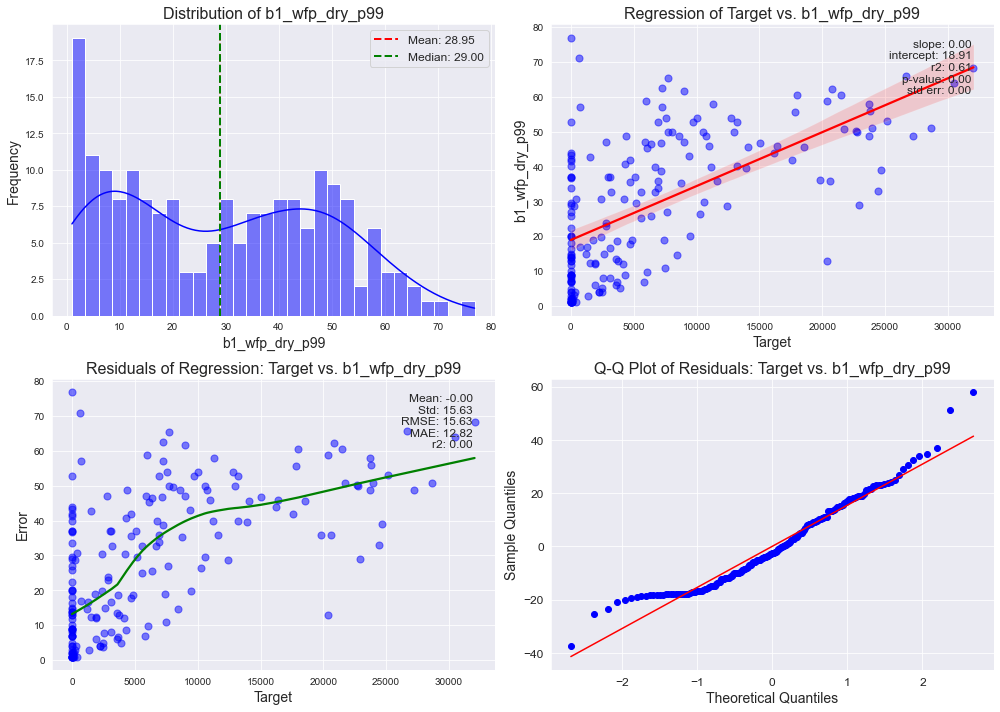

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_wfp_dry_p99_0_combined_plot_tr.JPG


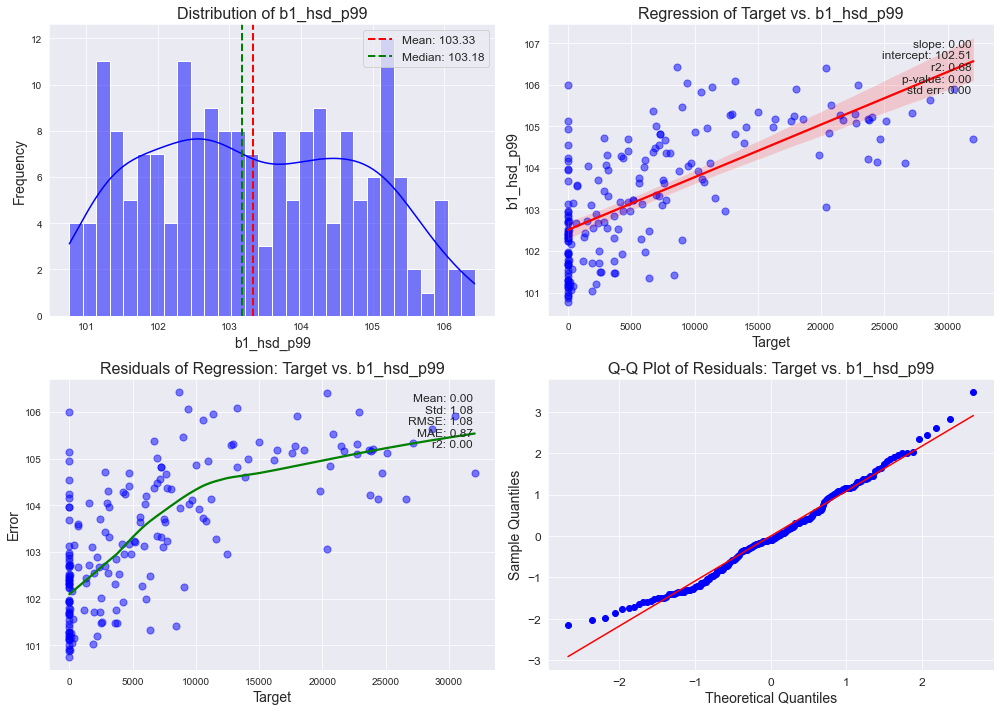

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_hsd_p99_0_combined_plot_tr.JPG


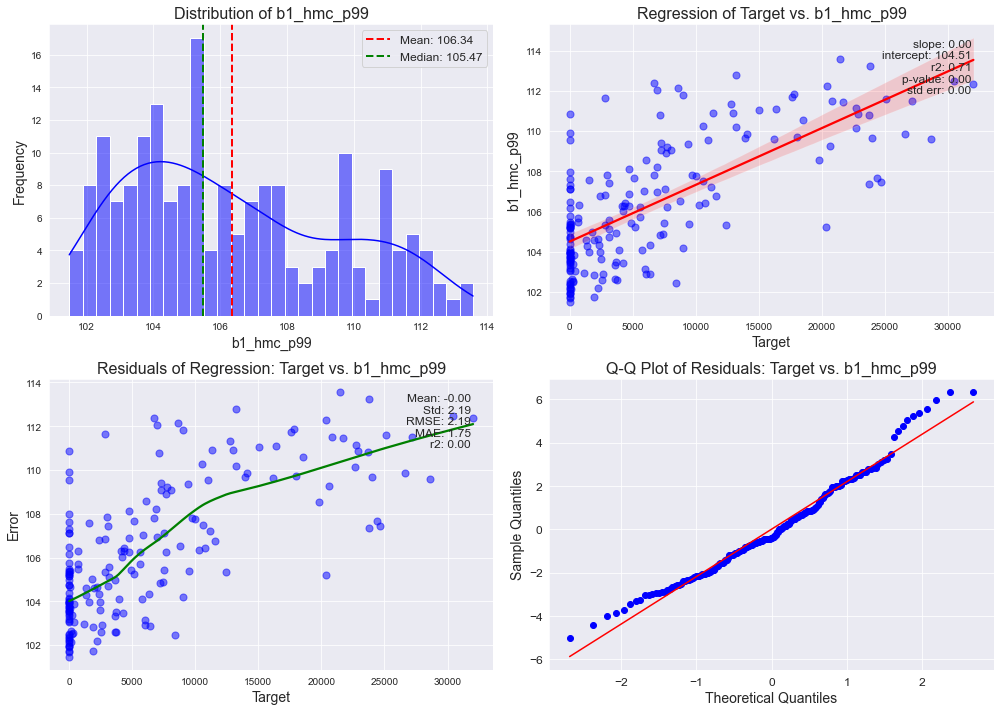

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_hmc_p99_0_combined_plot_tr.JPG


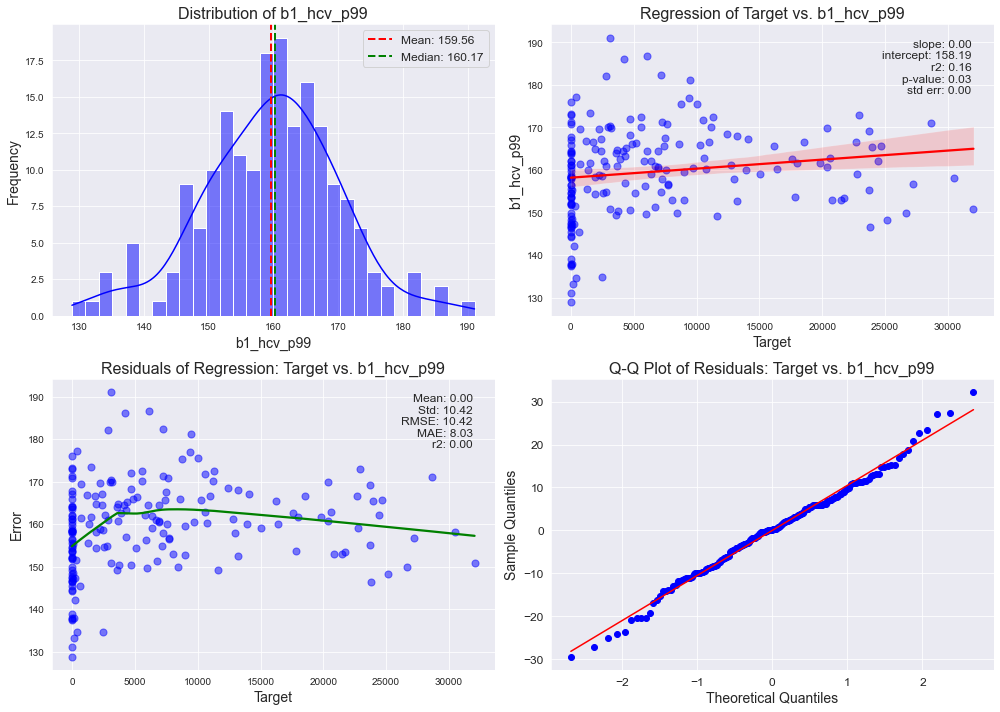

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_hcv_p99_0_combined_plot_tr.JPG


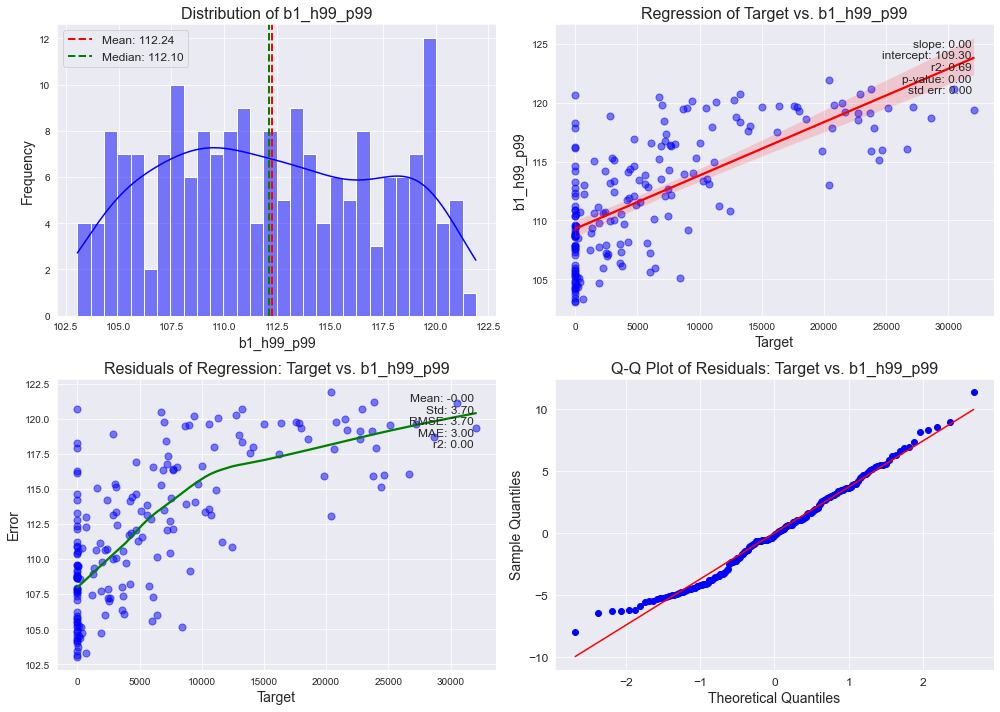

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_h99_p99_0_combined_plot_tr.JPG


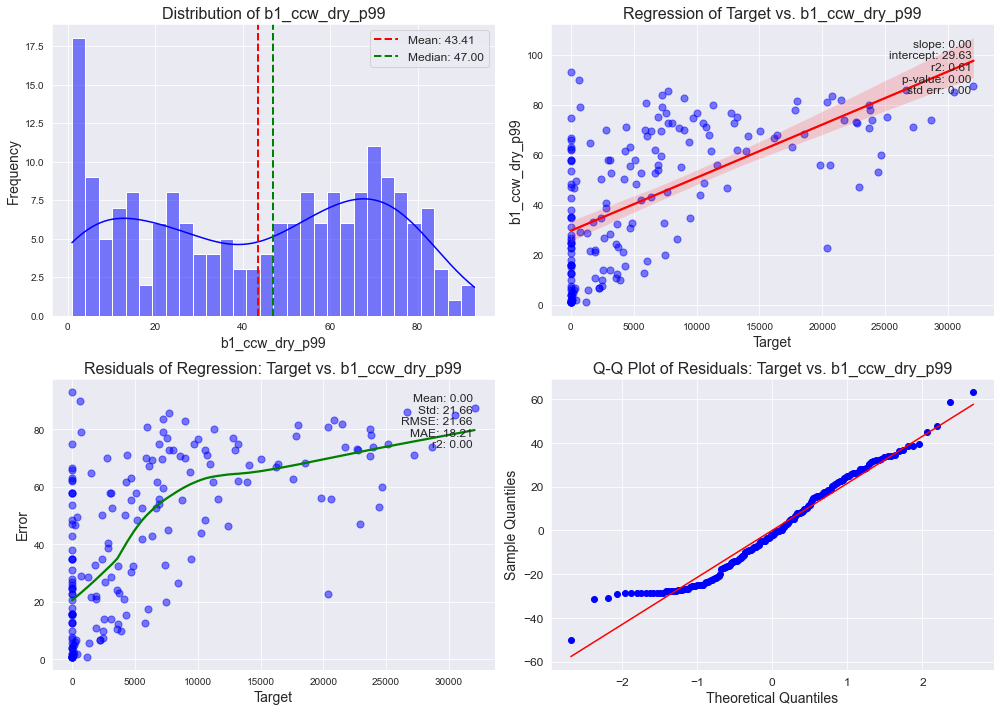

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_ccw_dry_p99_0_combined_plot_tr.JPG


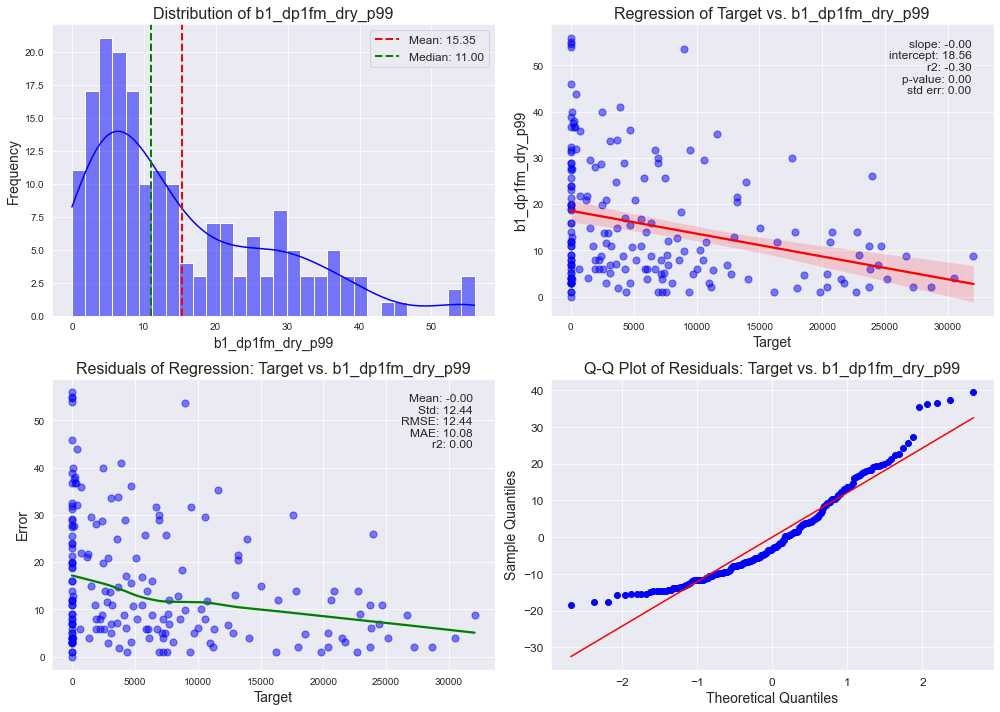

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_dp1fm_dry_p99_0_combined_plot_tr.JPG


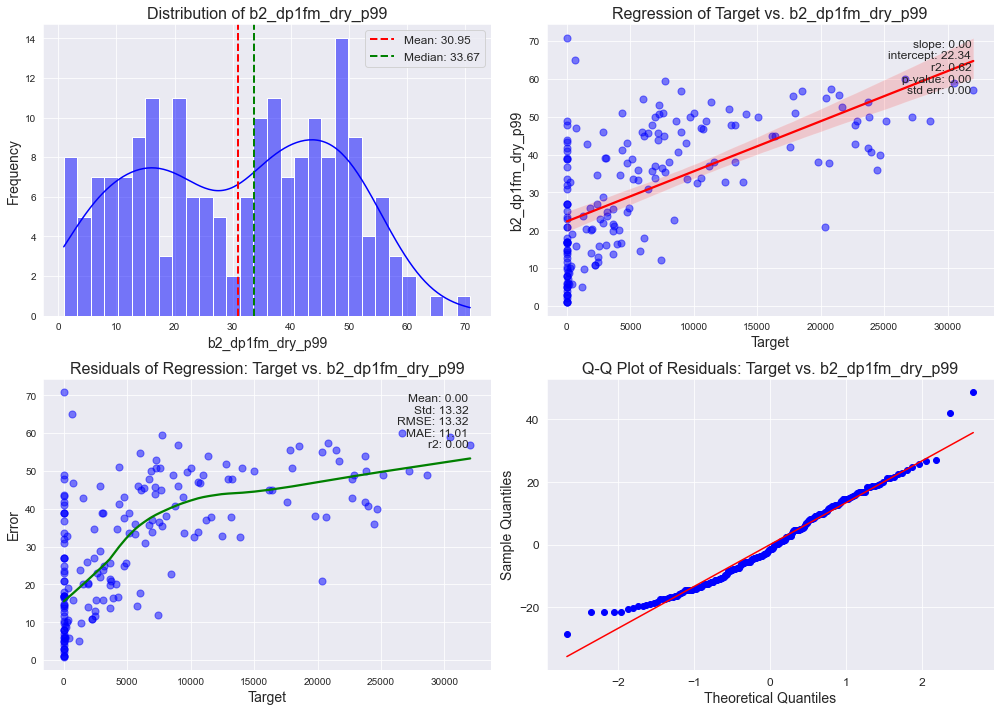

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b2_dp1fm_dry_p99_0_combined_plot_tr.JPG


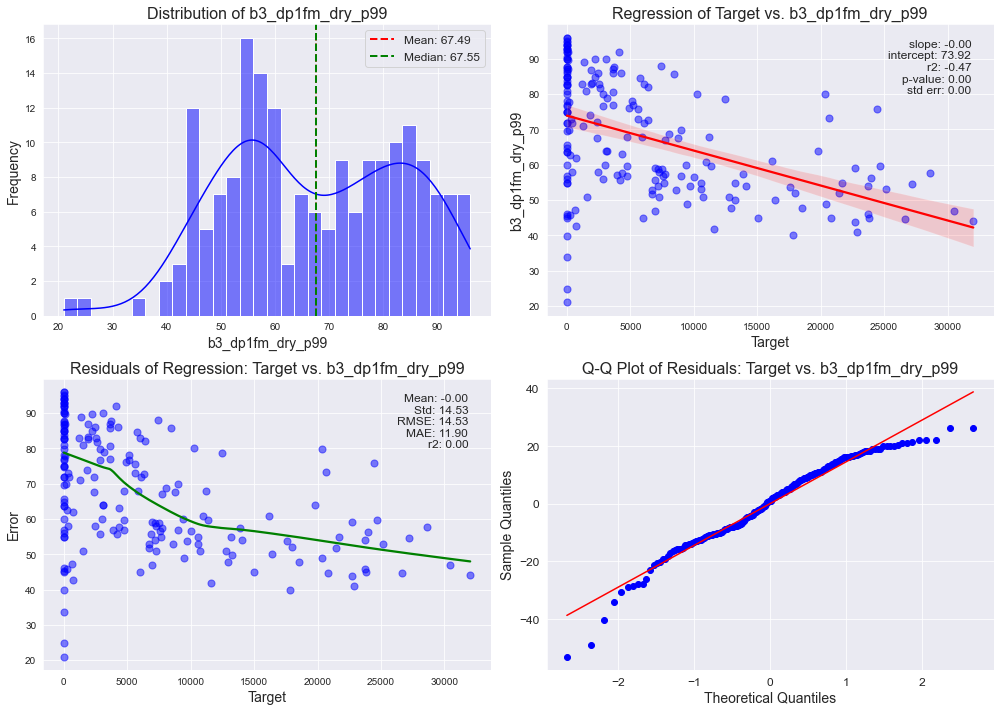

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b3_dp1fm_dry_p99_0_combined_plot_tr.JPG


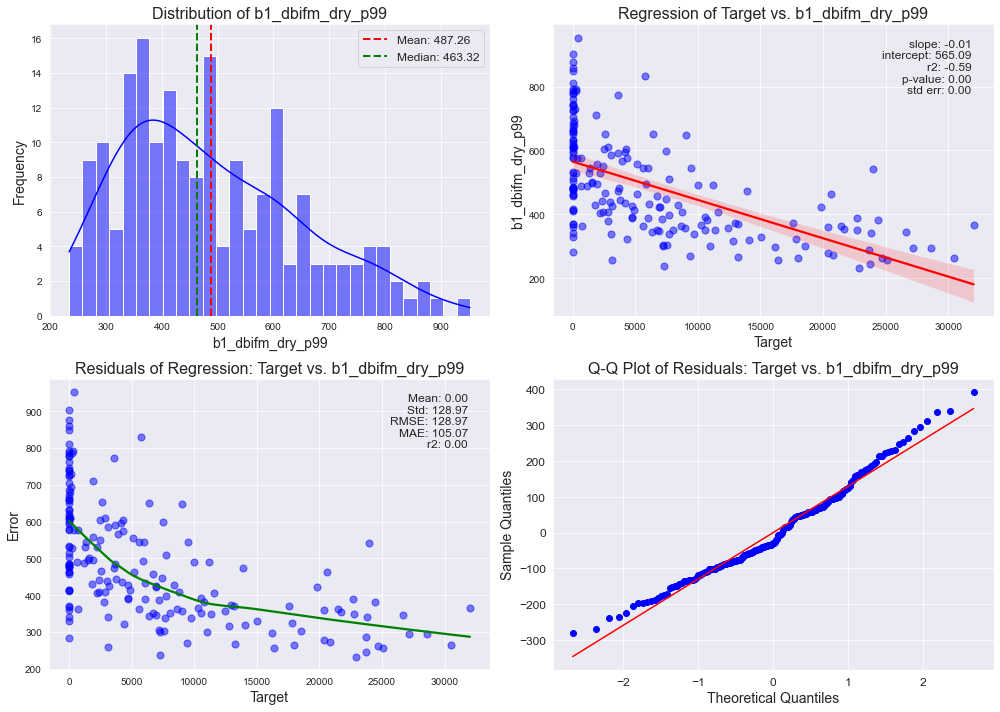

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_dbifm_dry_p99_0_combined_plot_tr.JPG


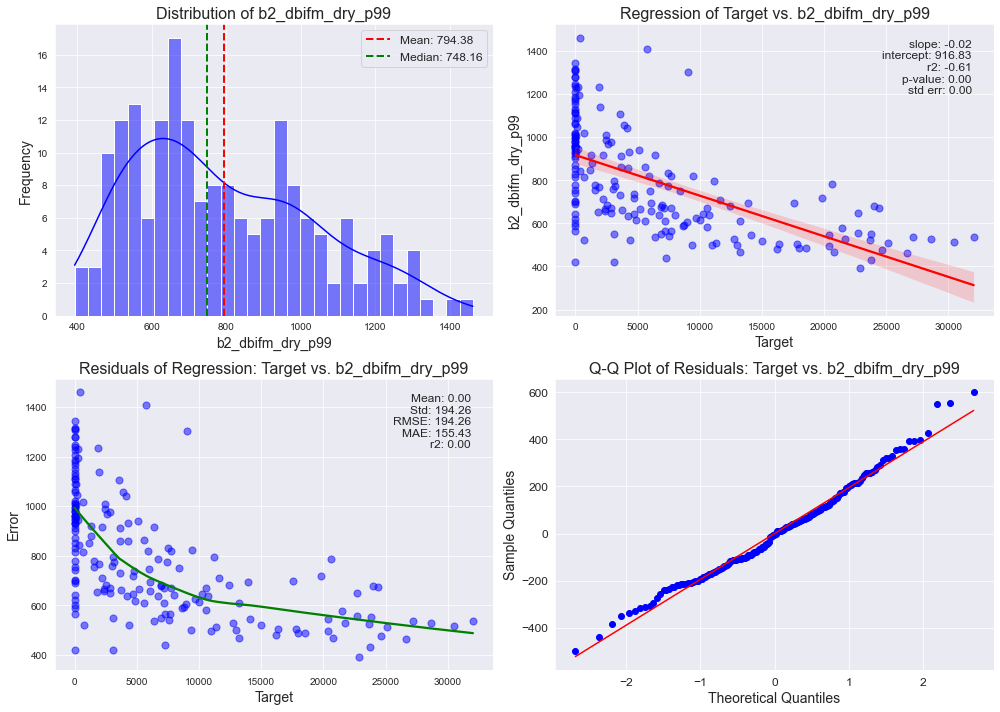

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b2_dbifm_dry_p99_0_combined_plot_tr.JPG


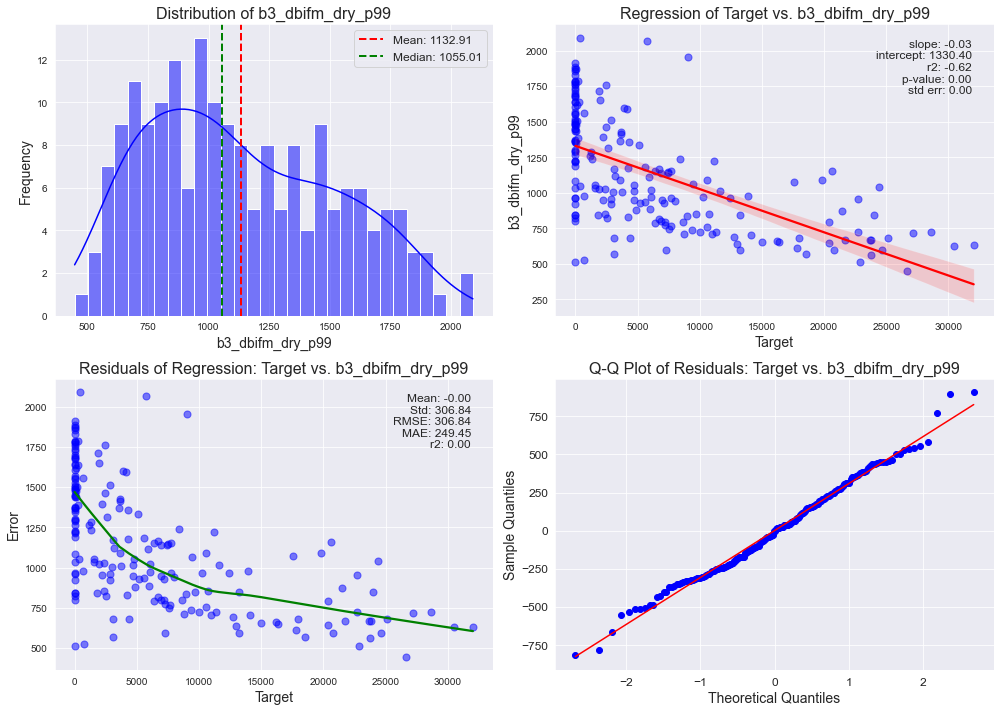

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b3_dbifm_dry_p99_0_combined_plot_tr.JPG


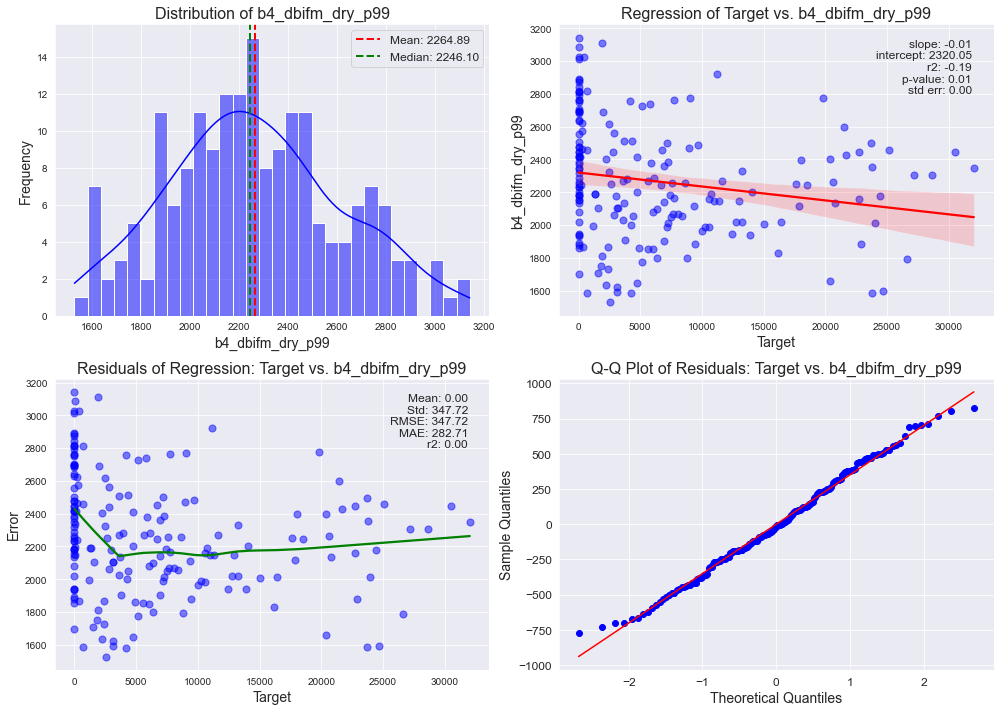

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b4_dbifm_dry_p99_0_combined_plot_tr.JPG


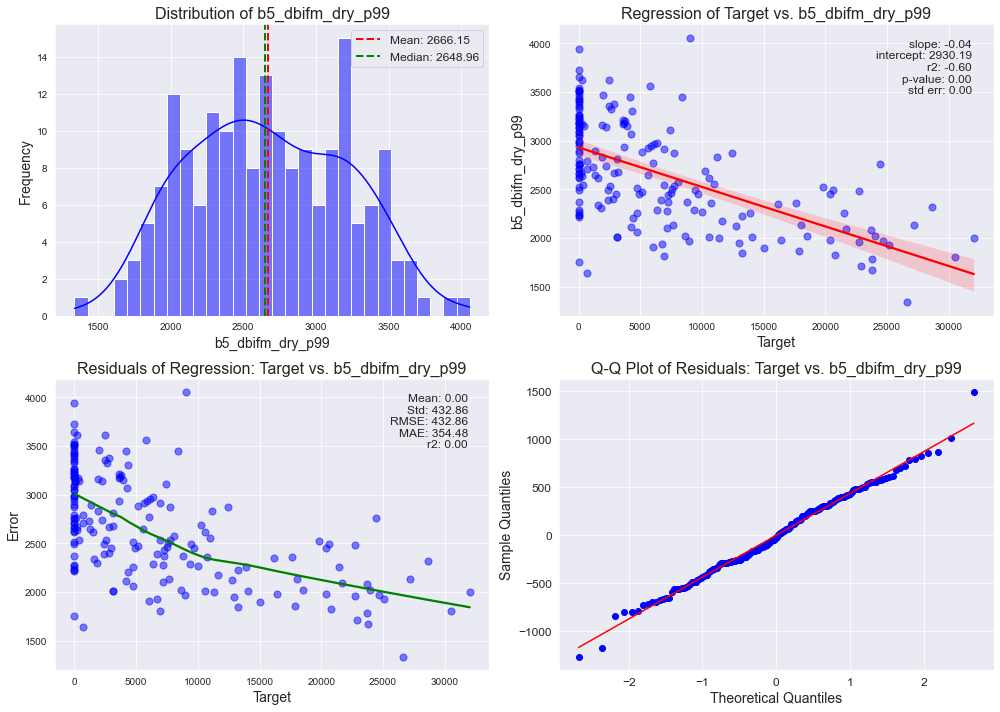

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b5_dbifm_dry_p99_0_combined_plot_tr.JPG


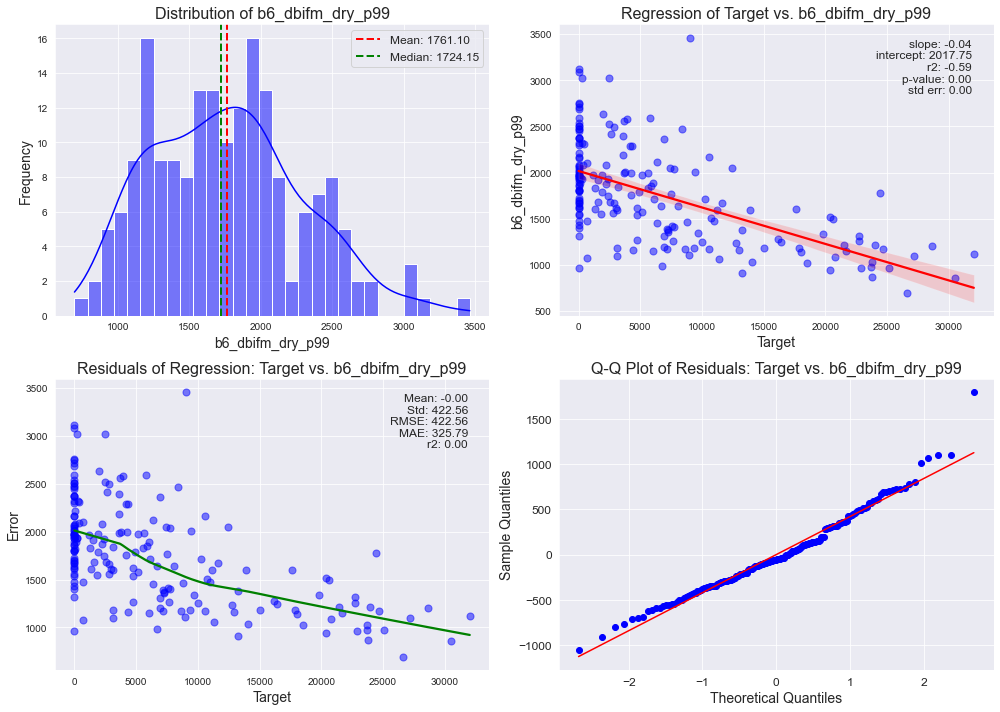

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b6_dbifm_dry_p99_0_combined_plot_tr.JPG


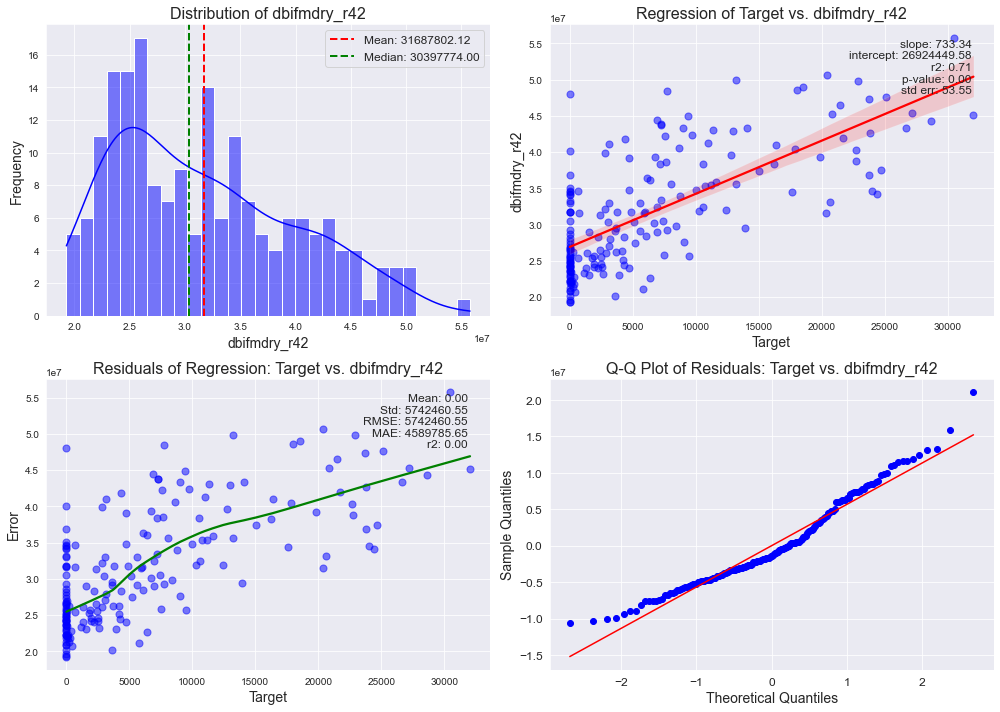

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_r42_0_combined_plot_tr.JPG


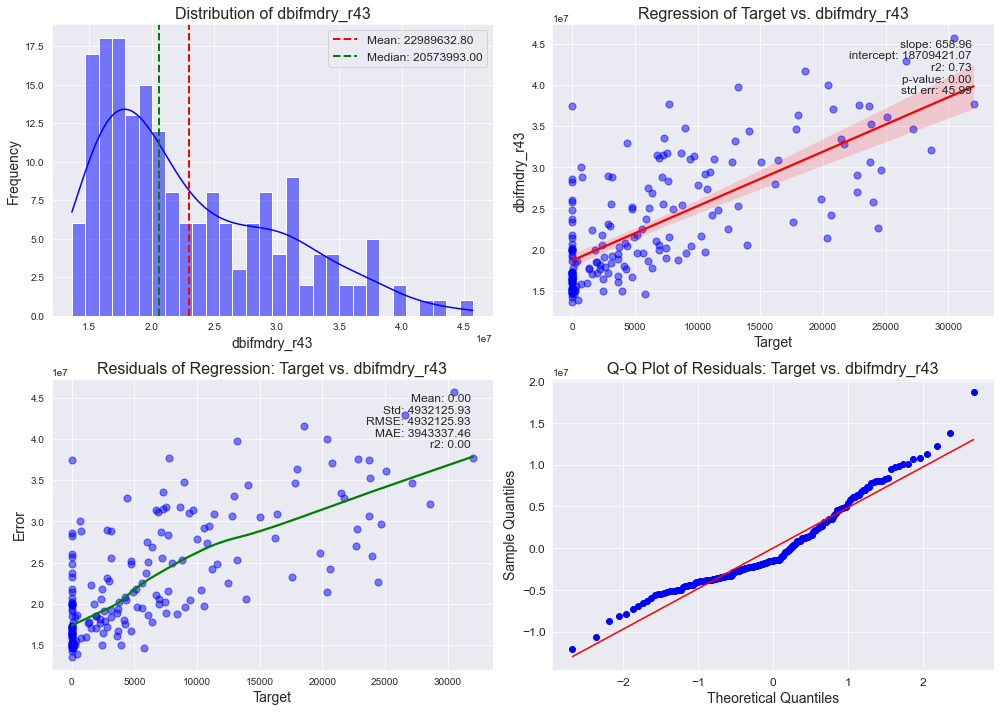

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_r43_0_combined_plot_tr.JPG


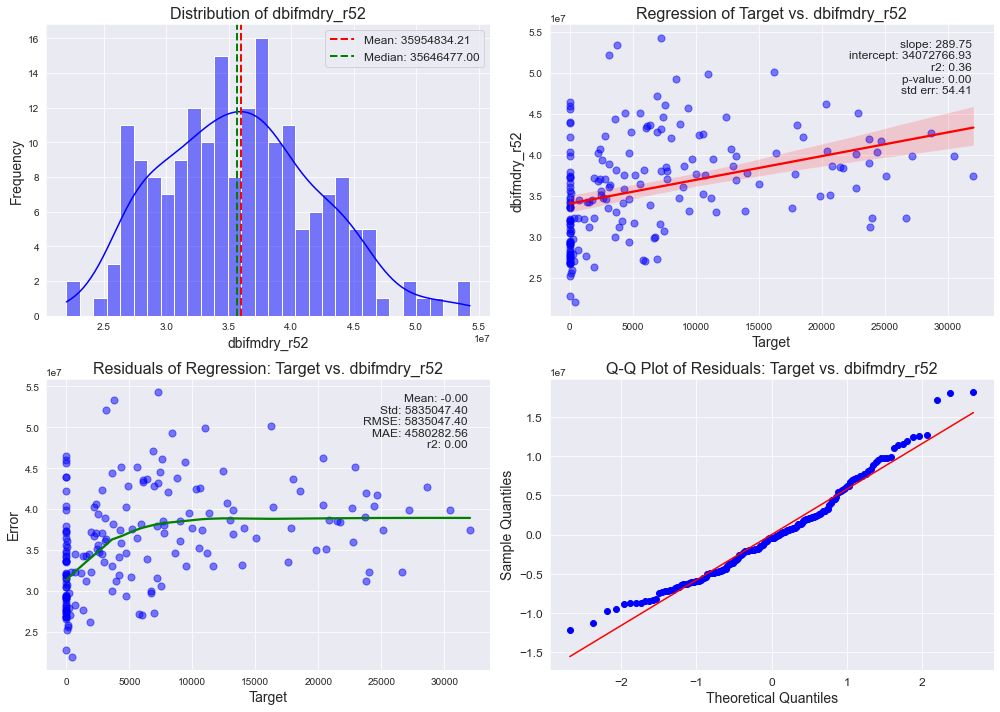

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_r52_0_combined_plot_tr.JPG


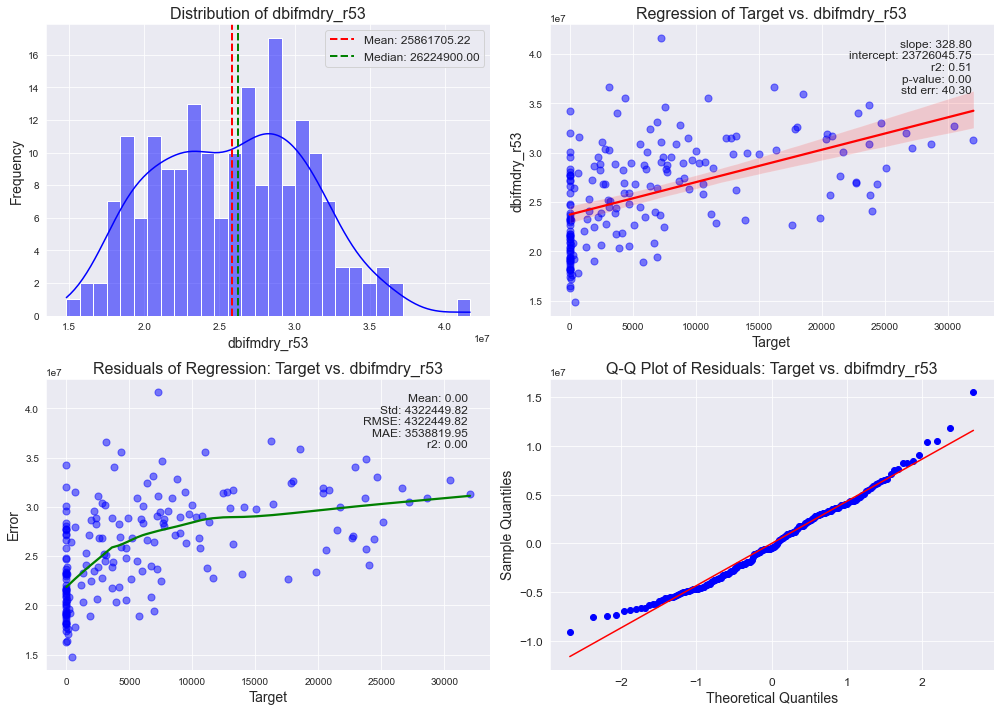

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_r53_0_combined_plot_tr.JPG


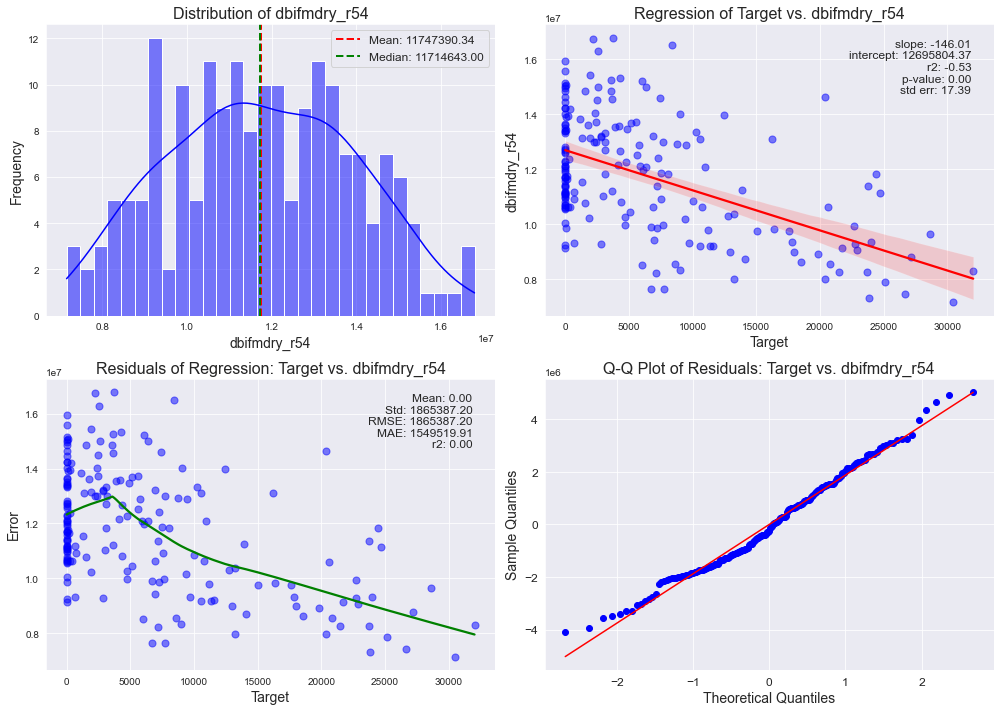

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_r54_0_combined_plot_tr.JPG


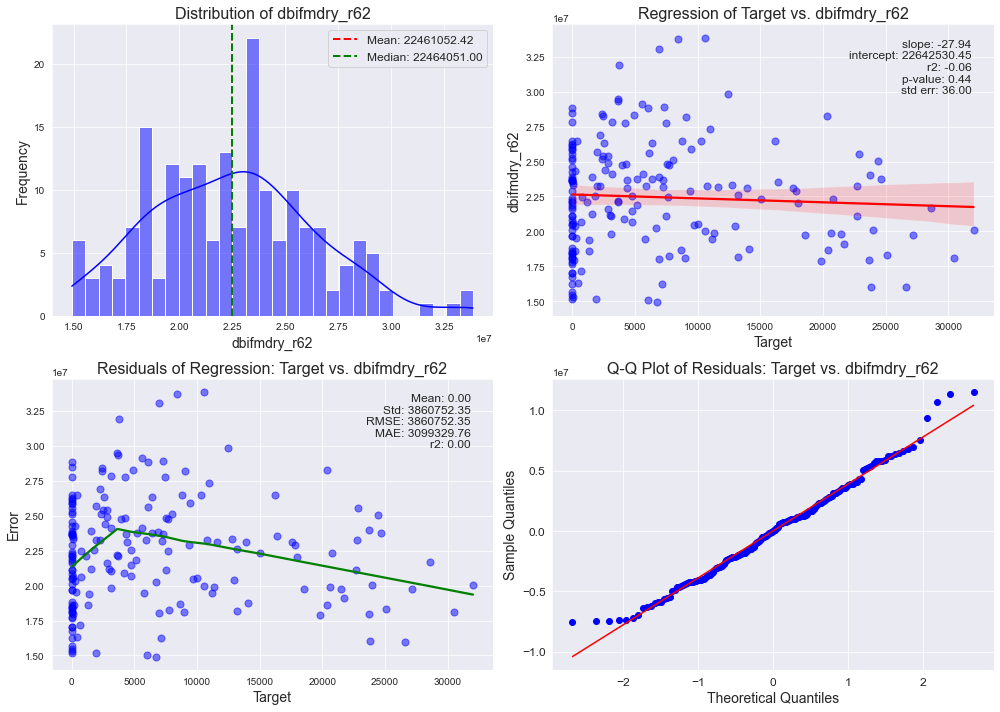

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_r62_0_combined_plot_tr.JPG


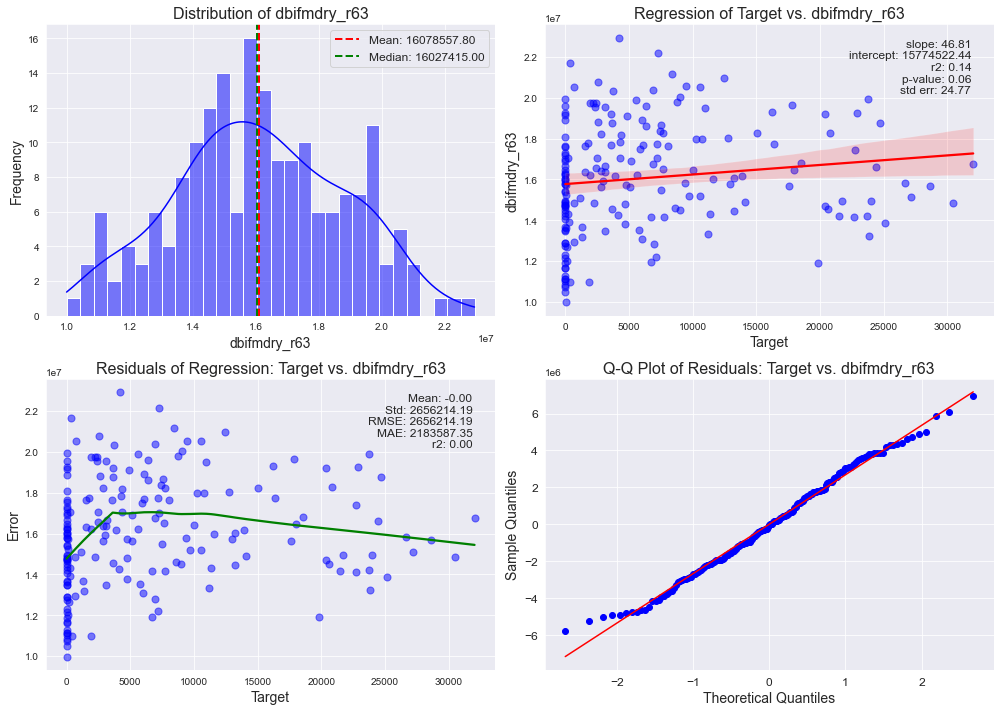

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_r63_0_combined_plot_tr.JPG


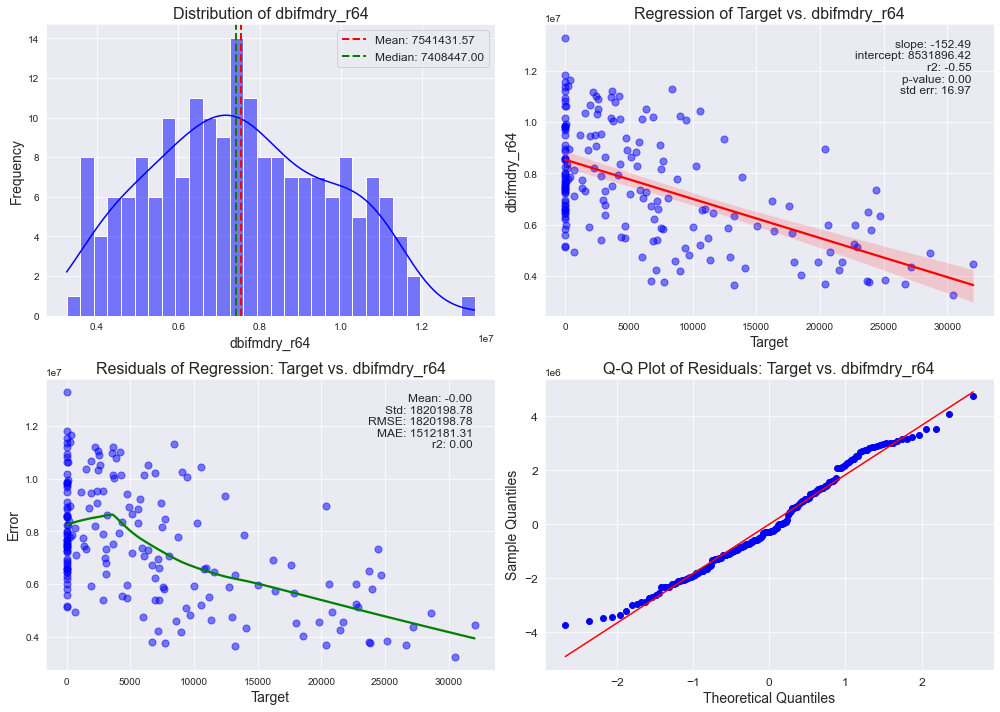

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_r64_0_combined_plot_tr.JPG


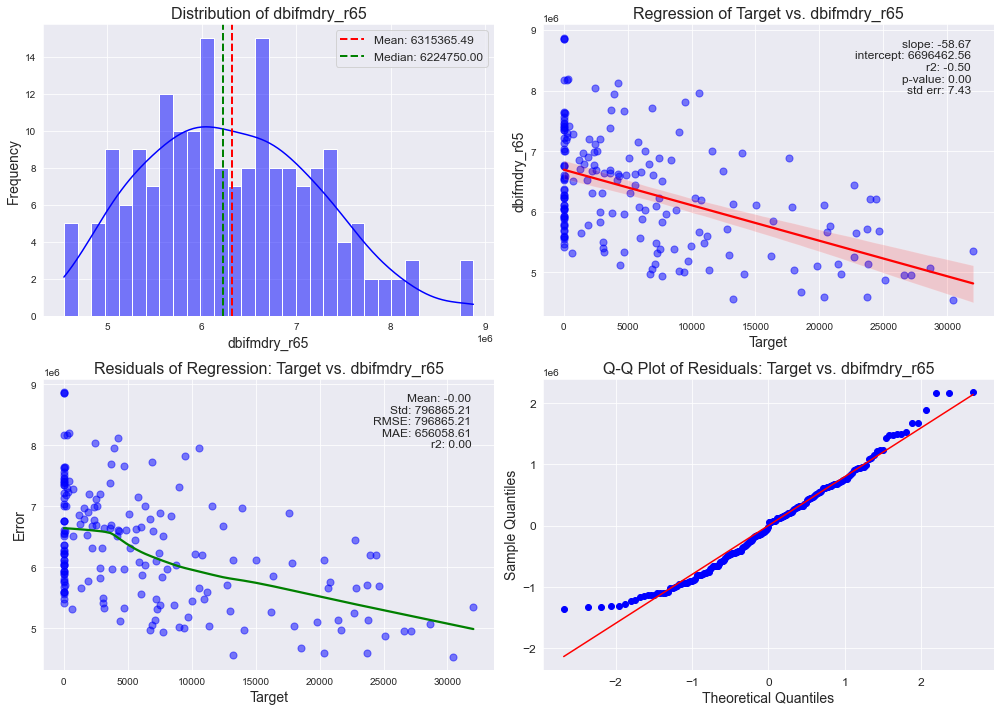

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_r65_0_combined_plot_tr.JPG


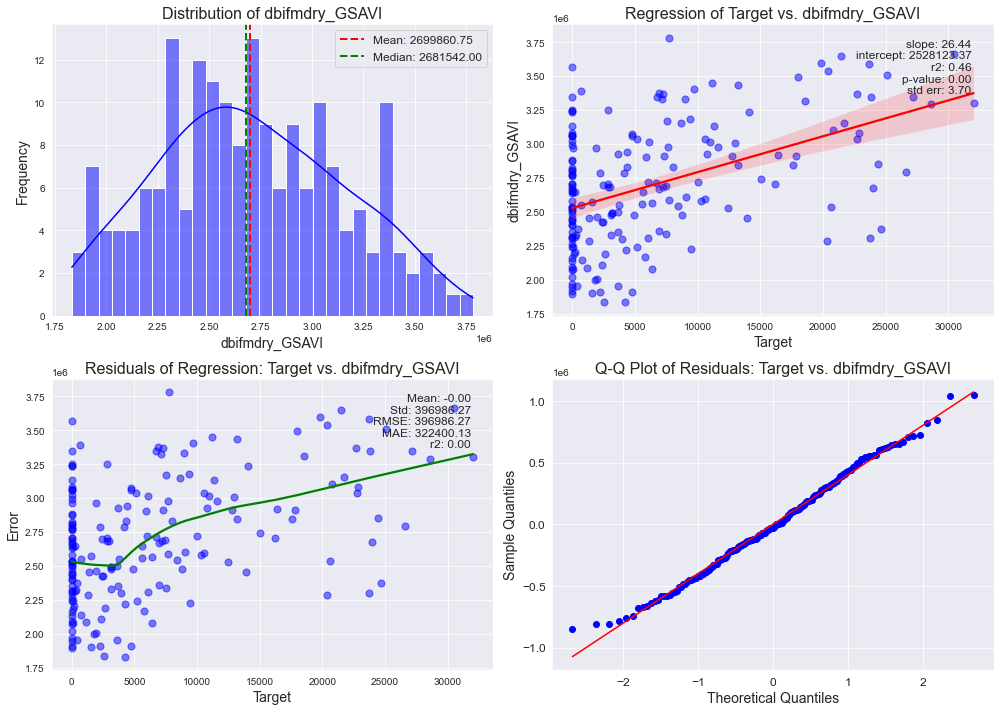

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_GSAVI_0_combined_plot_tr.JPG


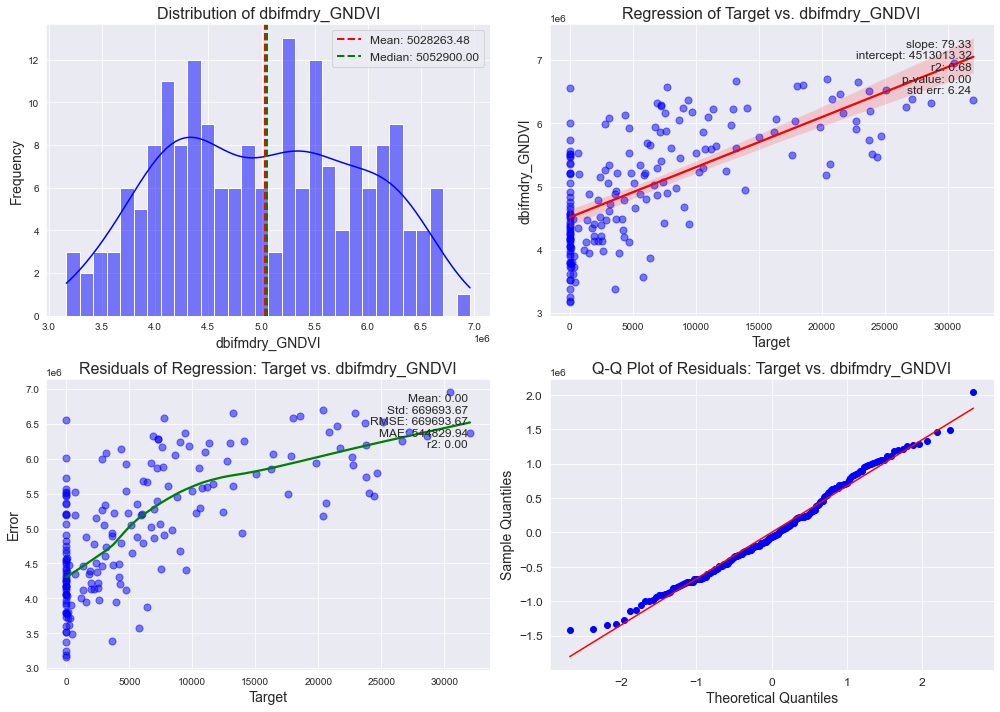

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_GNDVI_0_combined_plot_tr.JPG


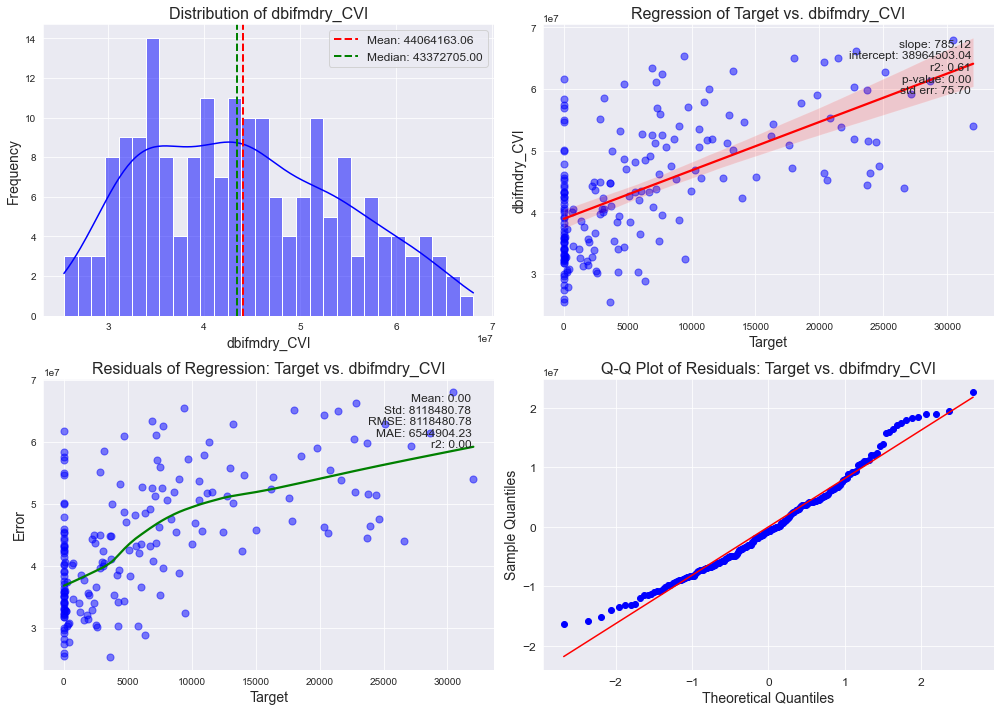

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_CVI_0_combined_plot_tr.JPG


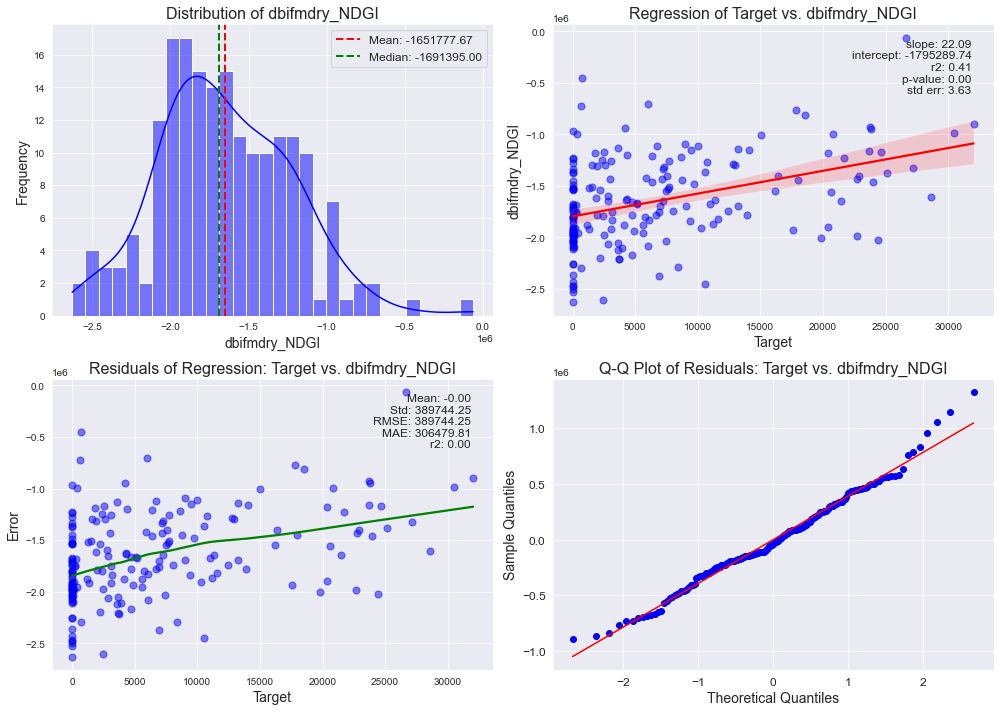

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_NDGI_0_combined_plot_tr.JPG


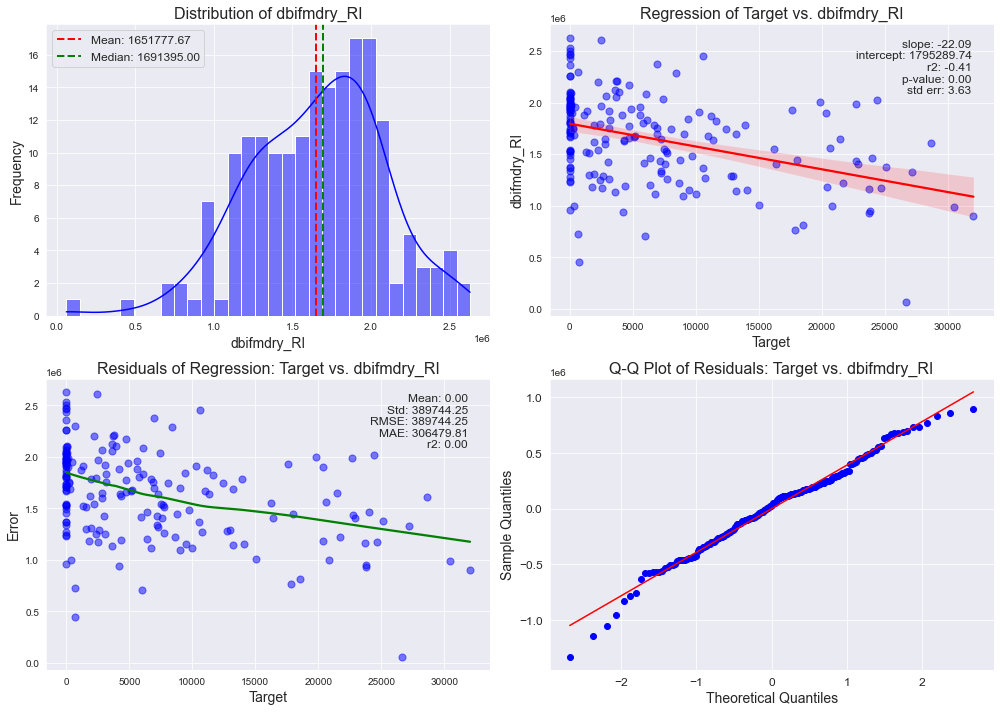

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_RI_0_combined_plot_tr.JPG


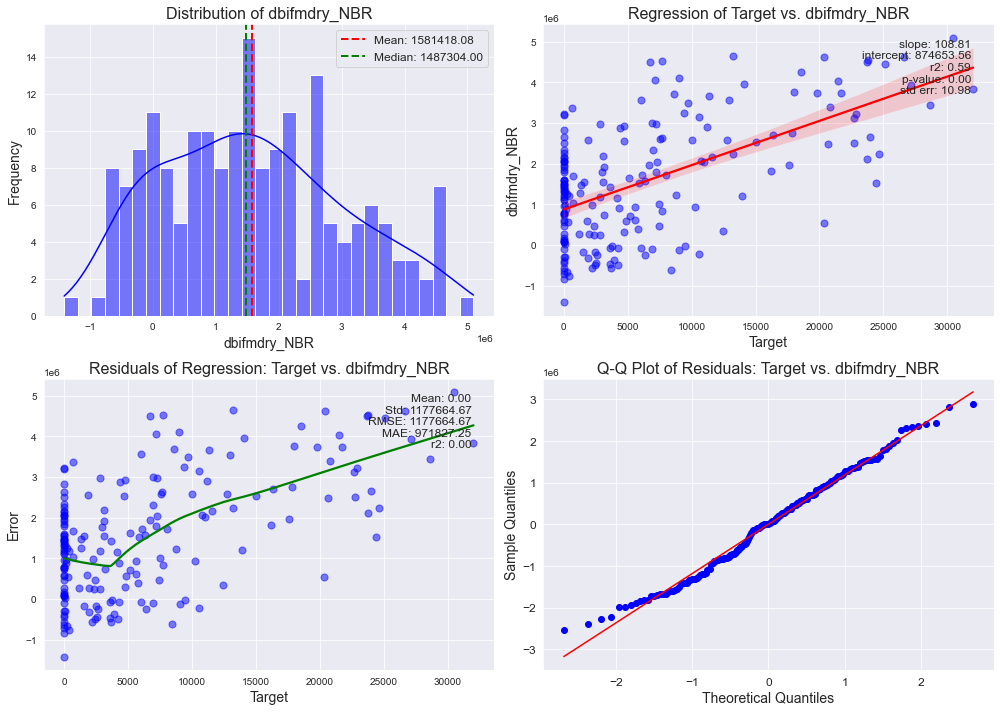

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_NBR_0_combined_plot_tr.JPG


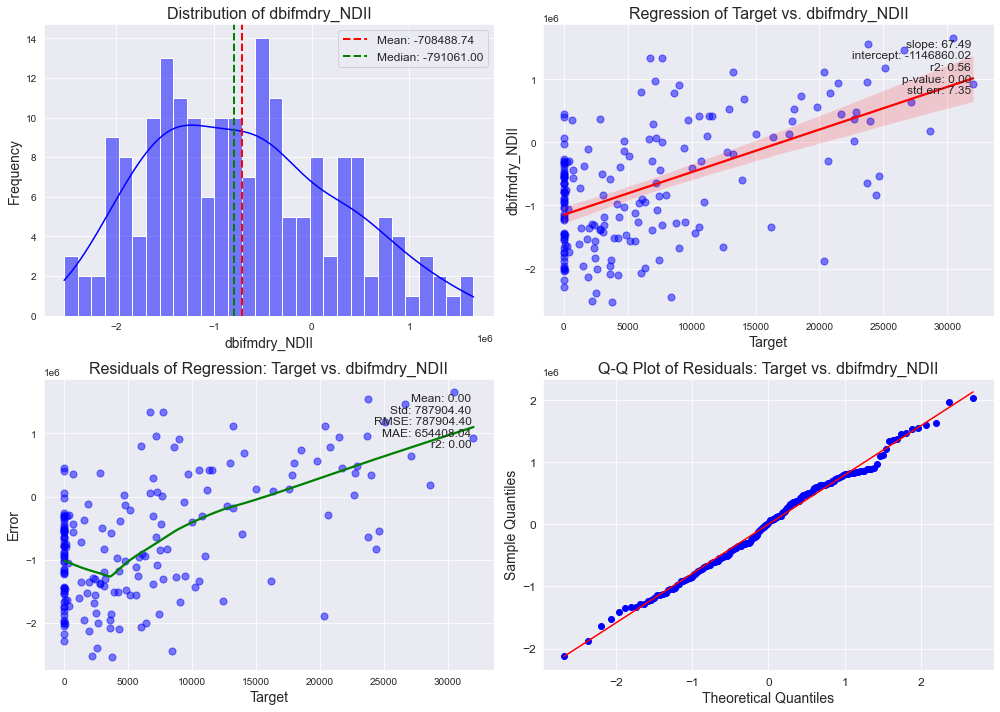

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_NDII_0_combined_plot_tr.JPG


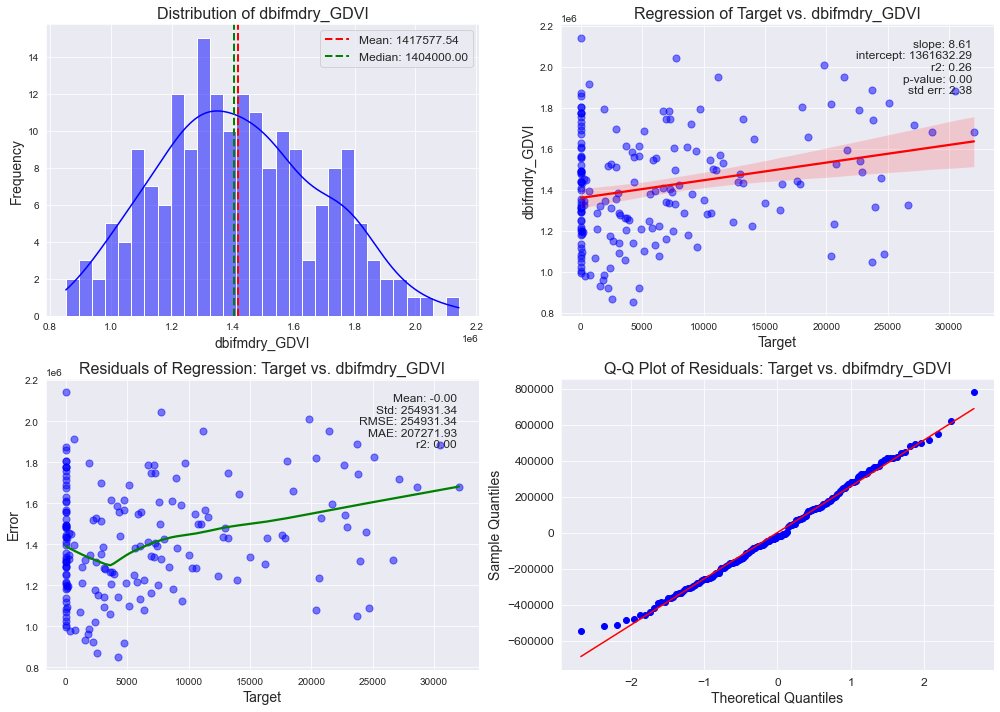

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_GDVI_0_combined_plot_tr.JPG


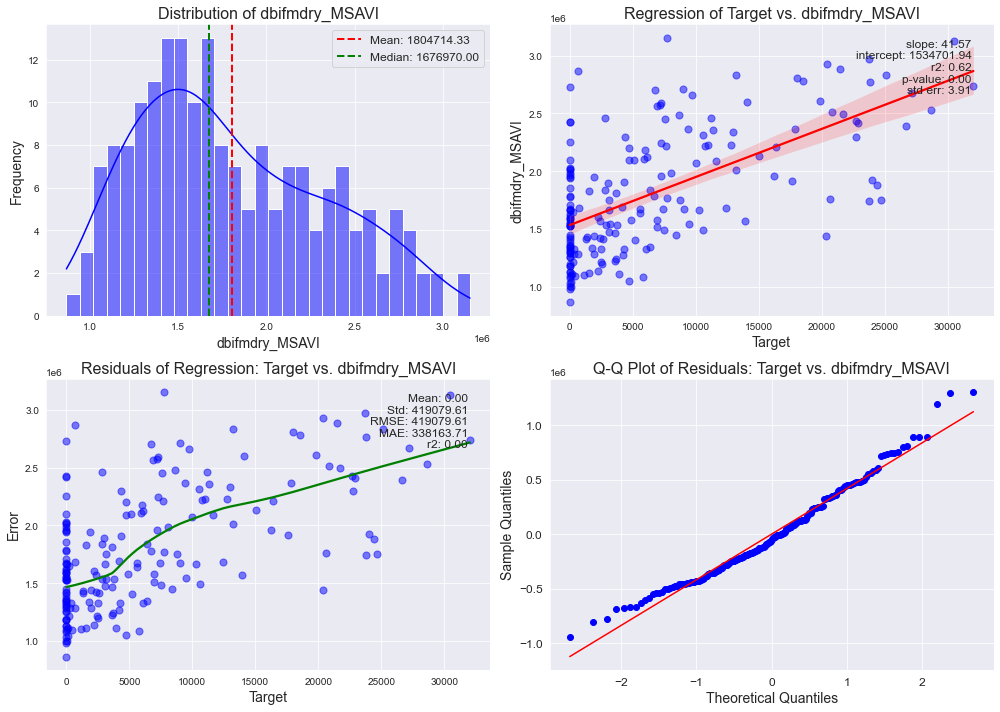

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_MSAVI_0_combined_plot_tr.JPG


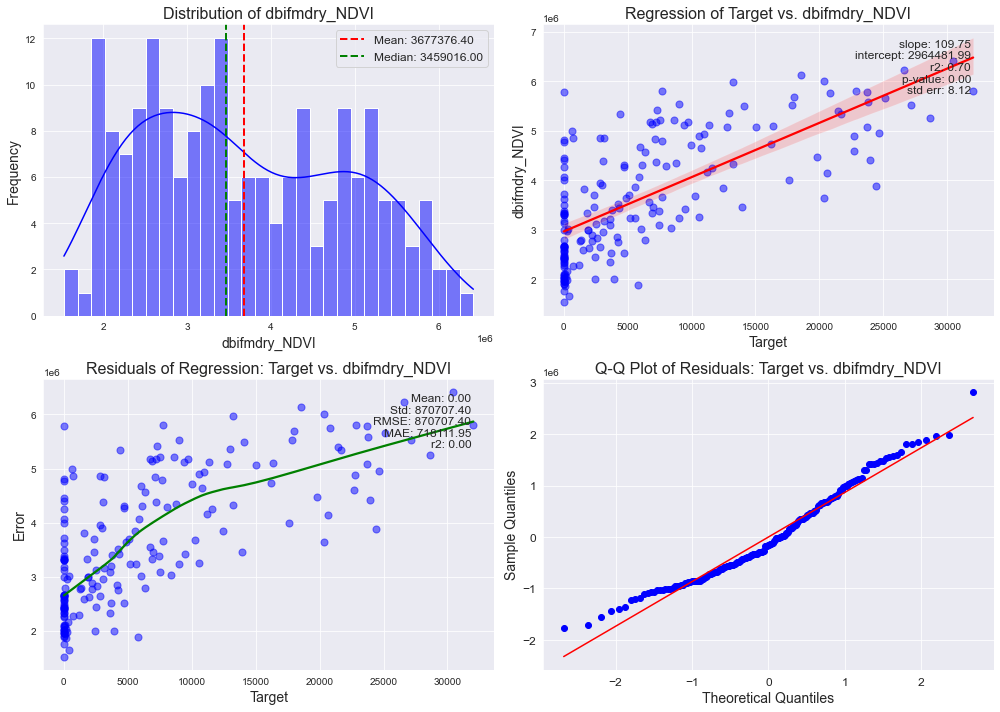

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_NDVI_0_combined_plot_tr.JPG


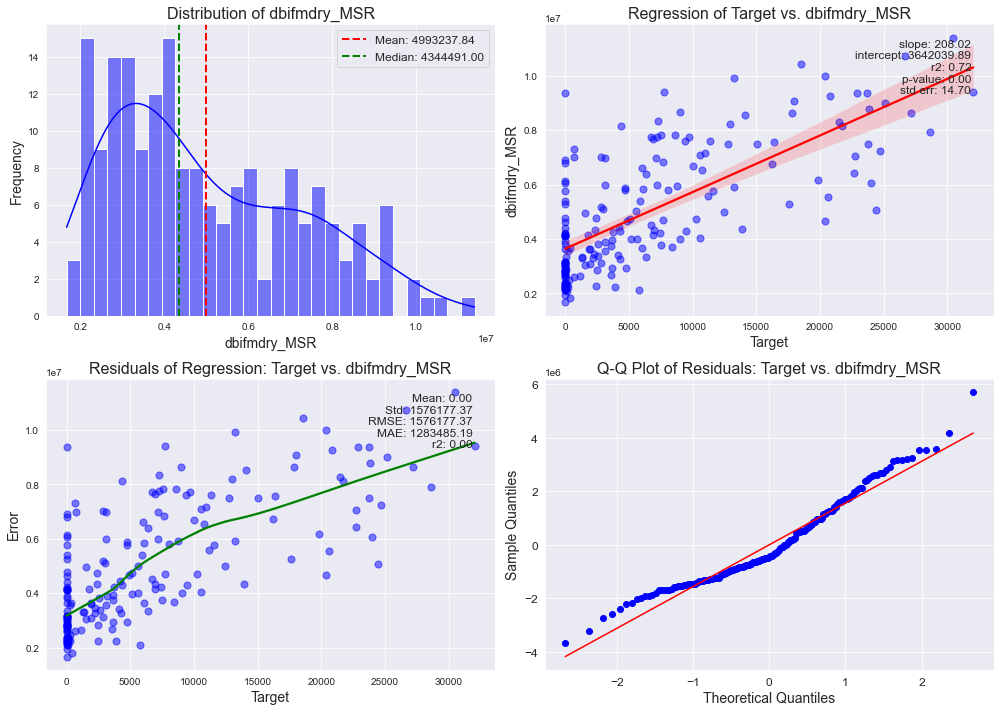

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_dbifmdry_MSR_0_combined_plot_tr.JPG


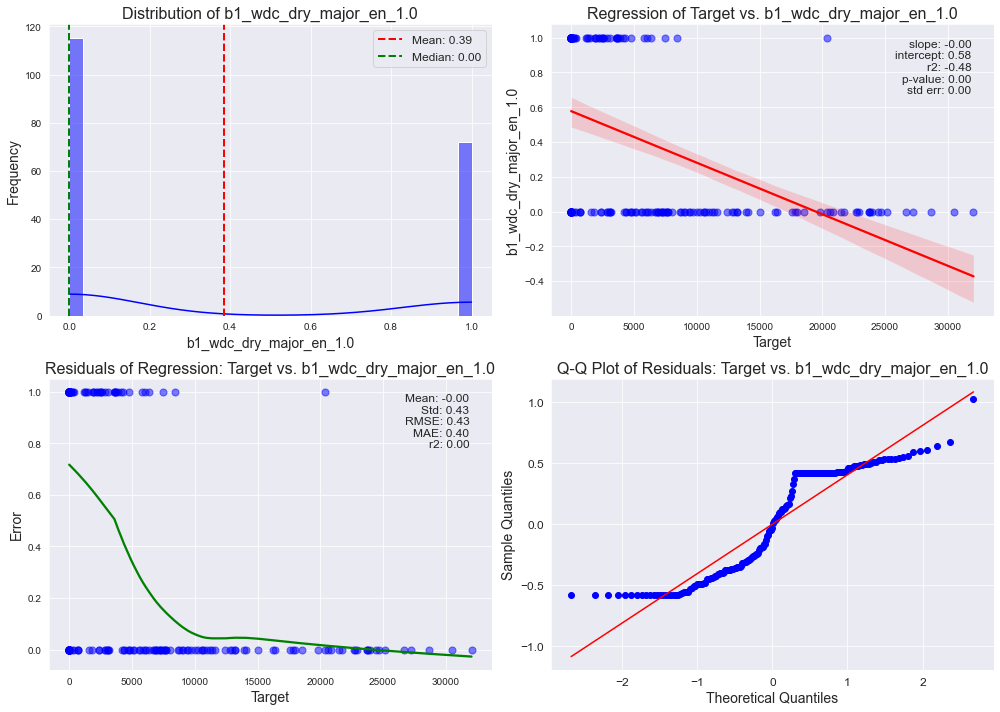

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_wdc_dry_major_en_1.0_0_combined_plot_tr.JPG


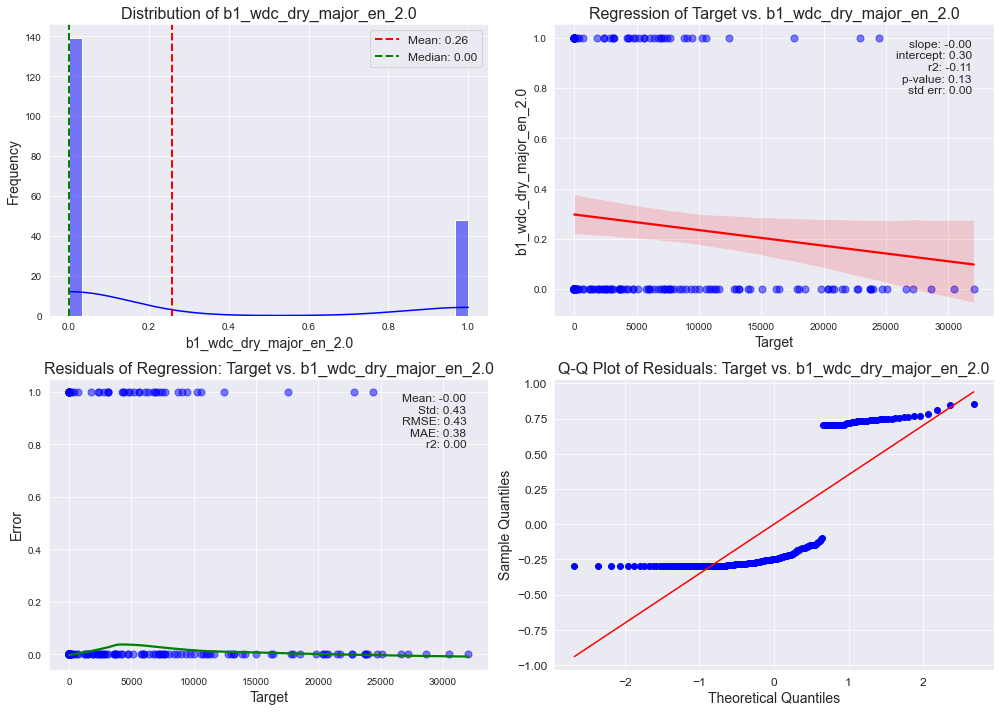

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_wdc_dry_major_en_2.0_0_combined_plot_tr.JPG


plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_wdc_dry_major_en_3.0_0_combined_plot_tr.JPG


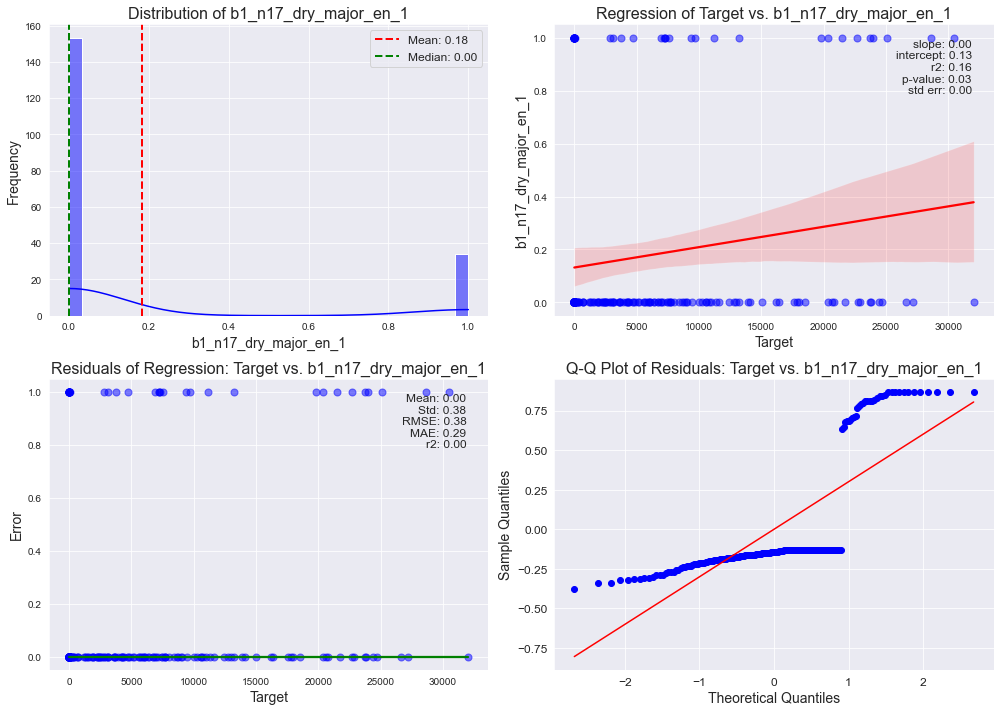

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_1_0_combined_plot_tr.JPG


plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_2_0_combined_plot_tr.JPG


plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_3_0_combined_plot_tr.JPG


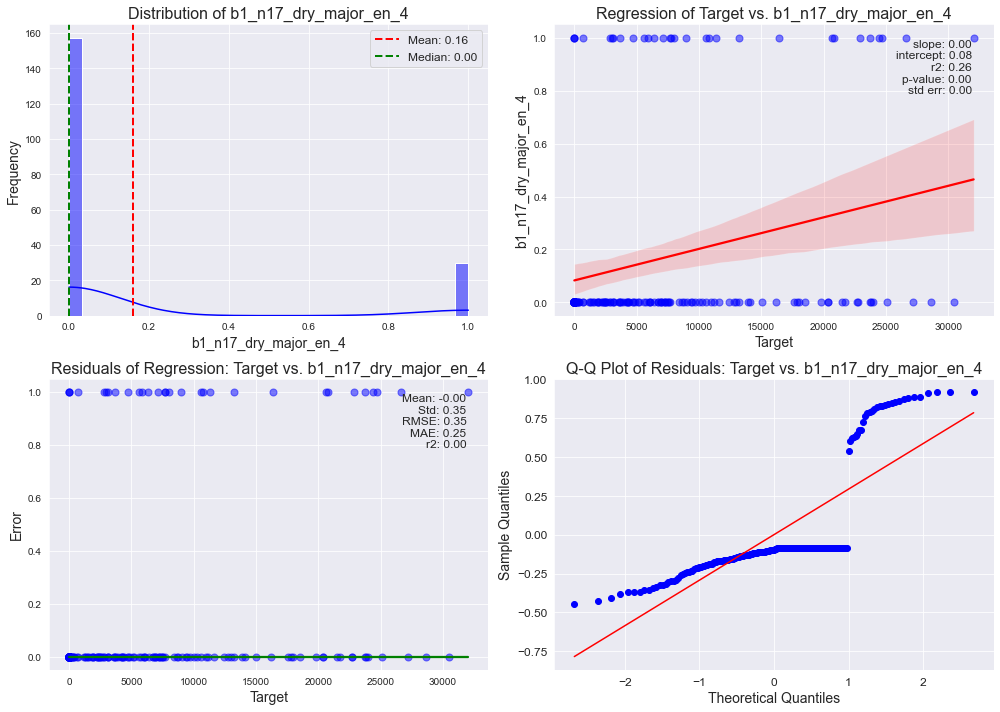

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_4_0_combined_plot_tr.JPG


plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_5_0_combined_plot_tr.JPG


plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_6_0_combined_plot_tr.JPG


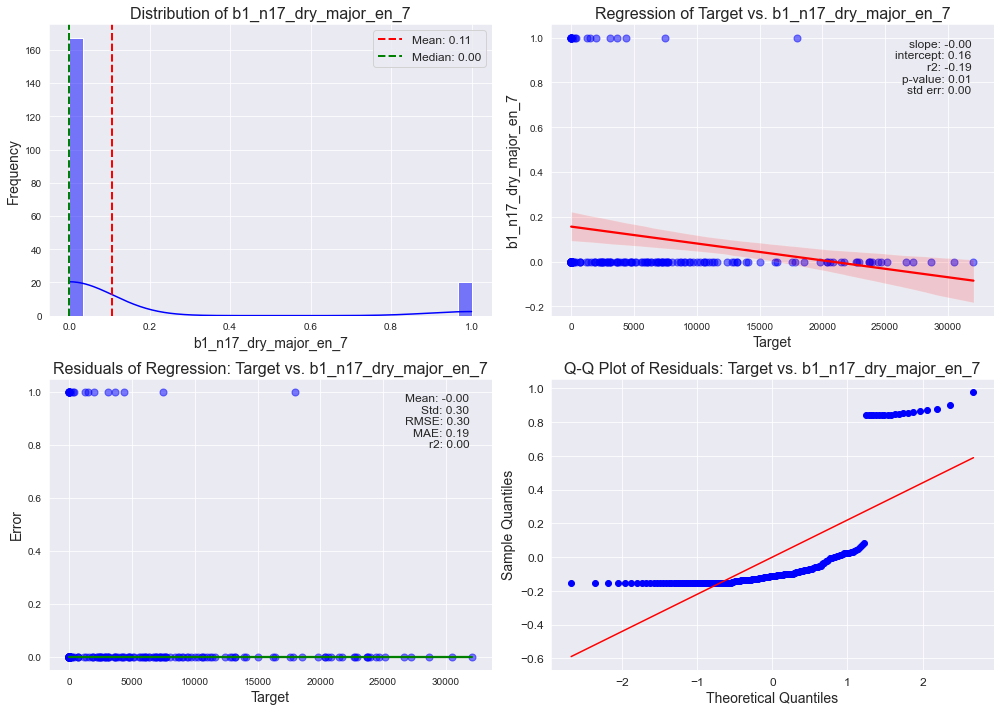

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_7_0_combined_plot_tr.JPG


plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_8_0_combined_plot_tr.JPG


plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_10_0_combined_plot_tr.JPG


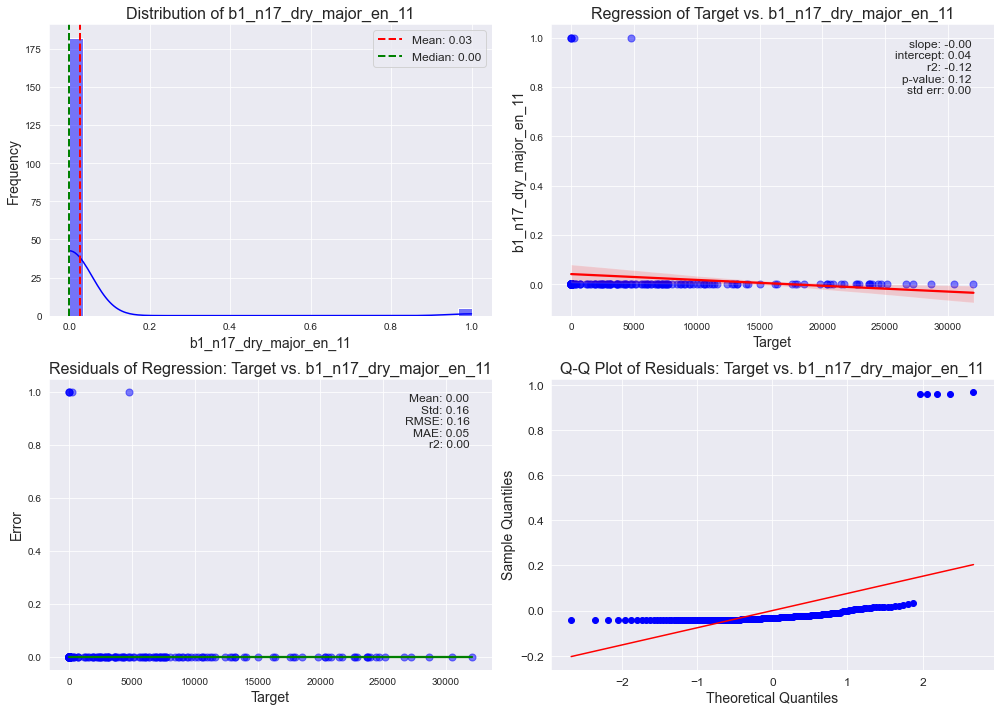

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_n17_dry_major_en_11_0_combined_plot_tr.JPG


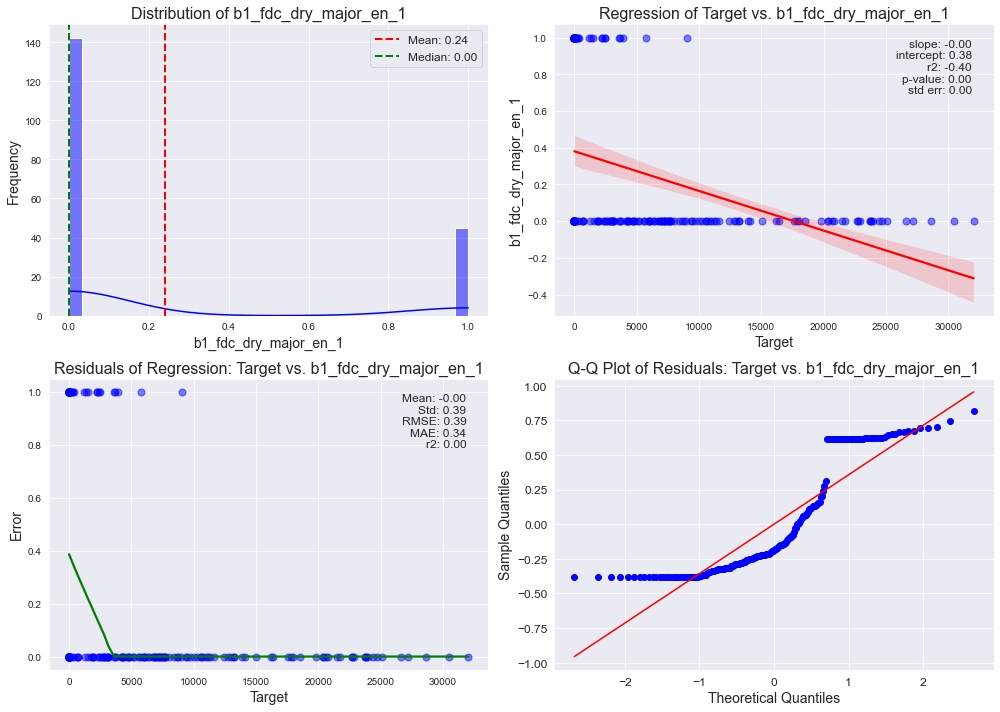

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_fdc_dry_major_en_1_0_combined_plot_tr.JPG


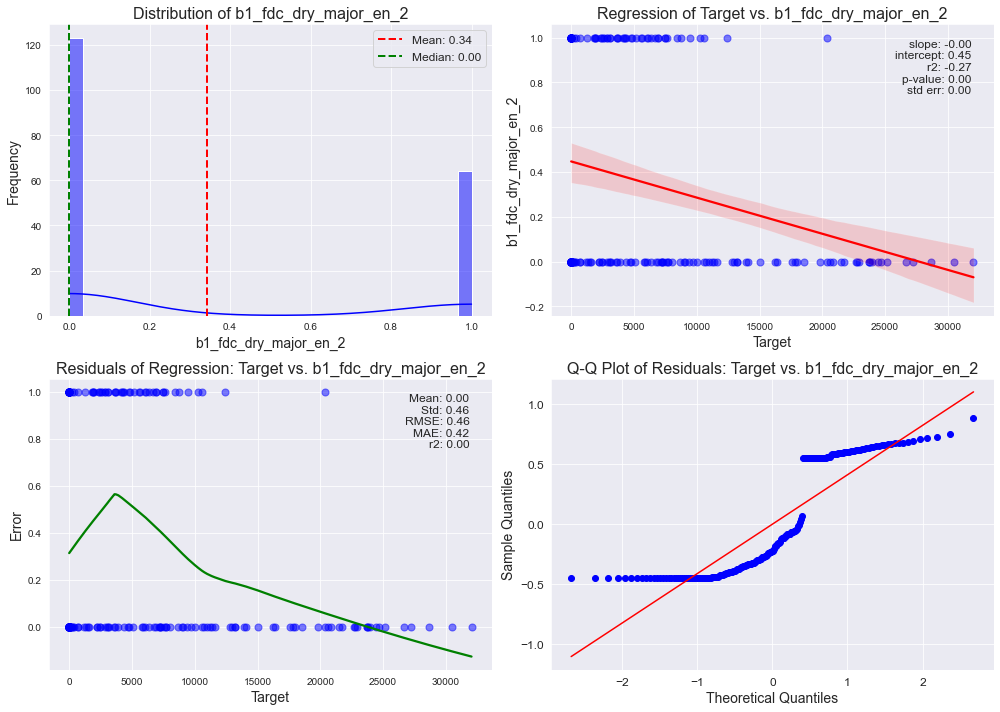

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_fdc_dry_major_en_2_0_combined_plot_tr.JPG


plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_fdc_dry_major_en_3_0_combined_plot_tr.JPG


In [64]:
df = df_ml

def plot_with_mean_median(df, columns):
    for col in columns:
        plt.figure(figsize=(14, 10))

        # Top-left plot: Distribution with mean and median
        plt.subplot(2, 2, 1)
        sns.histplot(df[col], kde=True, color='blue', bins=30)
        
        # Calculate mean and median
        mean = df[col].mean()
        median = df[col].median()
        
        # Plot mean and median as dashed lines
        plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
        plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
        
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.legend(fontsize=12)
        
        # Top-right plot: Regression plot
        value_x = 'target'
        C_value_x = "Target"
        value_y_loop = col

        plt.subplot(2, 2, 2)
        sns.regplot(data=df_ml, x=value_x, y=value_y_loop, line_kws={"color": "red"}, scatter_kws={'s': 50, 'alpha': 0.5, 'color': 'blue'})
        plt.xlabel(C_value_x, fontsize=14)
        plt.ylabel(value_y_loop, fontsize=14)
        plt.title(f"Regression of {C_value_x} vs. {value_y_loop}", fontsize=16)

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_ml[value_x], df_ml[value_y_loop])

        # Annotate the stats
        plt.text(0.95, 0.95, f'slope: {slope:.2f}\nintercept: {intercept:.2f}\nr2: {r_value:.2f}\np-value: {p_value:.2f}\nstd err: {std_err:.2f}',
                 transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', fontsize=12)

        # Bottom-left plot: Residuals plot
        plt.subplot(2, 2, 3)
        sns.regplot(data=df_ml, x=value_x, y=value_y_loop, lowess=True, line_kws={"color": "green"}, scatter_kws={'s': 50, 'alpha': 0.5, 'color': 'blue'})
        plt.xlabel(C_value_x, fontsize=14)
        plt.ylabel("Error", fontsize=14)
        plt.title(f"Residuals of Regression: {C_value_x} vs. {value_y_loop}", fontsize=16)

        residuals = df_ml[value_y_loop] - (slope * df_ml[value_x] + intercept)

        # Compute additional residual statistics
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        rmse_res = np.sqrt(np.mean(residuals**2))
        mae_res = np.mean(np.abs(residuals))
        r2_res = scipy.stats.linregress(df_ml[value_x], residuals)[2]**2

        # Annotate the residual stats
        plt.text(0.95, 0.95, f'Mean: {mean_res:.2f}\nStd: {std_res:.2f}\nRMSE: {rmse_res:.2f}\nMAE: {mae_res:.2f}\nr2: {r2_res:.2f}',
                 transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', fontsize=12)

        # Bottom-right plot: Q-Q plot
        plt.subplot(2, 2, 4)
        scipy.stats.probplot(residuals, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot of Residuals: {C_value_x} vs. {value_y_loop}", fontsize=16)
        
        # Increase font size for Q-Q plot
        plt.xlabel('Theoretical Quantiles', fontsize=14)
        plt.ylabel('Sample Quantiles', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=12)

        plt.tight_layout()

        # Save the plot
        plt_out = os.path.join(output, "plots", f"{var_}_{mdl}_{value_y_loop}_{rs}_combined_plot_tr.JPG")
        plt.savefig(plt_out, dpi=300)
        plt.show()
        print("plot: ", plt_out)
        plt.close()

# Assuming df_ml.columns[1:] contains the columns to be plotted
plot_with_mean_median(df, df_ml.columns[1:])

plt.close('all')

In [65]:
df = df_ml

def plot_with_mean_median(df, columns):
    for col in columns:
        plt.figure(figsize=(14, 10))

        # Top-left plot: Distribution with mean and median
        plt.subplot(2, 2, 1)
        sns.histplot(df[col], kde=True, color='blue', bins=30)
        
        # Calculate mean and median
        mean = df[col].mean()
        median = df[col].median()
        
        # Plot mean and median as dashed lines
        plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
        plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
        
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.legend(fontsize=12)
        
        # Top-right plot: Regression plot
        value_x = 'target'
        C_value_x = 'Target'
        value_y_loop = col

        plt.subplot(2, 2, 2)
        sns.regplot(data=df_ml, x=value_x, y=value_y_loop, line_kws={"color": "red"}, scatter_kws={'s': 50, 'alpha': 0.5, 'color': 'blue'})
        plt.xlabel(C_value_x, fontsize=14)
        plt.ylabel(value_y_loop, fontsize=14)
        plt.title(f"Regression of {C_value_x} vs. {value_y_loop}", fontsize=16)

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_ml[value_x], df_ml[value_y_loop])

        # Annotate the stats
        plt.text(0.95, 0.05, f'slope: {slope:.2f}\nintercept: {intercept:.2f}\nr2: {r_value:.2f}\np-value: {p_value:.2f}\nstd err: {std_err:.2f}',
                 transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right', fontsize=12)

        # Bottom-left plot: Residuals plot
        plt.subplot(2, 2, 3)
        sns.regplot(data=df_ml, x=value_x, y=value_y_loop, lowess=True, line_kws={"color": "green"}, scatter_kws={'s': 50, 'alpha': 0.5, 'color': 'blue'})
        plt.xlabel(C_value_x, fontsize=14)
        plt.ylabel("Error", fontsize=14)
        plt.title(f"Residuals of Regression: {C_value_x} vs. {value_y_loop}", fontsize=16)

        residuals = df_ml[value_y_loop] - (slope * df_ml[value_x] + intercept)

        # Compute additional residual statistics
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        rmse_res = np.sqrt(np.mean(residuals**2))
        mae_res = np.mean(np.abs(residuals))
        r2_res = scipy.stats.linregress(df_ml[value_x], residuals)[2]**2

        # Annotate the residual stats
        plt.text(0.95, 0.05, f'Mean: {mean_res:.2f}\nStd: {std_res:.2f}\nRMSE: {rmse_res:.2f}\nMAE: {mae_res:.2f}\nr2: {r2_res:.2f}',
                 transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right', fontsize=12)

        # Bottom-right plot: Q-Q plot
        plt.subplot(2, 2, 4)
        scipy.stats.probplot(residuals, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot of Residuals: {C_value_x} vs. {value_y_loop}", fontsize=16)
        
        # Increase font size for Q-Q plot
        plt.xlabel('Theoretical Quantiles', fontsize=14)
        plt.ylabel('Sample Quantiles', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=12)

        plt.tight_layout()

        # Save the plot
        plt_out = os.path.join(output, "plots", f"{var_}_{mdl}_{value_y_loop}_{rs}_combined_plot_br.JPG")
        plt.savefig(plt_out, dpi=300)
        #plt.show()
        print("plot: ", plt_out)
        plt.close()

# Assuming df_ml.columns[1:] contains the columns to be plotted
plot_with_mean_median(df, df_ml.columns[1:])

plt.close('all')

plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_wfp_dry_p99_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_hsd_p99_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_hmc_p99_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_hcv_p99_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_h99_p99_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_b1_ccw_dry_p99_0_combined_plot_br.JPG
plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_r

a# Model

### Split off validation test and train data

In [66]:
value_x = "target"

In [67]:
#select random state
#rs = 0

# randomly split data into train and test datasets, the user needs to define the variables 
xdata1 = df_ml.iloc[:, 1:].astype('float32')
ydata1 = df_ml[[value_x]].astype('float32')
ydata2 = ydata1.values
ydata = ydata2.ravel()
#y_data_float=ydata.astype("float32")
x_validation, x_remaining, y_validation, y_remaining = train_test_split(xdata1, ydata, train_size=0.20, random_state=rs)
x_train, x_test, y_train, y_test = train_test_split(x_remaining, y_remaining, train_size=0.70, random_state=rs)  
print(x_validation.shape, y_validation.shape)
print("remaining.....")
print(x_remaining.shape, y_remaining.shape)
print("-"*50)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(37, 51) (37,)
remaining.....
(150, 51) (150,)
--------------------------------------------------
(105, 51) (105,)
(45, 51) (45,)


### Plot up Histograms for train and test datasets

In [68]:
import numpy as np
# output = '.'  # Replace with your actual output directory
# var_ = 'example_var'
# mdl = 'example_model'
# rs = 'example_run'

# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed

# Define the data and titles for each subplot
data = [y_train, y_test, y_validation]
titles = ['Training Data Distribution', 'Testing Data Distribution', 'validation Data Distribution']

for i, (data_set, title) in enumerate(zip(data, titles)):
    mean = np.mean(data_set)
    median = np.median(data_set)
    
    # Plot histogram with seaborn
    sns.histplot(data_set, kde=True, bins=20, ax=axs[i], color='blue', alpha=0.7)
    
    # Plot mean and median lines
    axs[i].axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    axs[i].axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
    
    axs[i].set_title(title, fontsize=16)
    axs[i].set_xlabel('Target', fontsize=14)
    axs[i].set_ylabel('Frequency', fontsize=14)
    axs[i].legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Save the figure
out = os.path.join(output, "plots", f"{var_}_{mdl}_{rs}_train_test_validation_distribution.JPG")
plt.savefig(out, dpi=300)
plt.show()

print("saved to: ", out)

saved to:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\plots\rfr_all_data_w_met_sddv3_h99_rfr_0_train_test_validation_distribution.JPG


### Parameterise the Random Forest Regressor algorithm

for details see: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [69]:
#print(xdata1)

In [70]:
print(ydata)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.89419995e+03
 1.53615002e+03 1.16423999e+03 4.73601318e+03 0.00000000e+00
 1.54908606e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.94758667e+03 1.29359998e+03 2.54084595e+03 1.79666663e+03
 2.35722656e+03 2.60876001e+03 1.92099597e+03 2.83321313e+03
 0.00000000e+00 0.00000000e+00 2.38959937e+03 2.14691406e+04
 3.74219995e+03 1.11804004e+04 2.26993906e+04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.87277686e+03 5.58814209e+03
 3.15690210e+03 8.03145020e+03 7.65854248e+03 7.71129346e+03
 1.79947598e+04 3.12312012e+03 4.37091211e+03 3.91544995e+03
 2.21529004e+03 0.00000000e+00 6.89919983e+02 7.20319580e+03
 3.61583252e+03 6.04473779e+03 5.60643848e+03 3.66879321e+03
 0.00000000e+00 2.46708008e+04 3.08615991e+03 2.83203198e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.65280029e+02
 6.00600000e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.36020020e+03 5.173707

In [71]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np


if mdl == "rfr":

    # Define model
    model = rfr()
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [2, 5, 10, 30, 40, 50, 100, 150, 200, 300], #5, 10, 20, 30, 40, 
        'max_depth': [None, 2, 3, 4, 5, 10, 20],
        # 'min_samples_split': [2, 3, 4, 5, 10],
        # 'min_samples_leaf': [1, 2, 3, 4, 5],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False]
    }
elif mdl == "gbr":
    # Define model
    model = gbr()

    # Define parameter grid
    param_grid = {
    'n_estimators': [2, 5, 10, 30, 40, 50, 100, 150, 200, 300], #5, 10, 20, 30, 40, 
    'learning_rate': [0.01, 0.1, 1.0],
    }

elif mdl == "abr":
    # Define model
    model = abr()

    # Define parameter grid
    param_grid = {
    'n_estimators': [2, 5, 10, 30, 40, 50, 100, 150, 200, 300], #5, 10, 20, 30, 40, 
    'learning_rate': [0.01, 0.1, 1.0],
    }
else:
    print("ERROR__"*100)

# Define custom scorer for RMSE
def custom_rmse_scorer(y_true, y_pred):
    rmse = -np.sqrt(mean_squared_error(y_true, y_pred))
    #print("rmse: ", rmse)
    return rmse

# Define custom scorer for MAE
def custom_mae_scorer(y_true, y_pred):
    mae = -mean_absolute_error(y_true, y_pred)
    #print("mae: ", mae)
    return mae

# Define custom scorer for MAE
def custom_r2_scorer(y_true, y_pred):
    # Mean of true target values
    y_mean = np.mean(y_true)

    # Calculate sum of squares of residuals
    ss_residual = np.sum((y_true - y_pred) ** 2)

    # Calculate sum of squares of total
    ss_total = np.sum((y_true - y_mean) ** 2)
    # Calculate R^2
    r2 = 1 - (ss_residual / ss_total)

    return r2

r2_scorer = make_scorer(custom_r2_scorer)


# Make it a scorer
rmse_scorer = make_scorer(custom_rmse_scorer)
mae_scorer = make_scorer(custom_mae_scorer)
r2_scorer_ = make_scorer(custom_r2_scorer)
# -------------------------------------------------------------------

# Create GridSearchCV object with RMSE scoring
grid_search_rmse = GridSearchCV(model, param_grid, scoring=rmse_scorer, cv=5)
grid_search_rmse.fit(x_train, y_train)

# ----------------------------- RMSE ---------------------------------
print(mdl)
print("-"*100)
# Print the best score and parameters
print("RMSE Best Score: ", grid_search_rmse.best_score_)
print("RMSE Best Parameters: ", grid_search_rmse.best_params_)

# ----------------------------- MAE ---------------------------------

# Create GridSearchCV object with MAE scoring
grid_search_mae = GridSearchCV(model, param_grid, scoring=mae_scorer, cv=5)
grid_search_mae.fit(x_train, y_train)

# Print the best score and parameters
print("MAE Best Score: ", grid_search_mae.best_score_)
print("MAE Best Parameters: ", grid_search_mae.best_params_)


# ----------------------------- R2 ---------------------------------

# Create GridSearchCV object with r2 scoring
grid_search_r2 = GridSearchCV(model, param_grid, cv=5)
grid_search_r2.fit(x_train, y_train)

# Print the best score and parameters
print("r2 Best Score: ", grid_search_r2.best_score_)
print("r2 Best Parameters: ", grid_search_r2.best_params_)


rfr
----------------------------------------------------------------------------------------------------
RMSE Best Score:  -5721.220804142015
RMSE Best Parameters:  {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
MAE Best Score:  -3876.4622231903077
MAE Best Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 150}
r2 Best Score:  0.5325368987615955
r2 Best Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 5}


In [72]:
# Get best RMSE parameters
#best_params = grid_search_rmse.best_params_
best_model = grid_search_rmse.best_estimator_
fac = "RMSE"
print("RMSE Best Score: ", grid_search_rmse.best_score_)
print("RMSE Best Parameters: ", grid_search_rmse.best_params_)
print(best_model)

RMSE Best Score:  -5721.220804142015
RMSE Best Parameters:  {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
RandomForestRegressor(max_depth=4, max_features='sqrt', n_estimators=10)


In [73]:
# Get best MAE parameters
#best_params = grid_search_rmse.best_params_
best_model = grid_search_mae.best_estimator_
fac = "MAE"
print("MAE Best Score: ", grid_search_mae.best_score_)
print("MAE Best Parameters: ", grid_search_mae.best_params_)
print(best_model)

MAE Best Score:  -3876.4622231903077
MAE Best Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 150}
RandomForestRegressor(max_features='sqrt', n_estimators=150)


In [74]:
# Get best r2 parameters
#best_params = grid_search_r2.best_params_
best_model = grid_search_r2.best_estimator_
fac = "r2"
print("r2 Best Score: ", grid_search_r2.best_score_)
print("r2Best Parameters: ", grid_search_r2.best_params_)
print(best_model)

r2 Best Score:  0.5325368987615955
r2Best Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 5}
RandomForestRegressor(max_features='sqrt', n_estimators=5)


In [75]:
#print(grid_search_mae.best_estimator_)

### Enter manualy when required

In [76]:
#Manual 
#best_model = rfr(n_estimators=100)

### Fit regressor model and compute variable importance score 

may need to restrict the number of variables for the bar graph to be legible



In [77]:
#tree_model = best_model.fit(X_1, y_1)
tree_model = best_model.fit(x_train, y_train)

##### good info on the feature importance score - http://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined

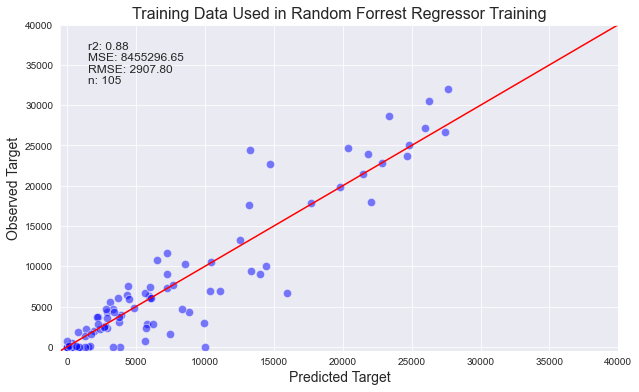

saved to:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\rfr_all_data_w_met_sddv3_h99_rfr_r2_0_train.JPG


In [78]:
plt.figure(figsize=(10, 6))
feature_importance = tree_model.feature_importances_

### TRY THIS
# use "feature importance" scores to see what the top 10 important features are
fi = enumerate(tree_model.feature_importances_)
cols = xdata1.columns
fiResult = [(value,cols[i]) for (i,value) in fi]

r2 = round(tree_model.score(x_train, y_train),2)
mse = round(np.mean((y_train - tree_model.predict(x_train))**2), 2)
rmse = round(np.sqrt(np.mean((y_train - tree_model.predict(x_train))**2)), 2)
              

plt.scatter(tree_model.predict(x_train), y_train, s= 70, alpha=0.5, color='blue', edgecolors='w')  
# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500,40000)
plt.ylim(-500, 40000)

plt.plot(x, y, color='red')#, linestyle='dashed', linewidth=2)

# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'Training Data Used in {model_name} Training', fontsize=16)

# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nn: {len(y_train)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)

out = os.path.join(output, "{0}_{1}_{2}_{3}_train.JPG".format(var_, mdl, fac, str(rs)))
#print(out)                   
plt.savefig(out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()

print("saved to: ", out)

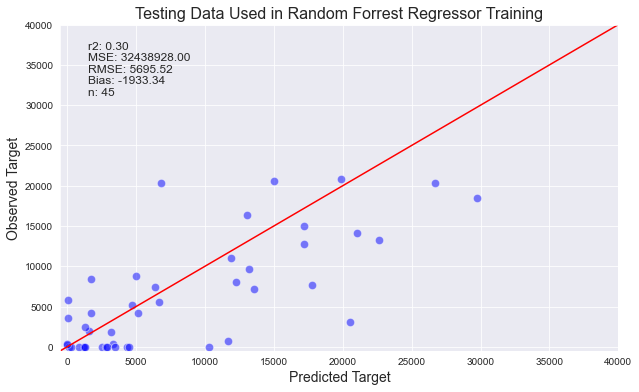

Plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\rfr_all_data_w_met_sddv3_h99_rfr_r2_0_test_data.JPG


In [79]:
plt.figure(figsize=(10, 6))
y2_predict = tree_model.predict(x_test)

r2 = round(tree_model.score(x_test, y_test),2)
mse = round(np.mean((y_test - tree_model.predict(x_test))** 2), 2)
rmse = round(np.sqrt(np.mean((y2_predict - y_test) ** 2)), 2)
bias = round(np.mean(y_test) - np.mean(y2_predict), 2)
var = round(explained_variance_score(y_test, y2_predict), 2)

plt.scatter(y2_predict, y_test, s= 70, alpha=0.5, color='blue', edgecolors='w')# ,s=10, c='b', marker='o')
# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500,40000)
plt.ylim(-500, 40000)
# plt.ylabel('Observed AGB')
# plt.xlabel('Predicted AGB')
# plt.title(f'Testing data: {mdl}')
# 1 for 1 line
plt.plot(x, y, color = 'r')



# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'Testing Data Used in {model_name} Training', fontsize=16)

# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nBias: {bias:.2f}\nn: {len(y_test)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)

# Explained variance is R2
out_plot = os.path.join(output, "{0}_{1}_{2}_{3}_test_data.JPG".format(var_, mdl, fac, str(rs)))
# Save the plot
plt.savefig(out_plot, dpi=300)
plt.show()
print("Plot: ", out_plot)

In [80]:
# Generate feature importance and related data
fi = enumerate(feature_importance)
cols = xdata1.columns
fiResult = np.array([(value, cols[i]) for (i, value) in fi])

score = fiResult[:, 0].astype(float)
score_4 = np.around(score, decimals=4)
band = fiResult[:, 1]

df_band = pd.DataFrame(dict(band=band, n=score_4))
df_band['n'] = df_band['n'].astype(float)
dfsort = df_band.sort_values(['n'], ascending=[False]).head(20)  # Select top 20 features

ind = np.arange(len(dfsort))
width = 0.4

# Increase figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot
ax.barh(ind, dfsort['n'], width, color='blue')

# Adjust y-tick labels
wrapped_labels = [textwrap.fill(label, 10) for label in dfsort['band']]
ax.set(yticks=ind, yticklabels=wrapped_labels, ylim=[-1, len(dfsort)])
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title(f'Top 20 Feature Importance ({model_name})', fontsize=14)

# Reverse the order of y-axis to display highest to lowest
ax.invert_yaxis()

# Adjust layout
plt.tight_layout()

out = os.path.join(output, f"{var_}_{fac}_{mdl}_Top20_Feature_Importance_Score.JPG")
plt.savefig(out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()
print(out)

C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\rfr_all_data_w_met_sddv3_h99_r2_rfr_Top20_Feature_Importance_Score.JPG


In [81]:
plt.figure(figsize=(12, 8))
fiResult = np.array(fiResult)
score = (fiResult[:,0])
arr_unicode =score
# Convert Unicode strings to float values
arr_float = arr_unicode.astype(np.float)

# Round float values to two decimal places
score_4 = np.around(arr_float, decimals=4)

band = fiResult[:,1]
a = fiResult[np.argsort(fiResult[:, 1])]

df_band = pd.DataFrame(dict(band=band,n=score_4))
df_band['n'].astype('float')
dfsort = df_band.sort_values(['n'], ascending=[False])
print(dfsort)
 
# ## my complicated way to get the bar plot to sort in ascending order and display the assocated band names in the y axis
# dfsort2 = df_band.sort_values(['n'], ascending=[True])
# b = dfsort2[['band']]
# c = b.values.tolist()
# # convert the list of band names in the correct order to a string
# e = str(c)
# # strips all the rubbish from the string
# f = e.replace('[','').replace(']','').replace("'",'').replace(",",' ')
# # convert the cleaned up string back into a list to plot the band names in the bar graph
# g = f.split()
#
# ind = np.arange(len(df_band))
# width = 0.4
# print("ind: ", ind)
# fig, ax = plt.subplots()
# ax.barh(ind, dfsort2.n, width, color='blue')
# ax.set(yticks=ind + width, yticklabels= g, ylim=[2*width - 1, len(df_band)])
# ax.set_xlabel('Performance') #, rotation=45)
# ax.set_ylabel('Ranked variables') #, rotation=45)
# plt.xticks(rotation='vertical')
# ax.set_title('Variable Importance Rank')
#
# # Adjust layout
# plt.tight_layout()
#
#
# out = os.path.join(output, "{0}_{1}_{2}_Band_Importance_Score.JPG".format(var_, fac, mdl))
# plt.savefig(out, dpi=300)  # dpi sets the resolution in dots per inch
# plt.show()
# print(out)

                       band    n
22             dbifmdry_r64 0.25
11         b3_dbifm_dry_p99 0.11
9          b1_dbifm_dry_p99 0.11
23             dbifmdry_r65 0.11
7          b2_dp1fm_dry_p99 0.06
2                b1_hmc_p99 0.05
4                b1_h99_p99 0.04
33            dbifmdry_NDVI 0.03
32           dbifmdry_MSAVI 0.03
17             dbifmdry_r52 0.02
26             dbifmdry_CVI 0.02
15             dbifmdry_r42 0.02
10         b2_dbifm_dry_p99 0.02
6          b1_dp1fm_dry_p99 0.02
12         b4_dbifm_dry_p99 0.02
34             dbifmdry_MSR 0.01
19             dbifmdry_r54 0.01
16             dbifmdry_r43 0.01
20             dbifmdry_r62 0.01
24           dbifmdry_GSAVI 0.01
50    b1_fdc_dry_major_en_3 0.01
0            b1_wfp_dry_p99 0.01
18             dbifmdry_r53 0.01
31            dbifmdry_GDVI 0.00
21             dbifmdry_r63 0.00
41    b1_n17_dry_major_en_4 0.00
1                b1_hsd_p99 0.00
28              dbifmdry_RI 0.00
3                b1_hcv_p99 0.00
27        

<Figure size 864x576 with 0 Axes>

### Predict the selected model on the test data

In [82]:
dfsort.shape

(51, 2)

In [83]:
df_band.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    51 non-null     object 
 1   n       51 non-null     float64
dtypes: float64(1), object(1)
memory usage: 944.0+ bytes


In [84]:
dfsort['n'].astype('float')
dfsort.info()
dfsort['n'] = dfsort['n'].astype('float')
dfsort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 22 to 48
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    51 non-null     object 
 1   n       51 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 22 to 48
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    51 non-null     object 
 1   n       51 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [85]:
#Plot has value at the top with very small n value 

In [86]:
#Plot has value at the top with very small n value

sel_num = 20
df_var = dfsort.head(sel_num)

In [87]:
#df_var = dfsort[dfsort['n'] > 0.01]

In [88]:
column_var = df_var.band.tolist()

In [89]:
#column_var.insert(0, 'target')

In [90]:
column_var

['dbifmdry_r64',
 'b3_dbifm_dry_p99',
 'b1_dbifm_dry_p99',
 'dbifmdry_r65',
 'b2_dp1fm_dry_p99',
 'b1_hmc_p99',
 'b1_h99_p99',
 'dbifmdry_NDVI',
 'dbifmdry_MSAVI',
 'dbifmdry_r52',
 'dbifmdry_CVI',
 'dbifmdry_r42',
 'b2_dbifm_dry_p99',
 'b1_dp1fm_dry_p99',
 'b4_dbifm_dry_p99',
 'dbifmdry_MSR',
 'dbifmdry_r54',
 'dbifmdry_r43',
 'dbifmdry_r62',
 'dbifmdry_GSAVI']

In [91]:
df_ml

target  b1_wfp_dry_p99  b1_hsd_p99  b1_hmc_p99  b1_hcv_p99  b1_h99_p99  \
0       0.00           76.92      102.93      107.14      146.72      112.12   
1       0.00            7.94      102.32      103.73      164.02      109.06   
2       0.00            8.92      101.20      105.23      145.50      108.65   
3       0.00            8.86      102.40      104.98      158.27      108.72   
4       0.00            1.99      101.27      102.39      151.96      105.96   
..       ...             ...         ...         ...         ...         ...   
195 14082.44           45.56      104.98      109.88      167.16      117.99   
196  8768.69           35.25      103.93      106.53      175.39      113.95   
197  9381.75           43.00      106.05      109.38      176.98      120.17   
198  4210.68           30.56      104.29      106.03      186.18      114.11   
199   720.72           57.00      103.56      106.31      161.43      112.28   

     b1_ccw_dry_p99  b1_dp1fm_dry_p99  b2_dp1fm_dry_p99  b3_dp1fm_dry_p99  \
0             93.00             12.00             70.92             33.76   
1              1.00              4.00              1.00             94.00   
2             15.84              2.92             16.92             84.92   
3             15.76              1.00             16.84             91.84   
4              3.97              5.00              7.92             93.92   
..              ...               ...               ...               ...   
195           67.45              3.89             50.78             54.00   
196           55.25             18.25             40.70             67.55   
197           65.00              1.00             43.00             59.89   
198           50.34             28.89             34.67             55.67   
199           79.00             21.84             46.92             42.76   

     ...  b1_n17_dry_major_en_4  b1_n17_dry_major_en_5  b1_n17_dry_major_en_6  \
0    ...                      0                      0                      0   
1    ...                      0                      0                      0   
2    ...                      0                      0                      0   
3    ...                      0                      0                      0   
4    ...                      0                      0                      0   
..   ...                    ...                    ...                    ...   
195  ...                      0                      0                      0   
196  ...                      0                      0                      0   
197  ...                      0                      0                      0   
198  ...                      0                      0                      0   
199  ...                      0                      0                      0   

     b1_n17_dry_major_en_7  b1_n17_dry_major_en_8  b1_n17_dry_major_en_10  \
0                        0                      0                       0   
1                        0                      0                       0   
2                        0                      0                       0   
3                        0                      0                       0   
4                        0                      0                       0   
..                     ...                    ...                     ...   
195                      0                      1                       0   
196                      0                      1                       0   
197                      0                      0                       0   
198                      0                      1                       0   
199                      0                      1                       0   

     b1_n17_dry_major_en_11  b1_fdc_dry_major_en_1  b1_fdc_dry_major_en_2  \
0                         0                      0                      0   
1                         0                      1                  

In [92]:
select_df = df_ml[column_var]

In [93]:
df_corr = select_df.corr()
df_corr

dbifmdry_r64  b3_dbifm_dry_p99  b1_dbifm_dry_p99  \
dbifmdry_r64              1.00              0.54              0.55   
b3_dbifm_dry_p99          0.54              1.00              0.90   
b1_dbifm_dry_p99          0.55              0.90              1.00   
dbifmdry_r65              0.87              0.60              0.57   
b2_dp1fm_dry_p99         -0.69             -0.79             -0.76   
b1_hmc_p99               -0.72             -0.72             -0.72   
b1_h99_p99               -0.66             -0.75             -0.77   
dbifmdry_NDVI            -0.81             -0.87             -0.84   
dbifmdry_MSAVI           -0.88             -0.64             -0.67   
dbifmdry_r52             -0.15             -0.65             -0.72   
dbifmdry_CVI             -0.71             -0.63             -0.78   
dbifmdry_r42             -0.81             -0.78             -0.83   
b2_dbifm_dry_p99          0.53              0.97              0.95   
b1_dp1fm_dry_p99          0.53              0.47              0.44   
b4_dbifm_dry_p99         -0.17              0.64              0.50   
dbifmdry_MSR             -0.81             -0.84             -0.81   
dbifmdry_r54              0.92              0.41              0.43   
dbifmdry_r43             -0.81             -0.82             -0.79   
dbifmdry_r62              0.58             -0.15             -0.25   
dbifmdry_GSAVI           -0.81             -0.34             -0.49   

                  dbifmdry_r65  b2_dp1fm_dry_p99  b1_hmc_p99  b1_h99_p99  \
dbifmdry_r64              0.87             -0.69       -0.72       -0.66   
b3_dbifm_dry_p99          0.60             -0.79       -0.72       -0.75   
b1_dbifm_dry_p99          0.57             -0.76       -0.72       -0.77   
dbifmdry_r65              1.00             -0.57       -0.58       -0.54   
b2_dp1fm_dry_p99         -0.57              1.00        0.80        0.78   
b1_hmc_p99               -0.58              0.80        1.00        0.95   
b1_h99_p99               -0.54              0.78        0.95        1.00   
dbifmdry_NDVI            -0.77              0.91        0.84        0.82   
dbifmdry_MSAVI           -0.80              0.83        0.78        0.72   
dbifmdry_r52             -0.43              0.43        0.36        0.43   
dbifmdry_CVI             -0.70              0.67        0.74        0.74   
dbifmdry_r42             -0.78              0.83        0.84        0.82   
b2_dbifm_dry_p99          0.59             -0.76       -0.72       -0.77   
b1_dp1fm_dry_p99          0.82             -0.31       -0.30       -0.29   
b4_dbifm_dry_p99         -0.02             -0.20       -0.15       -0.26   
dbifmdry_MSR             -0.77              0.89        0.84        0.82   
dbifmdry_r54              0.61             -0.68       -0.72       -0.65   
dbifmdry_r43             -0.76              0.87        0.84        0.80   
dbifmdry_r62              0.40             -0.04       -0.13       -0.03   
dbifmdry_GSAVI           -0.70              0.62        0.63        0.57   

                  dbifmdry_NDVI  dbifmdry_MSAVI  dbifmdry_r52  dbifmdry_CVI  \
dbifmdry_r64              -0.81           -0.88         -0.15         -0.71   
b3_dbifm_dry_p99          -0.87           -0.64         -0.65         -0.63   
b1_dbifm_dry_p99          -0.84           -0.67         -0.72         -0.78   
dbifmdry_r65              -0.77           -0.80         -0.43         -0.70   
b2_dp1fm_dry_p99           0.91            0.83          0.43          0.67   
b1_hmc_p99                 0.84            0.78          0.36          0.74   
b1_h99_p99                 0.82            0.72          0.43          0.74   
dbifmdry_NDVI              1.00            0.91          0.56          0.81   
dbifmdry_MSAVI             0.91            1.00          0.39          0.83   
dbifmdry_r52               0.56            0.39          1.00          0.67   
dbifmdry_CVI               0.81            0.83          0.67          1.00   
db

In [94]:
dfsort.to_csv(os.path.join(output, "{0}_{1}_{2}_variable_score.csv".format(var_, fac, mdl)))
df_corr.to_csv(os.path.join(output, "{0}_{1}_{2}_select_variable_correlation.csv".format(var_, fac, mdl)))

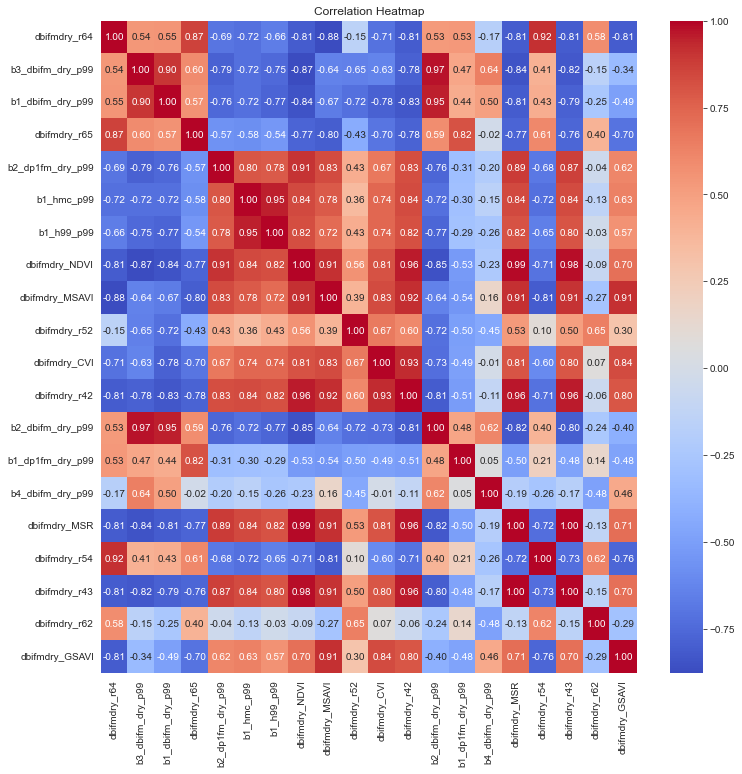

Plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\rfr_all_data_w_met_sddv3_h99_r2_rfr_variable_score.JPG


In [95]:
# Create heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

# Save the plot
plot_out = os.path.join(output, "{0}_{1}_{2}_variable_score.JPG".format(var_, fac, mdl))
plt.savefig(plot_out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()
print("Plot: ", plot_out)

In [96]:
select_df

dbifmdry_r64  b3_dbifm_dry_p99  b1_dbifm_dry_p99  dbifmdry_r65  \
0         6618435           1082.64            476.48       6275600   
1         6783234           1766.16            659.24       5935863   
2         5164148           1487.48            529.92       5592623   
3         5816502           1486.64            503.48       5474908   
4         6320327           1856.76            705.72       5684941   
..            ...               ...               ...           ...   
195       4331245            703.02            319.78       4967641   
196       7799970            712.00            408.80       6034711   
197       5101924            736.69            270.56       5012618   
198      11024508            829.72            436.23       8121257   
199       7116275            525.84            362.84       6511940   

     b2_dp1fm_dry_p99  b1_hmc_p99  b1_h99_p99  dbifmdry_NDVI  dbifmdry_MSAVI  \
0               70.92      107.14      112.12        4812940         2729666   
1                1.00      103.73      109.06        2424107         1549615   
2               16.92      105.23      108.65        3718750         2429125   
3               16.84      104.98      108.72        3334969         2027352   
4                7.92      102.39      105.96        2593228         1708085   
..                ...         ...         ...            ...             ...   
195             50.78      109.88      117.99        5492041         2598547   
196             40.70      106.53      113.95        4345595         1751319   
197             43.00      109.38      120.17        5123936         2362340   
198             34.67      106.03      114.11        3511706         1272075   
199             46.92      106.31      112.28        4858028         1680773   

     dbifmdry_r52  dbifmdry_CVI  dbifmdry_r42  b2_dbifm_dry_p99  \
0        36533684      42029536      34641239            870.88   
1        28654655      38330907      25075075           1151.76   
2        30501612      49990878      33032366            975.28   
3        33649314      50120435      31673142            959.64   
4        26650956      33831663      23971721           1343.48   
..            ...           ...           ...               ...   
195      37750632      54657632      43297388            545.67   
196      43834197      45423503      33913813            593.95   
197      45731819      65351356      44931306            498.68   
198      34161601      30398108      25165308            636.13   
199      34496710      34615240      31567146            520.64   

     b1_dp1fm_dry_p99  b4_dbifm_dry_p99  dbifmdry_MSR  dbifmdry_r54  \
0               12.00           2893.36       6898960      10546298   
1                4.00           2873.16       2806064      11427545   
2                2.92           3142.80       4778632       9233856   
3                1.00           2813.72       4144739      10623927   
4                5.00           3011.92       3039292      11117665   
..                ...               ...           ...           ...   
195              3.89           2200.15       8538061       8718917   
196             18.25           1796.65       5928167      12925175   
197              1.00           2113.92       7611556      10178164   
198             28.89           1582.81       4430780      13574879   
199             21.84           1587.48       6998701      10928042   

     dbifmdry_r43  dbifmdry_r62  dbifmdry_GSAVI  
0        28549922      22927079         3347432  
1        16401493      17009009         2821882  
2        21831242      17058402         3570477  
3        20009818      18422688         3251895  
4        16999614      15150911         2804213  
..            ...           ...             ...  
195      34358872      18753159         3235756  
196      25374433      26452673         2474550  
197      30977520      22923612         3180848  
198      20811672      27743514  

# Rerun on Selected data

In [97]:
x_train, x_test, y_train, y_test, x_validation, y_validation

(     b1_wfp_dry_p99  b1_hsd_p99  b1_hmc_p99  b1_hcv_p99  b1_h99_p99  \
 41            60.44      105.90      109.71      161.68      119.33   
 6              7.00      102.25      103.54      162.18      108.73   
 142           48.78      103.66      106.45      160.17      113.12   
 90            20.00      102.37      103.50      158.16      108.68   
 84            57.00      104.81      109.07      157.88      116.78   
 ..              ...         ...         ...         ...         ...   
 7              5.92      101.04      101.76      154.42      104.71   
 23            23.68      102.71      105.35      160.87      109.98   
 102            1.00      101.26      102.14      137.96      105.20   
 72            47.00      102.26      104.18      152.82      109.18   
 107            1.00      102.52      104.65      155.22      110.55   
 
      b1_ccw_dry_p99  b1_dp1fm_dry_p99  b2_dp1fm_dry_p99  b3_dp1fm_dry_p99  \
 41            81.60              1.92             50.92

In [98]:
sel_x_train = x_train[column_var]
sel_x_test = x_test[column_var]
sel_x_validation = x_validation[column_var]
sel_y_train = y_train
sel_y_test = y_test
sel_y_validation = y_validation

In [99]:
# xdata = select_df.iloc[:, 1:].astype('float32')
# ydata1 = select_df[[value_x]].astype('float32')
# ydata2 = ydata1.values
# ydata = ydata2.ravel()
#
# X_1, sel_x_test, sel_y_train, sel_y_test = train_test_split(xdata, ydata, train_size=0.70)
#
# print(sel_x_train.shape, sel_y_train.shape)
# print(sel_x_test.shape, sel_y_test.shape)

In [100]:
#select_df

# Set model with feature names for Notebook testing

In [101]:
select_tree_model = best_model.fit(sel_x_train, sel_y_train)

## Re-train model on selected paramiters

Fitted model r2 = 0.89
Fitted model mse = 7794004.38
n = 105


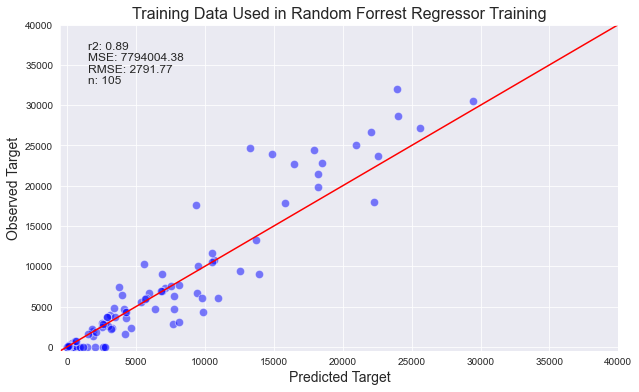

Plot:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\rfr_all_data_w_met_sddv3_h99_r2_rfr_sel20_train.JPG


In [102]:

plt.figure(figsize=(10, 6))
feature_importance = best_model.feature_importances_

### TRY THIS
# use "feature importance" scores to see what the top 10 important features are
fi = enumerate(best_model.feature_importances_)
cols = xdata1.columns
fiResult = [(value,cols[i]) for (i,value) in fi]
#fiResult = [(value,cols[i]) for (i,value) in fi if value > 0.001]
## Change the value 0.04 which we picked empirically to give us 10 variables
## try running this code after changing the value up and down so you get more or less variables
## do you see how this might be useful in refining the model?
## Here is the code in case you mess up the line above
## [(value,cols[i]) for (i,value) in fi if value > 0.04]
#print fiResult

print('Fitted model r2 =' ,  format(select_tree_model.score(sel_x_train, sel_y_train), '.2f'))
print('Fitted model mse =', format(np.mean((sel_y_train - select_tree_model.predict(sel_x_train))**2), '.2f'))
print('n =', len(sel_y_train))

r2 = round(select_tree_model.score(sel_x_train, sel_y_train),2)
mse = round(np.mean((sel_y_train - select_tree_model.predict(sel_x_train))** 2), 2)
rmse = round(np.sqrt(np.mean((sel_y_train - select_tree_model.predict(sel_x_train))** 2)), 2)
#bias = round(np.mean(sel_y_test) - np.mean(y2_predict), 2)


plt.scatter(select_tree_model.predict(sel_x_train), sel_y_train, s= 70, alpha=0.5, color='blue', edgecolors='w')
# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500,40000)
plt.ylim(-500,40000)


# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'Training Data Used in {model_name} Training', fontsize=16)

# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nn: {len(sel_y_train)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)


# 1 for 1 line

plt.plot(x, y, color = 'r')

plt_out = os.path.join(output, "{0}_{1}_{2}_sel{3}_train.JPG".format(var_, fac, mdl, sel_num))
plt.savefig(plt_out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()
print("Plot: ", plt_out)


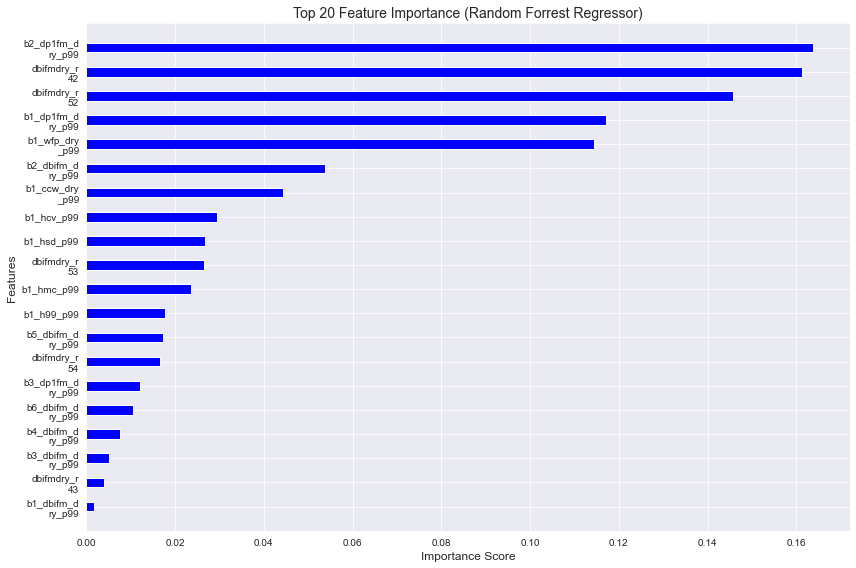

C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\rfr_all_data_w_met_sddv3_h99_r2_rfr_select_20_Band_Importance_Score.JPG


In [103]:
# Generate feature importance and related data
fi = enumerate(feature_importance)
cols = xdata1.columns
fiResult = np.array([(value, cols[i]) for (i, value) in fi])

score = fiResult[:, 0].astype(float)
score_4 = np.around(score, decimals=4)
band = fiResult[:, 1]

df_band = pd.DataFrame(dict(band=band, n=score_4))
df_band['n'] = df_band['n'].astype(float)
dfsort = df_band.sort_values(['n'], ascending=[False]).head(20)  # Select top 20 features

ind = np.arange(len(dfsort))
width = 0.4

# Increase figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot
ax.barh(ind, dfsort['n'], width, color='blue')

# Adjust y-tick labels
wrapped_labels = [textwrap.fill(label, 10) for label in dfsort['band']]
ax.set(yticks=ind, yticklabels=wrapped_labels, ylim=[-1, len(dfsort)])
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title(f'Top {str(sel_num)} Feature Importance ({model_name})', fontsize=14)

# Reverse the order of y-axis to display highest to lowest
ax.invert_yaxis()

# Adjust layout
plt.tight_layout()

out = os.path.join(output, "{0}_{1}_{2}_select_{3}_Band_Importance_Score.JPG".format(var_, fac, mdl, str(sel_num)))
plt.savefig(out, dpi=300)  # dpi sets the resolution in dots per inch
plt.show()
print(out)

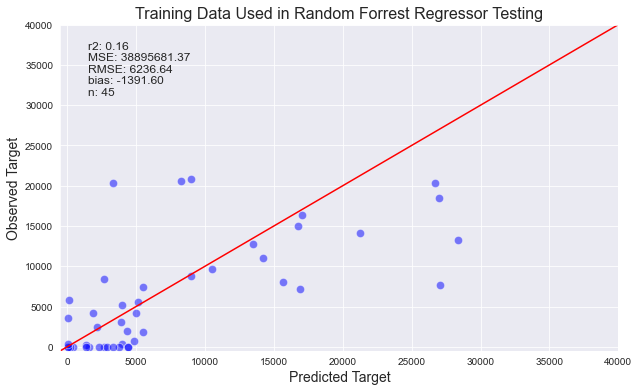

In [104]:
plt.figure(figsize=(10, 6))
y2_predict = select_tree_model.predict(sel_x_test)

r2 = round(select_tree_model.score(sel_x_test, sel_y_test),2)
mse = round(np.mean((sel_y_test - select_tree_model.predict(sel_x_test))** 2), 2)
rmse = round(np.sqrt(np.mean((y2_predict - sel_y_test) ** 2)), 2)
bias = round(np.mean(sel_y_test) - np.mean(y2_predict), 2)
var = round(explained_variance_score(sel_y_test, y2_predict), 2)

plt.scatter(y2_predict, sel_y_test, s= 70, alpha=0.5, color='blue', edgecolors='w')
# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500,40000)
plt.ylim(-500, 40000)
# plt.ylabel('Observed mean AGB')
# plt.xlabel('Predicted mean AGB')
# plt.title(f'Testing selected {str(sel_num)} data: {var_} - {mdl}')
# # 1 for 1 line
plt.plot(x, y, color = 'r')

# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'Training Data Used in {model_name} Testing', fontsize=16)

# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nbias: {bias:.2f}\nn: {len(sel_y_test)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)




# Save the plot
plt.savefig(os.path.join(output, "{0}_{1}_{2}_sel{3}_test.pdf".format(var_, fac, mdl, sel_num)), dpi=300)  # dpi sets the resolution in dots per inch
plt.show()

In [105]:
variable_imp_list = dfsort.band.to_list()
print(variable_imp_list)

['b2_dp1fm_dry_p99', 'dbifmdry_r42', 'dbifmdry_r52', 'b1_dp1fm_dry_p99', 'b1_wfp_dry_p99', 'b2_dbifm_dry_p99', 'b1_ccw_dry_p99', 'b1_hcv_p99', 'b1_hsd_p99', 'dbifmdry_r53', 'b1_hmc_p99', 'b1_h99_p99', 'b5_dbifm_dry_p99', 'dbifmdry_r54', 'b3_dp1fm_dry_p99', 'b6_dbifm_dry_p99', 'b4_dbifm_dry_p99', 'b3_dbifm_dry_p99', 'dbifmdry_r43', 'b1_dbifm_dry_p99']


# =================================================================

# STOP - do you realy want to save this model?

# remember to change the cPickle file name !!

# Save current fitted model and apply to validation validation data

In [106]:
select_tree_model

RandomForestRegressor(max_features='sqrt', n_estimators=5)

In [107]:
import pickle

#rfrL8CHM = rfr()
#rfrL8CHM.fit(sel_x_train, sel_y_train)
pickle_file = os.path.join(output, "{0}_{1}_{2}_sel_{3}_{4}_model.pickle".format(var_, fac, mdl, sel_num, samp))
with open(pickle_file, 'wb') as f:
    pickle.dump(select_tree_model, f)
print("pickle saved: ", pickle_file)

pickle saved:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\rfr_all_data_w_met_sddv3_h99_r2_rfr_sel_20_all_data_model.pickle


In [108]:
# read in your validation dataset which has never been seen by rfr model - NOTE in this example I am just reading the same data used to train the model
sel_y_validation
sel_x_validation
#validation_data

dbifmdry_r64  b3_dbifm_dry_p99  b1_dbifm_dry_p99  dbifmdry_r65  \
121    7423888.00           1236.12            544.84    5656123.00   
31     8569404.00           1374.70            457.01    6120045.00   
166    3758507.00            666.59            341.61    5141141.00   
136    5593309.00            843.14            328.79    5559632.00   
181    5986832.00            726.86            349.82    6450943.00   
32     7260303.00           1367.36            534.00    5917738.00   
152    7184238.00           1333.52            556.80    6881142.00   
169    7849458.00            980.76            473.67    6974121.00   
157   10430358.00           1088.94            393.15    7961334.00   
29     5493378.00           1221.76            491.20    5604254.00   
105    7231518.00           1738.72            659.64    6044303.00   
88     9487026.00           1777.02            777.34    7462320.00   
85     7770380.00           1387.62            528.12    7301587.00   
122    7323698.00           1170.04            585.68    5501475.00   
158   10208190.00           1140.52            422.64    7722729.00   
194    6906924.00            661.50            297.20    5272964.00   
77     9330267.00            964.00            358.60    6673832.00   
83     6719120.00            840.74            413.78    6223163.00   
25     7961088.00            923.80            462.24    6242258.00   
177    4551095.00            667.76            353.36    4978247.00   
87     9749392.00           1639.48            480.80    8856856.00   
189    6612135.00            596.40            238.52    5323373.00   
191    4755697.00            639.12            374.12    5280892.00   
40     8466153.00           1155.40            510.55    6512441.00   
62     8522962.00           1367.59            672.46    6372011.00   
150    4596979.00            795.84            363.24    5381066.00   
94     6204648.00           1683.16            663.92    5807285.00   
75     4628797.00            726.20            349.70    5035942.00   
93     7405501.00           1685.30            778.95    6758119.00   
37     8633871.00           1119.13            424.90    6639194.00   
21    10508063.00           1312.88            652.93    7008835.00   
9      9476993.00           1261.47            488.90    6856452.00   
109   10832146.00           1672.12            744.48    7397621.00   
71     6508295.00            564.45            246.25    5720066.00   
124   11354213.00           1830.67            848.12    7643816.00   
49     6942586.00            795.80            304.68    6101738.00   
184   10066061.00           1063.48            544.16    7819680.00   

     b2_dp1fm_dry_p99  b1_hmc_p99  b1_h99_p99  dbifmdry_NDVI  dbifmdry_MSAVI  \
121              9.84      104.28      109.37     2791909.00      1429654.00   
31              20.89      105.38      109.55     3347097.00      1963954.00   
166             49.99      113.22      121.18     5579884.00      2767595.00   
136             43.78      109.56      117.88     4767153.00      2253730.00   
181             47.94      111.15      119.08     4885222.00      2298430.00   
32              38.92      105.75      110.41     3383992.00      2013487.00   
152             38.92      107.66      113.40     3700573.00      2099963.00   
169             32.67      109.68      117.56     3461818.00      1569315.00   
157             33.78      107.51      113.56     3261956.00      1495896.00   
29              36.92      107.22      114.92     4163627.00      2463714.00   
105              0.92      103.57      107.85     2341020.00      1451646.00   
88               7.89      104.37      109.25     2094409.00      1308572.00   
85              32.78      103.38      108.55     2964187.00      1648036.00   
122             16.00      104.73      110.08     2953895.00      1474683.00   
158             36.92      106.95      113.52     3328758.00      1576242.00   
194             44.88     

In [109]:
c_list = sel_x_validation.columns.tolist()
c_list

['dbifmdry_r64',
 'b3_dbifm_dry_p99',
 'b1_dbifm_dry_p99',
 'dbifmdry_r65',
 'b2_dp1fm_dry_p99',
 'b1_hmc_p99',
 'b1_h99_p99',
 'dbifmdry_NDVI',
 'dbifmdry_MSAVI',
 'dbifmdry_r52',
 'dbifmdry_CVI',
 'dbifmdry_r42',
 'b2_dbifm_dry_p99',
 'b1_dp1fm_dry_p99',
 'b4_dbifm_dry_p99',
 'dbifmdry_MSR',
 'dbifmdry_r54',
 'dbifmdry_r43',
 'dbifmdry_r62',
 'dbifmdry_GSAVI']

In [110]:
validation_df = sel_x_validation

In [111]:
# Insert array as the first column
validation_df.insert(0, 'target', sel_y_validation)

In [112]:
validation_out = os.path.join(output, "validation_data.csv")
validation_df.to_csv(validation_out, index=False)

In [113]:
#select_validation_df = validation_df[column_var]

In [114]:
validation_df.columns

Index(['target', 'dbifmdry_r64', 'b3_dbifm_dry_p99', 'b1_dbifm_dry_p99',
       'dbifmdry_r65', 'b2_dp1fm_dry_p99', 'b1_hmc_p99', 'b1_h99_p99',
       'dbifmdry_NDVI', 'dbifmdry_MSAVI', 'dbifmdry_r52', 'dbifmdry_CVI',
       'dbifmdry_r42', 'b2_dbifm_dry_p99', 'b1_dp1fm_dry_p99',
       'b4_dbifm_dry_p99', 'dbifmdry_MSR', 'dbifmdry_r54', 'dbifmdry_r43',
       'dbifmdry_r62', 'dbifmdry_GSAVI'],
      dtype='object')

In [115]:
column_var

['dbifmdry_r64',
 'b3_dbifm_dry_p99',
 'b1_dbifm_dry_p99',
 'dbifmdry_r65',
 'b2_dp1fm_dry_p99',
 'b1_hmc_p99',
 'b1_h99_p99',
 'dbifmdry_NDVI',
 'dbifmdry_MSAVI',
 'dbifmdry_r52',
 'dbifmdry_CVI',
 'dbifmdry_r42',
 'b2_dbifm_dry_p99',
 'b1_dp1fm_dry_p99',
 'b4_dbifm_dry_p99',
 'dbifmdry_MSR',
 'dbifmdry_r54',
 'dbifmdry_r43',
 'dbifmdry_r62',
 'dbifmdry_GSAVI']

In [116]:
validation_xdata = validation_df.iloc[:, 1:].astype('float32')
ydata1 = validation_df[[value_x]].astype('float32')
ydata2 = ydata1.values
ydata3 = ydata2.ravel()

validation_ydata = ydata3.reshape(-1, 1)

In [117]:
validation_xdata.shape

(37, 20)

In [118]:
validation_ydata.shape

(37, 1)

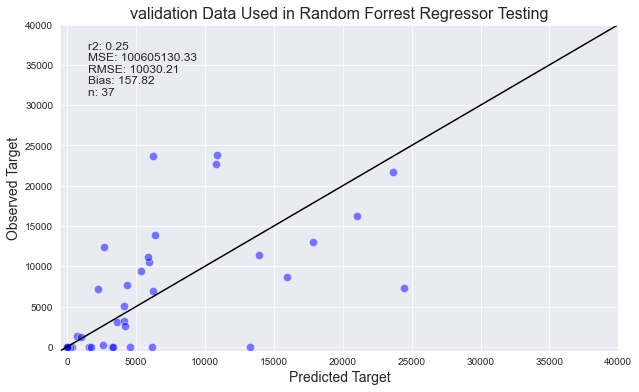

plot output:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\rfr_all_data_w_met_sddv3_h99_r2_rfr_sel_20_data.JPG
Using:  rfr_all_data_w_met_sddv3_h99_r2_rfr_sel_20_model.pickle


In [119]:
plt.figure(figsize=(10, 6))
with open(pickle_file, 'rb') as f:
        rf = pickle.load(f)

        predicted = rf.predict(validation_xdata)


r2 = round(rf.score(validation_xdata, validation_ydata),2)
mse = round(np.mean((validation_ydata - rf.predict(validation_xdata))** 2), 2)
rmse = round(np.sqrt(np.mean((predicted - validation_ydata) ** 2)), 2)
bias = round(np.mean(validation_ydata) - np.mean(predicted), 2)
var = round(explained_variance_score(validation_ydata, predicted), 2)


# plot up predicted and observed data 
plt.scatter(predicted, validation_ydata, s= 70, alpha=0.5, color='blue', edgecolors='w') #,s=8, c='b', marker='o')

# data for the 1 for 1 line
x = [-500,40000]
y = [-500,40000]

#sets the limits of the axis
plt.xlim(-500, 40000)
plt.ylim(-500, 40000)

# # Add text to the plot
# plt.text(500, 28000, f'r2: {r2}', fontsize=10, color='black')
# plt.text(500, 26500, f'MSE: {mse}', fontsize=10, color='black')
# plt.text(500, 25000, f'RMSE: {rmse}', fontsize=10, color='black')
# plt.text(500, 23500, f'Bias: {bias}', fontsize=10, color='black')
# plt.text(500, 22000, f'Exp var: {var}', fontsize=10, color='black')
# plt.text(500, 20500, f'n: {len(sel_y_train)}', fontsize=10, color='black')


# Add labels and title
plt.ylabel('Observed Target', fontsize=14)
plt.xlabel('Predicted Target', fontsize=14)
plt.title(f'validation Data Used in {model_name} Testing', fontsize=16)


# Annotate the stats in the top left corner
plt.text(0.05, 0.95, f'r2: {r2:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nBias: {bias:.2f}\nn: {len(validation_ydata)}',
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)


# 1 for 1 line

fig = plt.figure(1)
plt.plot(x, y, color = 'black')
output_plot = os.path.join(output, "{0}_{1}_{2}_sel_{3}_data.JPG".format(var_, fac, mdl, str(sel_num)))
fig.savefig(output_plot,dpi=600)
plt.show()
print("plot output: ", output_plot)
print("Using: ", "{0}_{1}_{2}_sel_{3}_model.pickle".format(var_, fac, mdl, sel_num))

In [120]:
# Load the pickled model
import pickle

with open(pickle_file, 'rb') as file:
    model = pickle.load(file)

# Load the dataset
import pandas as pd

# validation x data
data = validation_xdata

# Check the feature names used during training
training_feature_names = model.feature_names_in_

# Check the feature names in the new dataset
new_feature_names = data.columns

print("Training feature names:", training_feature_names)
print("New feature names:", new_feature_names)

Training feature names: ['dbifmdry_r64' 'b3_dbifm_dry_p99' 'b1_dbifm_dry_p99' 'dbifmdry_r65'
 'b2_dp1fm_dry_p99' 'b1_hmc_p99' 'b1_h99_p99' 'dbifmdry_NDVI'
 'dbifmdry_MSAVI' 'dbifmdry_r52' 'dbifmdry_CVI' 'dbifmdry_r42'
 'b2_dbifm_dry_p99' 'b1_dp1fm_dry_p99' 'b4_dbifm_dry_p99' 'dbifmdry_MSR'
 'dbifmdry_r54' 'dbifmdry_r43' 'dbifmdry_r62' 'dbifmdry_GSAVI']
New feature names: Index(['dbifmdry_r64', 'b3_dbifm_dry_p99', 'b1_dbifm_dry_p99', 'dbifmdry_r65',
       'b2_dp1fm_dry_p99', 'b1_hmc_p99', 'b1_h99_p99', 'dbifmdry_NDVI',
       'dbifmdry_MSAVI', 'dbifmdry_r52', 'dbifmdry_CVI', 'dbifmdry_r42',
       'b2_dbifm_dry_p99', 'b1_dp1fm_dry_p99', 'b4_dbifm_dry_p99',
       'dbifmdry_MSR', 'dbifmdry_r54', 'dbifmdry_r43', 'dbifmdry_r62',
       'dbifmdry_GSAVI'],
      dtype='object')


# Adjust to export model with no feature names

In [121]:
xarray = sel_x_train.to_numpy()
yarray = sel_y_train

In [122]:
select_tree_model_no_headers = best_model.fit(xarray, yarray)

## Export selected model as pickle

In [123]:
import pickle

#rfrL8CHM = rfr()
#rfrL8CHM.fit(sel_x_train, sel_y_train)
pickle_file_no_headers = os.path.join(output, "{0}_{1}_{2}_sel_{3}_{4}_model_no_headers.pickle".format(var_, fac, mdl, sel_num, samp))
with open(pickle_file_no_headers, 'wb') as f:
    pickle.dump(select_tree_model_no_headers, f)
print("pickle saved: ", pickle_file_no_headers)

pickle saved:  C:\Users\robot\projects\biomass\model\rfr_all_data_w_met_sddv3_h99\rfr_all_data_w_met_sddv3_h99_r2_rfr_sel_20_all_data_model_no_headers.pickle


In [124]:
plt.close('all')